# Tutorial 5

## May 31, 2023

In the first tutorials, you have trained and evaluated supervised models for image classification, segmentation and reconstruction, and an unsupervised model for image registration. In this tutorial, we will take a closer look at generative models. We will again build on PyTorch, MONAI and Weights & Biases. 

As before, there will be questions (❓) and <b style='background-color:rgba(80,255,80,0.4); padding:2px'> exercises</b> for you to answer. Let's first make sure that you have access to MONAI. As always, if you're running this on Colab, make sure that you select a runtime with GPU.

<p style='background-color:rgba(112, 163, 204, 0.3); padding:2px'> <b>Use of JupyterLab</b> During the previous tutorials there were many problems as you were all assigned to the first GPU (<code>cuda:0</code>). To avoid this problem the GPU you use will be random.
<br>
<br>
When logging in you have to choose which server you want to use. We advise you to log in to <code>GPU: Nvidia A16 / CPU: 72 cores/144 threads / 256 Gb memory</code>. Once you chose your server, the only way to change it is to log out and log in again.
</p>

In [1]:
import torch
import random

# Check whether we're using a GPU
if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()  # Total number of GPUs
    gpu_idx = random.randint(0, n_gpus - 1)  # Random GPU index
    device = torch.device(f'cuda:{gpu_idx}')
    print('Using GPU: {}'.format(device))
else:
    device = torch.device('cpu')
    print('GPU not found. Using CPU.')

GPU not found. Using CPU.


You can monitor the GPU activity using `[watch] nvidia-smi` in a terminal. Ultimately you can even identify the ID of the jobs ran by your classmates to know who is using what. 

Consider dialogue before disconnecting them from the network using illegal ways.

## 1D generative adversarial network (GAN)
We define a GAN consisting of two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in $z$
*   The generator will generate fake samples in $z$ that the discriminator cannot discriminate

In the lecture, you have seen this simple 1D problem. We assume that there is a data set of real samples that are drawn from a normal distribution (the black dotted line below). These samples are in the sample domain and are called $x$. The generator network does not know anything about the distribution of the real samples in the sample domain, but will try to converge to a function that maps random noise $z$ to samples that seem to come from the real sample distribution (the green line below). The discriminator network is the *adversary* of the generator and it tries to distinguish real samples from fake samples. It's predictions on $x$ are shown with a blue curve in the figure. 

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

First, let's set up the data for this toy problem. We define the mean value of the normal distribution from which **real** samples will be drawn in the sample domain $x$. In addition, we define the dimensionality of the normal distribution $z$ from which noise samples to the generator will be drawn, i.e. the latent space. For now, we can assume a 1-dimensional noise distribution.

In [2]:
# Determines the distribution of the real samples N(real_mean, 1)
real_mean = 8
# Determines the dimensionality of the latent space
latent_dim = 1

The cell below defines the generator and discriminator networks. These are very simple networks that map scalars to scalars through a hidden layer. In this case, the networks are actually identical.

In [3]:
import torch
import torch.nn as nn

# The discriminator will directly classify the input value
class Discriminator_1D(nn.Module):
    
    def __init__(self):
        super(Discriminator_1D, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=1, out_features=32), 
                                    nn.LeakyReLU(),
                                    nn.Linear(in_features=32, out_features=1))
        
    def forward(self, x):
        return self.layers(x)
    
# The generator will transform a single input value
class Generator_1D(nn.Module):
    
    def __init__(self):
        super(Generator_1D, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=1, out_features=32),
                                   nn.LeakyReLU(),
                                   nn.Linear(in_features=32, out_features=1))
        
    def forward(self, x):
        return self.layers(x)

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

There are four important variables when training this GAN

*   $z$: the noise that will be input to the generator
*   $G(z)$: the output of the generator, i.e. the samples that should approximate the real samples
*   $D(G(z))$: the discriminator's decision based on the fake sample
*   $x$: real samples drawn from the real sample distribution

The generator $G$ is trying to minimize the overall objective, and the discriminator $D$ tries to maximize it. In other words, the discriminator aims to minimize the binary cross-entropy such that it predicts 1 for any real sample $x$ and 0 for any fake sample $G(z)$. At the same time, the generator tries to get the discriminator to predict 1 any fake sample $G(z)$. 

The cell below defines the optimizers for both networks. Note that while the networks share an objective function, they each have their own optimizer. We use the Adam optimizer in both cases, with the same settings. We use the stable [<code>BCEWithLogitsLoss</code>](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) loss function, that combines binary cross-entropy calculation with a sigmoid.

In [4]:
# Initialize both networks
discriminator = Discriminator_1D().to(device)
generator = Generator_1D().to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We use the same loss function for both networks
loss_function = torch.nn.BCEWithLogitsLoss()

The code below will run the training loop. It's a bit different then you're used to, take a good look.

> ❓ In the lecture it was mentioned that the generator should be frozen when training the discriminator and vice versa. Do you see where this is happening?

In the block
<code>
for param in generator.parameters():
    param.requires_grad = False
for param in discriminator.parameters():
    param.requires_grad = True
</code>

and

<code>
for param in generator.parameters():
    param.requires_grad = True
for param in discriminator.parameters():
    param.requires_grad = False  
</code>

Now run the cell. This could take a few minutes, but below the cell you will periodically see a plot of the current situation. The plot shows the fake and real data distribution and the discriminators predictions (in blue).

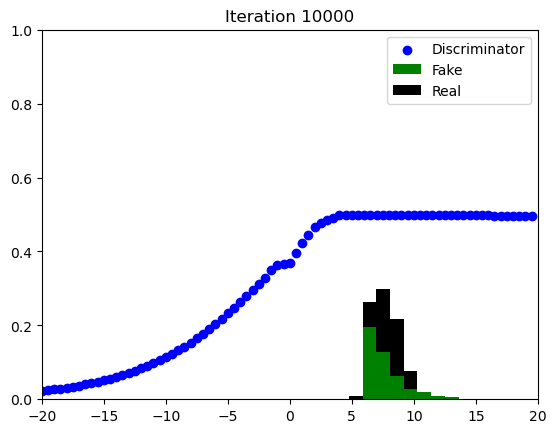

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output


# We will store the losses here
gen_losses = []
dis_losses = []

# Training loop
n_samples = 500
iterations = 10000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for iteration in range(1, iterations + 1):
    
    # ========== Train Discriminator ==========
    
    for param in generator.parameters():
        param.requires_grad = False
    for param in discriminator.parameters():
        param.requires_grad = True
    discriminator.zero_grad()
    
    # Get a random set of input noise
    noise = torch.normal(0, 1, size=(n_samples, latent_dim), device=device)
    
    # Also get a sample from the 'real' distribution
    real = torch.normal(real_mean, 1, size=(n_samples, latent_dim), device=device)
    
    # Generate some fake samples using the generator
    fake = generator(noise)
    
    # Concatenate the fake and real images
    dis_input = torch.cat((real, fake))

    # Make labels for generated and real data (set labels for real samples to 1)
    dis_labels = torch.zeros((2 * n_samples, latent_dim), device=device)
    dis_labels[:n_samples] = 1

    # Train discriminator with this batch of samples
    predictions = discriminator(dis_input)
    dis_loss = loss_function(predictions, dis_labels)
    dis_loss.backward()
    optimizer_dis.step()
    dis_losses.append(dis_loss.detach().cpu().numpy())

    # ========== Train Generator ==========
    
    for param in generator.parameters():
        param.requires_grad = True
    for param in discriminator.parameters():
        param.requires_grad = False
    generator.zero_grad()
    
    # Get a random set of input noise
    noise = torch.normal(0, 1, size=(n_samples, latent_dim), device=device)
    
    # From the generator's perspective, the discriminator should predict ones for all samples
    gen_labels = torch.ones((n_samples, latent_dim), device=device)
    
    # Train generator
    fake = generator(noise)
    predictions = discriminator(fake)
    gen_loss = loss_function(predictions, gen_labels)
    gen_loss.backward()
    optimizer_gen.step()
    gen_losses.append(gen_loss.detach().cpu().numpy())

    # ========== Make plot ==========
    
    # For every 100th iteration, plot samples from real and fake distributions
    if iteration % 100 == 0:
        
        # Generate fake samples and predictions without gradient calculations
        with torch.no_grad():
            
            # Get fake and real samples, together with discriminator predictions from a standard range of values
            noise = torch.normal(0, 1, size=(n_samples, latent_dim), device=device)
            fake = generator(noise)
            real = torch.normal(real_mean, 1, size=(n_samples, latent_dim), device=device)
            predictions = torch.sigmoid(discriminator(torch.arange(-20, 20, 0.5, device=device).view(80, 1)))
            
            # Make new plot and sleep half a second
            ax.cla()
            ax.set(xlim=(-20, 20), ylim=(0, 1))
            ax.hist((torch.squeeze(fake).cpu().numpy(), torch.squeeze(real).cpu().numpy()), density=True, stacked=True, color=('g','k'))
            ax.scatter(np.arange(-20, 20, 0.5), predictions.cpu().numpy(), c='b')
            ax.set_title('Iteration {}'.format(iteration))
            ax.legend(['Discriminator', 'Fake', 'Real'])
            display(fig)
            clear_output(wait=True)
            plt.pause(0.5)

If all is well, the fake and real distributions should overlap nicely after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

> ❓ Can you explain what happened to the blue line during training? Why does it look like it does after training?

If all is well, the blue line becomes horizontal: the discriminator $D$ predicts 0.5 for each sample. Hence, it can no longer distinguish between fake and real samples. 

<p style='background-color:rgba(80,255,80,0.4); padding:2px'> ⌨️ <b>Exercise</b> Try training the GAN with different input noise distributions for $z$, e.g. a uniform distribution. See if you can find a distribution for the real samples for which the generator fails to generate samples.
</p>

In principle, a uniform distribution shouldn't really be a problem. What could be a problem is if you move the distribution of real samples too far away from 0, by changing the `real_mean` parameter too much.

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. In the neural networks that we've trained so far, we have tried to train a neural network such that the loss decreases until a minimum is reached. 

> ❓ The loss curves that you get now look different. Can you explain why they're not nicely dropping to zero? Can you explain the value in the loss in the discriminator based on the objective function of the discriminator? Consider that we actually let the discriminator optimize a binary cross-entropy loss.

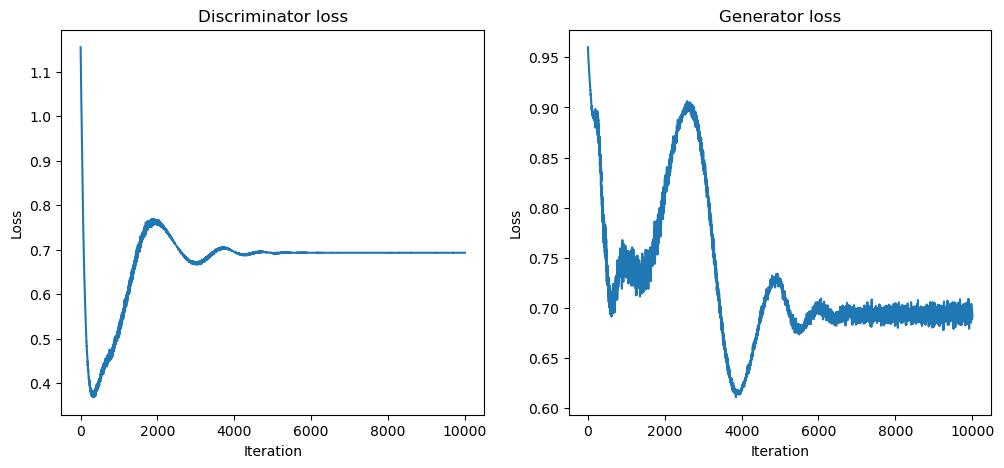

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dis_losses)
plt.title('Discriminator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(gen_losses)
plt.title('Generator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

If all is well, both loss curves converge to -ln(0.5) ~ 0.69. In binary cross-entropy, if the prediction is 0.5 for a sample for which the reference is either 0 or 1, the loss is -ln(0.5).

# MNIST synthesis
Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images. We will be synthesizing MNIST digits. To prepare for this, we first download the dataset. The code in this cell should look familiar:
- We compose several transforms into one transform
- The `torchvision` conveniently lets you generate a Dataset object that already includes the MNIST digit dataset (and downloads it from the internet)
- The DataLoader is just what we have used before.

However, note that we do not use MONAI here, instead we use an `original` PyTorch DataLoader, which works in just the same way.

In [7]:
import torchvision
from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype, Normalize
from torch.utils.data import DataLoader

# Define transform that converts PIL images into Tensors, with values between -1.0 and 1.0
transform = Compose([
    PILToTensor(),
    ConvertImageDtype(torch.float),
    Normalize(mean=0.5, std=0.5)
])

# Load the MNIST dataset
mnist_data = torchvision.datasets.MNIST(root='datasets', download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=100, shuffle=True)

The below code gets a batch of samples from the MNIST dataset and let's you plot these. These are the $28\times 28$ pixel images that you will be synthesizing.

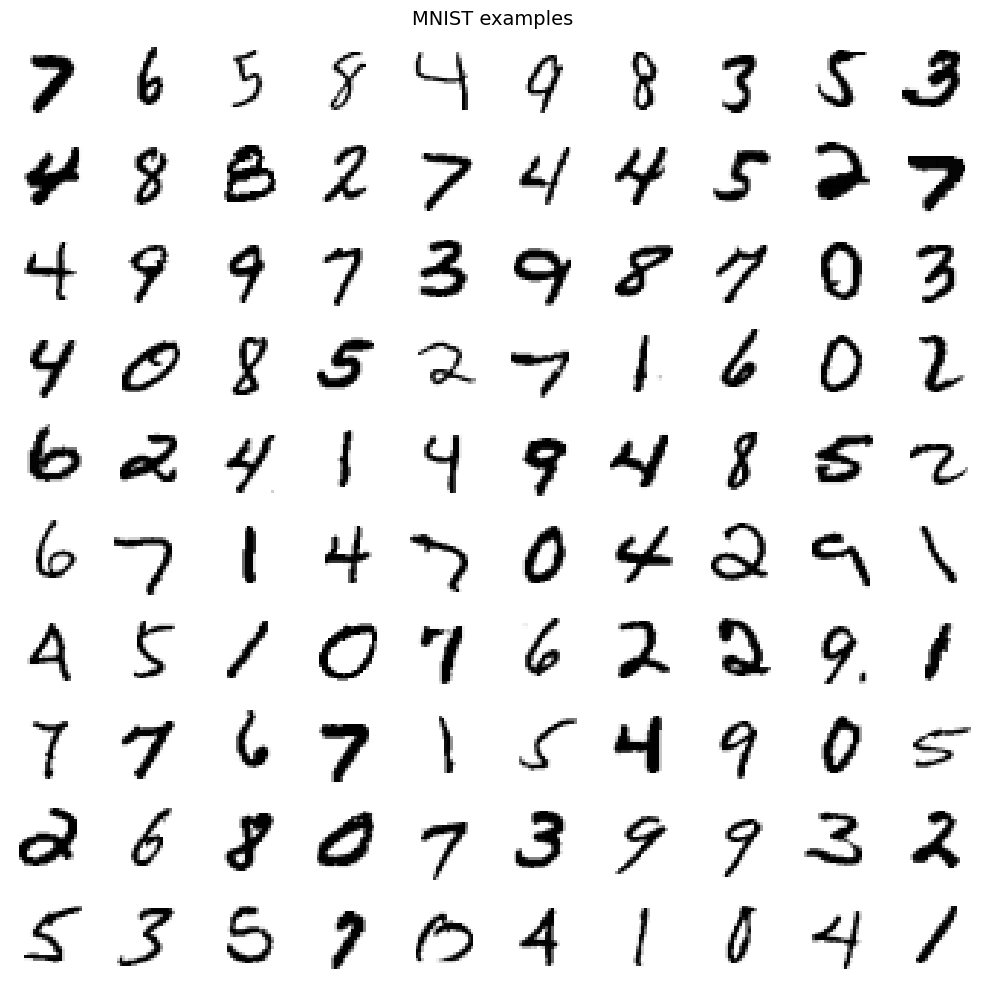

In [8]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    num_images = dim[0] * dim[1]
    images = images.reshape((num_images, 28, 28))
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=14)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Get first batch of images and plot them in a grid
images, labels = next(iter(data_loader))
plotImages(images.numpy(), title='MNIST examples')

Most deep learning tutorials build a discriminative model that is able to classify an image into one of the ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples. 

<img src="https://miro.medium.com/max/1000/1*Q7sZcfRj2M64GDD1ncvoCA.jpeg">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these first using the cells below. First, we define the discriminator, which will classify images as either *real* or *fake*.

> ❓ Is this a convolutional neural network? Why (not)?


No, there's no convolution layers.

In [9]:
class Discriminator_MLP(nn.Module):
    
    def __init__(self):
        super(Discriminator_MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=784, out_features=1024),
                                   nn.LeakyReLU(0.2),
                                   nn.Dropout(0.3),
                                   nn.Linear(in_features=1024, out_features=512),
                                   nn.LeakyReLU(0.2),                                   
                                   nn.Dropout(0.3),                                   
                                   nn.Linear(in_features=512, out_features=256),
                                   nn.LeakyReLU(0.2),                                   
                                   nn.Linear(in_features=256, out_features=1),
                                   nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1. We will sample noise from a 10-dimensional distribution. It's good to realize that this is still *much* lower than the 784 dimensions (28x28) that our original MNIST images have.

In [10]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [11]:
class Generator_MLP(nn.Module):
    
    def __init__(self):
        super(Generator_MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=latent_dim, out_features=256),
                                    nn.LeakyReLU(0.2),                                    
                                    nn.Linear(in_features=256, out_features=512),                                    
                                    nn.LeakyReLU(0.2),                                    
                                    nn.Linear(in_features=512, out_features=1024), 
                                    nn.LeakyReLU(0.2),                                   
                                    nn.Linear(in_features=1024, out_features=784),
                                    nn.Tanh())
       
    def forward(self, x):
        return self.layers(x)

> ❓ Consider the activation functions of the output layers of the generator and discriminator networks. How are they different?

The generator has a Tanh output, which means that all output values will be squashed between -1 and 1. The discriminator has a sigmoid output because it performs classification.

## The model
Now  let's combine the generator and the discriminator. We train both using a binary cross-entropy objective. This is very similar to what we did before.

In [12]:
# Get networks
discriminator = Discriminator_MLP()
generator = Generator_MLP()

# Push networks to device
discriminator.to(device)
generator.to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss = torch.nn.BCELoss()

We define some helper functions that will allow us to save and plot the models.

In [13]:
# Save model checkpoint in a folder called 'saved_models'
def saveModels(epoch, model_name):
    to_save = {
        'epoch': epoch,
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_gen': optimizer_gen.state_dict(),
        'optimizer_dis': optimizer_dis.state_dict()
    }
    directory = os.path.join('saved_models', model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    torch.save(to_save, os.path.join(directory, 'Epoch_{}.pt'.format(epoch)))
    
# Plot generated images in a grid
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    with torch.no_grad():
        noise = torch.normal(0, 1, size=(examples, latent_dim), device=device)
        fake_images = generator(noise).cpu().numpy()
        fake_images = fake_images.reshape(examples, 28, 28)

        fig = plt.figure(figsize=figsize)
        fig.suptitle('Epoch {}'.format(epoch), fontsize=14)
        for i in range(fake_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(fake_images[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        return fig

The code below can be used to train the GAN model. 
> ❓ Take a look at the code, it's actually very similar to what we used in the first, 1D, GAN. See if you can find at least two differences. 

If you run the code, synthesized images should be shown periodically. 

Some differences:
- We use label smoothing now (the real samples get label 0.9 instead of 1.0). This makes it more difficult for the discriminator to distinguish fake from real images, and is used to make GANs train better.
- The latent space dimensionality is larger
- We flatten the images before they go into the discriminator

In [14]:
from tqdm import tqdm
import os

dis_losses = []
gen_losses = []

epochs = 20
batch_size = 100
fig = None

for epoch in range(1, epochs + 1):
    
    # Wrap dataloader into tqdm such that we can print progress while training
    with tqdm(data_loader, unit="iterations") as tqdm_iterator:
        tqdm_iterator.set_description('Epoch {}'.format(epoch))
        
        for i, batch in enumerate(tqdm_iterator):

            # ========== Train Discriminator ==========
            
            # Freeze generator part
            for param in generator.parameters():
                param.requires_grad = False
            for param in discriminator.parameters():
                param.requires_grad = True
            discriminator.zero_grad()

            # Get a random set of input noise
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # Get real images and flatten the image dimensions
            real_images, _ = batch
            real_images = real_images.to(device).view(batch_size, 784)

            # Generate some fake MNIST images using the generator
            fake_images = generator(noise)

            # Concatenate the fake and real images
            dis_input = torch.cat((real_images, fake_images))

            # Labels for generated and real data
            dis_labels = torch.zeros((2 * batch_size, 1), device=device)

            # One-sided label smoothing
            dis_labels[:batch_size] = 0.9

            # Train discriminator with this batch of samples
            predictions = discriminator(dis_input)
            dis_loss = loss(predictions, dis_labels)
            dis_loss.backward()
            optimizer_dis.step()
            dis_losses.append(dis_loss.detach().cpu().numpy())

            # ========== Train Generator ==========
            
            # Freeze the discriminator part
            for param in generator.parameters():
                param.requires_grad = True
            for param in discriminator.parameters():
                param.requires_grad = False
            generator.zero_grad()

            # Train generator with a new batch of generated samples
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # From the generator's perspective, the discriminator should predict
            # ones for all samples
            gen_labels = torch.ones((batch_size, 1), device=device)

            # Train the GAN to predict ones
            fake_images = generator(noise)
            predictions = discriminator(fake_images)
            gen_loss = loss(predictions, gen_labels)
            gen_loss.backward()
            optimizer_gen.step()
            gen_losses.append(gen_loss.detach().cpu().numpy())
        
    # Display generated images every 5th epoch
    if epoch % 5 == 0:
        clear_output(wait=True)
        fig = plotGeneratedImages(epoch)
        saveModels(epoch, 'MLP_GAN')

  0%|                                           | 0/600 [00:00<?, ?iterations/s]

Epoch 1:   0%|                                  | 0/600 [00:00<?, ?iterations/s]

Epoch 1:   0%|                          | 1/600 [00:00<01:24,  7.10iterations/s]

Epoch 1:   0%|                          | 2/600 [00:00<01:19,  7.48iterations/s]

Epoch 1:   0%|▏                         | 3/600 [00:00<01:18,  7.65iterations/s]

Epoch 1:   1%|▏                         | 4/600 [00:00<01:17,  7.70iterations/s]

Epoch 1:   1%|▏                         | 5/600 [00:00<01:16,  7.74iterations/s]

Epoch 1:   1%|▎                         | 6/600 [00:00<01:16,  7.78iterations/s]

Epoch 1:   1%|▎                         | 7/600 [00:00<01:15,  7.80iterations/s]

Epoch 1:   1%|▎                         | 8/600 [00:01<01:16,  7.78iterations/s]

Epoch 1:   2%|▍                         | 9/600 [00:01<01:15,  7.79iterations/s]

Epoch 1:   2%|▍                        | 10/600 [00:01<01:15,  7.81iterations/s]

Epoch 1:   2%|▍                        | 11/600 [00:01<01:15,  7.82iterations/s]

Epoch 1:   2%|▌                        | 12/600 [00:01<01:14,  7.84iterations/s]

Epoch 1:   2%|▌                        | 13/600 [00:01<01:14,  7.86iterations/s]

Epoch 1:   2%|▌                        | 14/600 [00:01<01:14,  7.88iterations/s]

Epoch 1:   2%|▋                        | 15/600 [00:01<01:14,  7.87iterations/s]

Epoch 1:   3%|▋                        | 16/600 [00:02<01:14,  7.89iterations/s]

Epoch 1:   3%|▋                        | 17/600 [00:02<01:13,  7.88iterations/s]

Epoch 1:   3%|▊                        | 18/600 [00:02<01:13,  7.88iterations/s]

Epoch 1:   3%|▊                        | 19/600 [00:02<01:13,  7.88iterations/s]

Epoch 1:   3%|▊                        | 20/600 [00:02<01:13,  7.88iterations/s]

Epoch 1:   4%|▉                        | 21/600 [00:02<01:13,  7.89iterations/s]

Epoch 1:   4%|▉                        | 22/600 [00:02<01:13,  7.89iterations/s]

Epoch 1:   4%|▉                        | 23/600 [00:02<01:13,  7.90iterations/s]

Epoch 1:   4%|█                        | 24/600 [00:03<01:12,  7.90iterations/s]

Epoch 1:   4%|█                        | 25/600 [00:03<01:12,  7.90iterations/s]

Epoch 1:   4%|█                        | 26/600 [00:03<01:12,  7.91iterations/s]

Epoch 1:   4%|█▏                       | 27/600 [00:03<01:12,  7.91iterations/s]

Epoch 1:   5%|█▏                       | 28/600 [00:03<01:12,  7.91iterations/s]

Epoch 1:   5%|█▏                       | 29/600 [00:03<01:12,  7.92iterations/s]

Epoch 1:   5%|█▎                       | 30/600 [00:03<01:11,  7.94iterations/s]

Epoch 1:   5%|█▎                       | 31/600 [00:03<01:11,  7.94iterations/s]

Epoch 1:   5%|█▎                       | 32/600 [00:04<01:11,  7.93iterations/s]

Epoch 1:   6%|█▍                       | 33/600 [00:04<01:11,  7.95iterations/s]

Epoch 1:   6%|█▍                       | 34/600 [00:04<01:11,  7.95iterations/s]

Epoch 1:   6%|█▍                       | 35/600 [00:04<01:11,  7.95iterations/s]

Epoch 1:   6%|█▌                       | 36/600 [00:04<01:10,  7.95iterations/s]

Epoch 1:   6%|█▌                       | 37/600 [00:04<01:10,  7.94iterations/s]

Epoch 1:   6%|█▌                       | 38/600 [00:04<01:10,  7.94iterations/s]

Epoch 1:   6%|█▋                       | 39/600 [00:04<01:10,  7.94iterations/s]

Epoch 1:   7%|█▋                       | 40/600 [00:05<01:10,  7.94iterations/s]

Epoch 1:   7%|█▋                       | 41/600 [00:05<01:10,  7.95iterations/s]

Epoch 1:   7%|█▊                       | 42/600 [00:05<01:10,  7.94iterations/s]

Epoch 1:   7%|█▊                       | 43/600 [00:05<01:10,  7.94iterations/s]

Epoch 1:   7%|█▊                       | 44/600 [00:05<01:10,  7.93iterations/s]

Epoch 1:   8%|█▉                       | 45/600 [00:05<01:10,  7.91iterations/s]

Epoch 1:   8%|█▉                       | 46/600 [00:05<01:09,  7.92iterations/s]

Epoch 1:   8%|█▉                       | 47/600 [00:05<01:09,  7.92iterations/s]

Epoch 1:   8%|██                       | 48/600 [00:06<01:09,  7.92iterations/s]

Epoch 1:   8%|██                       | 49/600 [00:06<01:09,  7.92iterations/s]

Epoch 1:   8%|██                       | 50/600 [00:06<01:09,  7.92iterations/s]

Epoch 1:   8%|██▏                      | 51/600 [00:06<01:09,  7.93iterations/s]

Epoch 1:   9%|██▏                      | 52/600 [00:06<01:09,  7.93iterations/s]

Epoch 1:   9%|██▏                      | 53/600 [00:06<01:08,  7.93iterations/s]

Epoch 1:   9%|██▎                      | 54/600 [00:06<01:08,  7.93iterations/s]

Epoch 1:   9%|██▎                      | 55/600 [00:06<01:08,  7.93iterations/s]

Epoch 1:   9%|██▎                      | 56/600 [00:07<01:08,  7.94iterations/s]

Epoch 1:  10%|██▍                      | 57/600 [00:07<01:08,  7.94iterations/s]

Epoch 1:  10%|██▍                      | 58/600 [00:07<01:08,  7.94iterations/s]

Epoch 1:  10%|██▍                      | 59/600 [00:07<01:08,  7.95iterations/s]

Epoch 1:  10%|██▌                      | 60/600 [00:07<01:07,  7.95iterations/s]

Epoch 1:  10%|██▌                      | 61/600 [00:07<01:07,  7.95iterations/s]

Epoch 1:  10%|██▌                      | 62/600 [00:07<01:07,  7.93iterations/s]

Epoch 1:  10%|██▋                      | 63/600 [00:07<01:07,  7.94iterations/s]

Epoch 1:  11%|██▋                      | 64/600 [00:08<01:07,  7.94iterations/s]

Epoch 1:  11%|██▋                      | 65/600 [00:08<01:07,  7.94iterations/s]

Epoch 1:  11%|██▊                      | 66/600 [00:08<01:07,  7.93iterations/s]

Epoch 1:  11%|██▊                      | 67/600 [00:08<01:07,  7.95iterations/s]

Epoch 1:  11%|██▊                      | 68/600 [00:08<01:06,  7.96iterations/s]

Epoch 1:  12%|██▉                      | 69/600 [00:08<01:06,  7.95iterations/s]

Epoch 1:  12%|██▉                      | 70/600 [00:08<01:06,  7.95iterations/s]

Epoch 1:  12%|██▉                      | 71/600 [00:08<01:06,  7.92iterations/s]

Epoch 1:  12%|███                      | 72/600 [00:09<01:06,  7.92iterations/s]

Epoch 1:  12%|███                      | 73/600 [00:09<01:06,  7.94iterations/s]

Epoch 1:  12%|███                      | 74/600 [00:09<01:06,  7.93iterations/s]

Epoch 1:  12%|███▏                     | 75/600 [00:09<01:06,  7.93iterations/s]

Epoch 1:  13%|███▏                     | 76/600 [00:09<01:06,  7.93iterations/s]

Epoch 1:  13%|███▏                     | 77/600 [00:09<01:06,  7.92iterations/s]

Epoch 1:  13%|███▎                     | 78/600 [00:09<01:05,  7.94iterations/s]

Epoch 1:  13%|███▎                     | 79/600 [00:09<01:05,  7.93iterations/s]

Epoch 1:  13%|███▎                     | 80/600 [00:10<01:05,  7.92iterations/s]

Epoch 1:  14%|███▍                     | 81/600 [00:10<01:05,  7.92iterations/s]

Epoch 1:  14%|███▍                     | 82/600 [00:10<01:05,  7.94iterations/s]

Epoch 1:  14%|███▍                     | 83/600 [00:10<01:05,  7.94iterations/s]

Epoch 1:  14%|███▌                     | 84/600 [00:10<01:04,  7.94iterations/s]

Epoch 1:  14%|███▌                     | 85/600 [00:10<01:04,  7.94iterations/s]

Epoch 1:  14%|███▌                     | 86/600 [00:10<01:04,  7.91iterations/s]

Epoch 1:  14%|███▌                     | 87/600 [00:11<01:05,  7.88iterations/s]

Epoch 1:  15%|███▋                     | 88/600 [00:11<01:04,  7.88iterations/s]

Epoch 1:  15%|███▋                     | 89/600 [00:11<01:04,  7.89iterations/s]

Epoch 1:  15%|███▊                     | 90/600 [00:11<01:04,  7.90iterations/s]

Epoch 1:  15%|███▊                     | 91/600 [00:11<01:04,  7.89iterations/s]

Epoch 1:  15%|███▊                     | 92/600 [00:11<01:04,  7.90iterations/s]

Epoch 1:  16%|███▉                     | 93/600 [00:11<01:04,  7.91iterations/s]

Epoch 1:  16%|███▉                     | 94/600 [00:11<01:04,  7.90iterations/s]

Epoch 1:  16%|███▉                     | 95/600 [00:12<01:03,  7.89iterations/s]

Epoch 1:  16%|████                     | 96/600 [00:12<01:03,  7.90iterations/s]

Epoch 1:  16%|████                     | 97/600 [00:12<01:03,  7.90iterations/s]

Epoch 1:  16%|████                     | 98/600 [00:12<01:03,  7.89iterations/s]

Epoch 1:  16%|████▏                    | 99/600 [00:12<01:03,  7.89iterations/s]

Epoch 1:  17%|████                    | 100/600 [00:12<01:03,  7.91iterations/s]

Epoch 1:  17%|████                    | 101/600 [00:12<01:03,  7.90iterations/s]

Epoch 1:  17%|████                    | 102/600 [00:12<01:03,  7.89iterations/s]

Epoch 1:  17%|████                    | 103/600 [00:13<01:02,  7.90iterations/s]

Epoch 1:  17%|████▏                   | 104/600 [00:13<01:02,  7.89iterations/s]

Epoch 1:  18%|████▏                   | 105/600 [00:13<01:02,  7.89iterations/s]

Epoch 1:  18%|████▏                   | 106/600 [00:13<01:02,  7.88iterations/s]

Epoch 1:  18%|████▎                   | 107/600 [00:13<01:02,  7.83iterations/s]

Epoch 1:  18%|████▎                   | 108/600 [00:13<01:02,  7.82iterations/s]

Epoch 1:  18%|████▎                   | 109/600 [00:13<01:02,  7.84iterations/s]

Epoch 1:  18%|████▍                   | 110/600 [00:13<01:02,  7.85iterations/s]

Epoch 1:  18%|████▍                   | 111/600 [00:14<01:02,  7.87iterations/s]

Epoch 1:  19%|████▍                   | 112/600 [00:14<01:01,  7.88iterations/s]

Epoch 1:  19%|████▌                   | 113/600 [00:14<01:01,  7.89iterations/s]

Epoch 1:  19%|████▌                   | 114/600 [00:14<01:01,  7.90iterations/s]

Epoch 1:  19%|████▌                   | 115/600 [00:14<01:01,  7.92iterations/s]

Epoch 1:  19%|████▋                   | 116/600 [00:14<01:01,  7.92iterations/s]

Epoch 1:  20%|████▋                   | 117/600 [00:14<01:00,  7.94iterations/s]

Epoch 1:  20%|████▋                   | 118/600 [00:14<01:00,  7.94iterations/s]

Epoch 1:  20%|████▊                   | 119/600 [00:15<01:00,  7.94iterations/s]

Epoch 1:  20%|████▊                   | 120/600 [00:15<01:00,  7.93iterations/s]

Epoch 1:  20%|████▊                   | 121/600 [00:15<01:00,  7.93iterations/s]

Epoch 1:  20%|████▉                   | 122/600 [00:15<01:00,  7.93iterations/s]

Epoch 1:  20%|████▉                   | 123/600 [00:15<01:00,  7.94iterations/s]

Epoch 1:  21%|████▉                   | 124/600 [00:15<00:59,  7.94iterations/s]

Epoch 1:  21%|█████                   | 125/600 [00:15<00:59,  7.93iterations/s]

Epoch 1:  21%|█████                   | 126/600 [00:15<00:59,  7.92iterations/s]

Epoch 1:  21%|█████                   | 127/600 [00:16<00:59,  7.90iterations/s]

Epoch 1:  21%|█████                   | 128/600 [00:16<00:59,  7.92iterations/s]

Epoch 1:  22%|█████▏                  | 129/600 [00:16<00:59,  7.92iterations/s]

Epoch 1:  22%|█████▏                  | 130/600 [00:16<00:59,  7.92iterations/s]

Epoch 1:  22%|█████▏                  | 131/600 [00:16<00:59,  7.92iterations/s]

Epoch 1:  22%|█████▎                  | 132/600 [00:16<00:59,  7.93iterations/s]

Epoch 1:  22%|█████▎                  | 133/600 [00:16<00:58,  7.94iterations/s]

Epoch 1:  22%|█████▎                  | 134/600 [00:16<00:58,  7.95iterations/s]

Epoch 1:  22%|█████▍                  | 135/600 [00:17<00:58,  7.95iterations/s]

Epoch 1:  23%|█████▍                  | 136/600 [00:17<00:58,  7.94iterations/s]

Epoch 1:  23%|█████▍                  | 137/600 [00:17<00:58,  7.95iterations/s]

Epoch 1:  23%|█████▌                  | 138/600 [00:17<00:58,  7.96iterations/s]

Epoch 1:  23%|█████▌                  | 139/600 [00:17<00:57,  7.95iterations/s]

Epoch 1:  23%|█████▌                  | 140/600 [00:17<00:57,  7.95iterations/s]

Epoch 1:  24%|█████▋                  | 141/600 [00:17<00:57,  7.96iterations/s]

Epoch 1:  24%|█████▋                  | 142/600 [00:17<00:57,  7.96iterations/s]

Epoch 1:  24%|█████▋                  | 143/600 [00:18<00:57,  7.96iterations/s]

Epoch 1:  24%|█████▊                  | 144/600 [00:18<00:57,  7.96iterations/s]

Epoch 1:  24%|█████▊                  | 145/600 [00:18<00:57,  7.96iterations/s]

Epoch 1:  24%|█████▊                  | 146/600 [00:18<00:57,  7.95iterations/s]

Epoch 1:  24%|█████▉                  | 147/600 [00:18<00:57,  7.94iterations/s]

Epoch 1:  25%|█████▉                  | 148/600 [00:18<00:56,  7.94iterations/s]

Epoch 1:  25%|█████▉                  | 149/600 [00:18<00:56,  7.95iterations/s]

Epoch 1:  25%|██████                  | 150/600 [00:18<00:56,  7.92iterations/s]

Epoch 1:  25%|██████                  | 151/600 [00:19<00:56,  7.92iterations/s]

Epoch 1:  25%|██████                  | 152/600 [00:19<00:56,  7.92iterations/s]

Epoch 1:  26%|██████                  | 153/600 [00:19<00:56,  7.92iterations/s]

Epoch 1:  26%|██████▏                 | 154/600 [00:19<00:56,  7.92iterations/s]

Epoch 1:  26%|██████▏                 | 155/600 [00:19<00:56,  7.93iterations/s]

Epoch 1:  26%|██████▏                 | 156/600 [00:19<00:56,  7.89iterations/s]

Epoch 1:  26%|██████▎                 | 157/600 [00:19<00:56,  7.88iterations/s]

Epoch 1:  26%|██████▎                 | 158/600 [00:19<00:55,  7.90iterations/s]

Epoch 1:  26%|██████▎                 | 159/600 [00:20<00:55,  7.90iterations/s]

Epoch 1:  27%|██████▍                 | 160/600 [00:20<00:55,  7.91iterations/s]

Epoch 1:  27%|██████▍                 | 161/600 [00:20<00:55,  7.91iterations/s]

Epoch 1:  27%|██████▍                 | 162/600 [00:20<00:55,  7.91iterations/s]

Epoch 1:  27%|██████▌                 | 163/600 [00:20<00:55,  7.91iterations/s]

Epoch 1:  27%|██████▌                 | 164/600 [00:20<00:55,  7.89iterations/s]

Epoch 1:  28%|██████▌                 | 165/600 [00:20<00:55,  7.84iterations/s]

Epoch 1:  28%|██████▋                 | 166/600 [00:20<00:55,  7.86iterations/s]

Epoch 1:  28%|██████▋                 | 167/600 [00:21<00:54,  7.87iterations/s]

Epoch 1:  28%|██████▋                 | 168/600 [00:21<00:54,  7.88iterations/s]

Epoch 1:  28%|██████▊                 | 169/600 [00:21<00:54,  7.89iterations/s]

Epoch 1:  28%|██████▊                 | 170/600 [00:21<00:54,  7.89iterations/s]

Epoch 1:  28%|██████▊                 | 171/600 [00:21<00:54,  7.91iterations/s]

Epoch 1:  29%|██████▉                 | 172/600 [00:21<00:54,  7.92iterations/s]

Epoch 1:  29%|██████▉                 | 173/600 [00:21<00:53,  7.92iterations/s]

Epoch 1:  29%|██████▉                 | 174/600 [00:22<00:53,  7.91iterations/s]

Epoch 1:  29%|███████                 | 175/600 [00:22<00:53,  7.92iterations/s]

Epoch 1:  29%|███████                 | 176/600 [00:22<00:53,  7.92iterations/s]

Epoch 1:  30%|███████                 | 177/600 [00:22<00:53,  7.92iterations/s]

Epoch 1:  30%|███████                 | 178/600 [00:22<00:53,  7.92iterations/s]

Epoch 1:  30%|███████▏                | 179/600 [00:22<00:53,  7.91iterations/s]

Epoch 1:  30%|███████▏                | 180/600 [00:22<00:53,  7.92iterations/s]

Epoch 1:  30%|███████▏                | 181/600 [00:22<00:52,  7.93iterations/s]

Epoch 1:  30%|███████▎                | 182/600 [00:23<00:52,  7.93iterations/s]

Epoch 1:  30%|███████▎                | 183/600 [00:23<00:52,  7.94iterations/s]

Epoch 1:  31%|███████▎                | 184/600 [00:23<00:52,  7.93iterations/s]

Epoch 1:  31%|███████▍                | 185/600 [00:23<00:52,  7.93iterations/s]

Epoch 1:  31%|███████▍                | 186/600 [00:23<00:52,  7.94iterations/s]

Epoch 1:  31%|███████▍                | 187/600 [00:23<00:52,  7.94iterations/s]

Epoch 1:  31%|███████▌                | 188/600 [00:23<00:51,  7.94iterations/s]

Epoch 1:  32%|███████▌                | 189/600 [00:23<00:51,  7.92iterations/s]

Epoch 1:  32%|███████▌                | 190/600 [00:24<00:51,  7.93iterations/s]

Epoch 1:  32%|███████▋                | 191/600 [00:24<00:51,  7.91iterations/s]

Epoch 1:  32%|███████▋                | 192/600 [00:24<00:51,  7.91iterations/s]

Epoch 1:  32%|███████▋                | 193/600 [00:24<00:51,  7.90iterations/s]

Epoch 1:  32%|███████▊                | 194/600 [00:24<00:51,  7.89iterations/s]

Epoch 1:  32%|███████▊                | 195/600 [00:24<00:51,  7.88iterations/s]

Epoch 1:  33%|███████▊                | 196/600 [00:24<00:51,  7.89iterations/s]

Epoch 1:  33%|███████▉                | 197/600 [00:24<00:51,  7.88iterations/s]

Epoch 1:  33%|███████▉                | 198/600 [00:25<00:51,  7.88iterations/s]

Epoch 1:  33%|███████▉                | 199/600 [00:25<00:50,  7.87iterations/s]

Epoch 1:  33%|████████                | 200/600 [00:25<00:50,  7.89iterations/s]

Epoch 1:  34%|████████                | 201/600 [00:25<00:50,  7.88iterations/s]

Epoch 1:  34%|████████                | 202/600 [00:25<00:50,  7.89iterations/s]

Epoch 1:  34%|████████                | 203/600 [00:25<00:50,  7.88iterations/s]

Epoch 1:  34%|████████▏               | 204/600 [00:25<00:50,  7.88iterations/s]

Epoch 1:  34%|████████▏               | 205/600 [00:25<00:50,  7.89iterations/s]

Epoch 1:  34%|████████▏               | 206/600 [00:26<00:49,  7.89iterations/s]

Epoch 1:  34%|████████▎               | 207/600 [00:26<00:49,  7.90iterations/s]

Epoch 1:  35%|████████▎               | 208/600 [00:26<00:49,  7.90iterations/s]

Epoch 1:  35%|████████▎               | 209/600 [00:26<00:49,  7.89iterations/s]

Epoch 1:  35%|████████▍               | 210/600 [00:26<00:49,  7.89iterations/s]

Epoch 1:  35%|████████▍               | 211/600 [00:26<00:49,  7.88iterations/s]

Epoch 1:  35%|████████▍               | 212/600 [00:26<00:49,  7.88iterations/s]

Epoch 1:  36%|████████▌               | 213/600 [00:26<00:49,  7.89iterations/s]

Epoch 1:  36%|████████▌               | 214/600 [00:27<00:48,  7.89iterations/s]

Epoch 1:  36%|████████▌               | 215/600 [00:27<00:48,  7.88iterations/s]

Epoch 1:  36%|████████▋               | 216/600 [00:27<00:48,  7.90iterations/s]

Epoch 1:  36%|████████▋               | 217/600 [00:27<00:48,  7.90iterations/s]

Epoch 1:  36%|████████▋               | 218/600 [00:27<00:48,  7.90iterations/s]

Epoch 1:  36%|████████▊               | 219/600 [00:27<00:48,  7.89iterations/s]

Epoch 1:  37%|████████▊               | 220/600 [00:27<00:48,  7.90iterations/s]

Epoch 1:  37%|████████▊               | 221/600 [00:27<00:47,  7.90iterations/s]

Epoch 1:  37%|████████▉               | 222/600 [00:28<00:47,  7.90iterations/s]

Epoch 1:  37%|████████▉               | 223/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  37%|████████▉               | 224/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  38%|█████████               | 225/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  38%|█████████               | 226/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  38%|█████████               | 227/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  38%|█████████               | 228/600 [00:28<00:47,  7.91iterations/s]

Epoch 1:  38%|█████████▏              | 229/600 [00:28<00:46,  7.90iterations/s]

Epoch 1:  38%|█████████▏              | 230/600 [00:29<00:46,  7.89iterations/s]

Epoch 1:  38%|█████████▏              | 231/600 [00:29<00:46,  7.89iterations/s]

Epoch 1:  39%|█████████▎              | 232/600 [00:29<00:46,  7.91iterations/s]

Epoch 1:  39%|█████████▎              | 233/600 [00:29<00:46,  7.91iterations/s]

Epoch 1:  39%|█████████▎              | 234/600 [00:29<00:46,  7.92iterations/s]

Epoch 1:  39%|█████████▍              | 235/600 [00:29<00:46,  7.92iterations/s]

Epoch 1:  39%|█████████▍              | 236/600 [00:29<00:46,  7.91iterations/s]

Epoch 1:  40%|█████████▍              | 237/600 [00:29<00:45,  7.91iterations/s]

Epoch 1:  40%|█████████▌              | 238/600 [00:30<00:45,  7.91iterations/s]

Epoch 1:  40%|█████████▌              | 239/600 [00:30<00:45,  7.91iterations/s]

Epoch 1:  40%|█████████▌              | 240/600 [00:30<00:45,  7.91iterations/s]

Epoch 1:  40%|█████████▋              | 241/600 [00:30<00:45,  7.92iterations/s]

Epoch 1:  40%|█████████▋              | 242/600 [00:30<00:45,  7.93iterations/s]

Epoch 1:  40%|█████████▋              | 243/600 [00:30<00:45,  7.91iterations/s]

Epoch 1:  41%|█████████▊              | 244/600 [00:30<00:44,  7.92iterations/s]

Epoch 1:  41%|█████████▊              | 245/600 [00:30<00:44,  7.92iterations/s]

Epoch 1:  41%|█████████▊              | 246/600 [00:31<00:44,  7.92iterations/s]

Epoch 1:  41%|█████████▉              | 247/600 [00:31<00:44,  7.94iterations/s]

Epoch 1:  41%|█████████▉              | 248/600 [00:31<00:44,  7.93iterations/s]

Epoch 1:  42%|█████████▉              | 249/600 [00:31<00:44,  7.94iterations/s]

Epoch 1:  42%|██████████              | 250/600 [00:31<00:44,  7.95iterations/s]

Epoch 1:  42%|██████████              | 251/600 [00:31<00:44,  7.91iterations/s]

Epoch 1:  42%|██████████              | 252/600 [00:31<00:43,  7.92iterations/s]

Epoch 1:  42%|██████████              | 253/600 [00:31<00:43,  7.93iterations/s]

Epoch 1:  42%|██████████▏             | 254/600 [00:32<00:43,  7.93iterations/s]

Epoch 1:  42%|██████████▏             | 255/600 [00:32<00:43,  7.92iterations/s]

Epoch 1:  43%|██████████▏             | 256/600 [00:32<00:43,  7.92iterations/s]

Epoch 1:  43%|██████████▎             | 257/600 [00:32<00:43,  7.91iterations/s]

Epoch 1:  43%|██████████▎             | 258/600 [00:32<00:43,  7.91iterations/s]

Epoch 1:  43%|██████████▎             | 259/600 [00:32<00:43,  7.93iterations/s]

Epoch 1:  43%|██████████▍             | 260/600 [00:32<00:42,  7.93iterations/s]

Epoch 1:  44%|██████████▍             | 261/600 [00:33<00:42,  7.94iterations/s]

Epoch 1:  44%|██████████▍             | 262/600 [00:33<00:42,  7.92iterations/s]

Epoch 1:  44%|██████████▌             | 263/600 [00:33<00:42,  7.91iterations/s]

Epoch 1:  44%|██████████▌             | 264/600 [00:33<00:42,  7.91iterations/s]

Epoch 1:  44%|██████████▌             | 265/600 [00:33<00:42,  7.92iterations/s]

Epoch 1:  44%|██████████▋             | 266/600 [00:33<00:42,  7.91iterations/s]

Epoch 1:  44%|██████████▋             | 267/600 [00:33<00:42,  7.85iterations/s]

Epoch 1:  45%|██████████▋             | 268/600 [00:33<00:42,  7.87iterations/s]

Epoch 1:  45%|██████████▊             | 269/600 [00:34<00:42,  7.88iterations/s]

Epoch 1:  45%|██████████▊             | 270/600 [00:34<00:41,  7.90iterations/s]

Epoch 1:  45%|██████████▊             | 271/600 [00:34<00:41,  7.91iterations/s]

Epoch 1:  45%|██████████▉             | 272/600 [00:34<00:41,  7.92iterations/s]

Epoch 1:  46%|██████████▉             | 273/600 [00:34<00:41,  7.91iterations/s]

Epoch 1:  46%|██████████▉             | 274/600 [00:34<00:41,  7.92iterations/s]

Epoch 1:  46%|███████████             | 275/600 [00:34<00:40,  7.93iterations/s]

Epoch 1:  46%|███████████             | 276/600 [00:34<00:40,  7.93iterations/s]

Epoch 1:  46%|███████████             | 277/600 [00:35<00:40,  7.93iterations/s]

Epoch 1:  46%|███████████             | 278/600 [00:35<00:40,  7.93iterations/s]

Epoch 1:  46%|███████████▏            | 279/600 [00:35<00:40,  7.93iterations/s]

Epoch 1:  47%|███████████▏            | 280/600 [00:35<00:40,  7.92iterations/s]

Epoch 1:  47%|███████████▏            | 281/600 [00:35<00:40,  7.92iterations/s]

Epoch 1:  47%|███████████▎            | 282/600 [00:35<00:40,  7.92iterations/s]

Epoch 1:  47%|███████████▎            | 283/600 [00:35<00:40,  7.92iterations/s]

Epoch 1:  47%|███████████▎            | 284/600 [00:35<00:39,  7.93iterations/s]

Epoch 1:  48%|███████████▍            | 285/600 [00:36<00:39,  7.94iterations/s]

Epoch 1:  48%|███████████▍            | 286/600 [00:36<00:39,  7.94iterations/s]

Epoch 1:  48%|███████████▍            | 287/600 [00:36<00:39,  7.95iterations/s]

Epoch 1:  48%|███████████▌            | 288/600 [00:36<00:39,  7.94iterations/s]

Epoch 1:  48%|███████████▌            | 289/600 [00:36<00:39,  7.95iterations/s]

Epoch 1:  48%|███████████▌            | 290/600 [00:36<00:39,  7.94iterations/s]

Epoch 1:  48%|███████████▋            | 291/600 [00:36<00:38,  7.94iterations/s]

Epoch 1:  49%|███████████▋            | 292/600 [00:36<00:38,  7.92iterations/s]

Epoch 1:  49%|███████████▋            | 293/600 [00:37<00:38,  7.90iterations/s]

Epoch 1:  49%|███████████▊            | 294/600 [00:37<00:38,  7.90iterations/s]

Epoch 1:  49%|███████████▊            | 295/600 [00:37<00:38,  7.90iterations/s]

Epoch 1:  49%|███████████▊            | 296/600 [00:37<00:38,  7.91iterations/s]

Epoch 1:  50%|███████████▉            | 297/600 [00:37<00:38,  7.92iterations/s]

Epoch 1:  50%|███████████▉            | 298/600 [00:37<00:38,  7.91iterations/s]

Epoch 1:  50%|███████████▉            | 299/600 [00:37<00:38,  7.91iterations/s]

Epoch 1:  50%|████████████            | 300/600 [00:37<00:37,  7.92iterations/s]

Epoch 1:  50%|████████████            | 301/600 [00:38<00:37,  7.93iterations/s]

Epoch 1:  50%|████████████            | 302/600 [00:38<00:37,  7.93iterations/s]

Epoch 1:  50%|████████████            | 303/600 [00:38<00:37,  7.94iterations/s]

Epoch 1:  51%|████████████▏           | 304/600 [00:38<00:37,  7.93iterations/s]

Epoch 1:  51%|████████████▏           | 305/600 [00:38<00:37,  7.93iterations/s]

Epoch 1:  51%|████████████▏           | 306/600 [00:38<00:37,  7.93iterations/s]

Epoch 1:  51%|████████████▎           | 307/600 [00:38<00:37,  7.92iterations/s]

Epoch 1:  51%|████████████▎           | 308/600 [00:38<00:36,  7.93iterations/s]

Epoch 1:  52%|████████████▎           | 309/600 [00:39<00:36,  7.90iterations/s]

Epoch 1:  52%|████████████▍           | 310/600 [00:39<00:36,  7.91iterations/s]

Epoch 1:  52%|████████████▍           | 311/600 [00:39<00:36,  7.92iterations/s]

Epoch 1:  52%|████████████▍           | 312/600 [00:39<00:36,  7.92iterations/s]

Epoch 1:  52%|████████████▌           | 313/600 [00:39<00:36,  7.91iterations/s]

Epoch 1:  52%|████████████▌           | 314/600 [00:39<00:36,  7.92iterations/s]

Epoch 1:  52%|████████████▌           | 315/600 [00:39<00:36,  7.89iterations/s]

Epoch 1:  53%|████████████▋           | 316/600 [00:39<00:35,  7.90iterations/s]

Epoch 1:  53%|████████████▋           | 317/600 [00:40<00:35,  7.90iterations/s]

Epoch 1:  53%|████████████▋           | 318/600 [00:40<00:35,  7.90iterations/s]

Epoch 1:  53%|████████████▊           | 319/600 [00:40<00:35,  7.91iterations/s]

Epoch 1:  53%|████████████▊           | 320/600 [00:40<00:35,  7.92iterations/s]

Epoch 1:  54%|████████████▊           | 321/600 [00:40<00:35,  7.92iterations/s]

Epoch 1:  54%|████████████▉           | 322/600 [00:40<00:35,  7.93iterations/s]

Epoch 1:  54%|████████████▉           | 323/600 [00:40<00:34,  7.92iterations/s]

Epoch 1:  54%|████████████▉           | 324/600 [00:40<00:34,  7.92iterations/s]

Epoch 1:  54%|█████████████           | 325/600 [00:41<00:34,  7.93iterations/s]

Epoch 1:  54%|█████████████           | 326/600 [00:41<00:34,  7.93iterations/s]

Epoch 1:  55%|█████████████           | 327/600 [00:41<00:34,  7.94iterations/s]

Epoch 1:  55%|█████████████           | 328/600 [00:41<00:34,  7.93iterations/s]

Epoch 1:  55%|█████████████▏          | 329/600 [00:41<00:34,  7.94iterations/s]

Epoch 1:  55%|█████████████▏          | 330/600 [00:41<00:34,  7.93iterations/s]

Epoch 1:  55%|█████████████▏          | 331/600 [00:41<00:33,  7.92iterations/s]

Epoch 1:  55%|█████████████▎          | 332/600 [00:41<00:33,  7.93iterations/s]

Epoch 1:  56%|█████████████▎          | 333/600 [00:42<00:33,  7.93iterations/s]

Epoch 1:  56%|█████████████▎          | 334/600 [00:42<00:33,  7.92iterations/s]

Epoch 1:  56%|█████████████▍          | 335/600 [00:42<00:33,  7.92iterations/s]

Epoch 1:  56%|█████████████▍          | 336/600 [00:42<00:33,  7.92iterations/s]

Epoch 1:  56%|█████████████▍          | 337/600 [00:42<00:33,  7.93iterations/s]

Epoch 1:  56%|█████████████▌          | 338/600 [00:42<00:33,  7.92iterations/s]

Epoch 1:  56%|█████████████▌          | 339/600 [00:42<00:32,  7.92iterations/s]

Epoch 1:  57%|█████████████▌          | 340/600 [00:42<00:32,  7.92iterations/s]

Epoch 1:  57%|█████████████▋          | 341/600 [00:43<00:32,  7.92iterations/s]

Epoch 1:  57%|█████████████▋          | 342/600 [00:43<00:32,  7.92iterations/s]

Epoch 1:  57%|█████████████▋          | 343/600 [00:43<00:32,  7.91iterations/s]

Epoch 1:  57%|█████████████▊          | 344/600 [00:43<00:32,  7.92iterations/s]

Epoch 1:  57%|█████████████▊          | 345/600 [00:43<00:32,  7.91iterations/s]

Epoch 1:  58%|█████████████▊          | 346/600 [00:43<00:32,  7.91iterations/s]

Epoch 1:  58%|█████████████▉          | 347/600 [00:43<00:32,  7.90iterations/s]

Epoch 1:  58%|█████████████▉          | 348/600 [00:43<00:31,  7.92iterations/s]

Epoch 1:  58%|█████████████▉          | 349/600 [00:44<00:31,  7.92iterations/s]

Epoch 1:  58%|██████████████          | 350/600 [00:44<00:31,  7.93iterations/s]

Epoch 1:  58%|██████████████          | 351/600 [00:44<00:31,  7.93iterations/s]

Epoch 1:  59%|██████████████          | 352/600 [00:44<00:31,  7.92iterations/s]

Epoch 1:  59%|██████████████          | 353/600 [00:44<00:31,  7.91iterations/s]

Epoch 1:  59%|██████████████▏         | 354/600 [00:44<00:31,  7.92iterations/s]

Epoch 1:  59%|██████████████▏         | 355/600 [00:44<00:30,  7.92iterations/s]

Epoch 1:  59%|██████████████▏         | 356/600 [00:45<00:30,  7.93iterations/s]

Epoch 1:  60%|██████████████▎         | 357/600 [00:45<00:30,  7.93iterations/s]

Epoch 1:  60%|██████████████▎         | 358/600 [00:45<00:30,  7.93iterations/s]

Epoch 1:  60%|██████████████▎         | 359/600 [00:45<00:30,  7.93iterations/s]

Epoch 1:  60%|██████████████▍         | 360/600 [00:45<00:30,  7.92iterations/s]

Epoch 1:  60%|██████████████▍         | 361/600 [00:45<00:30,  7.92iterations/s]

Epoch 1:  60%|██████████████▍         | 362/600 [00:45<00:30,  7.92iterations/s]

Epoch 1:  60%|██████████████▌         | 363/600 [00:45<00:29,  7.92iterations/s]

Epoch 1:  61%|██████████████▌         | 364/600 [00:46<00:29,  7.91iterations/s]

Epoch 1:  61%|██████████████▌         | 365/600 [00:46<00:29,  7.92iterations/s]

Epoch 1:  61%|██████████████▋         | 366/600 [00:46<00:29,  7.92iterations/s]

Epoch 1:  61%|██████████████▋         | 367/600 [00:46<00:29,  7.90iterations/s]

Epoch 1:  61%|██████████████▋         | 368/600 [00:46<00:29,  7.91iterations/s]

Epoch 1:  62%|██████████████▊         | 369/600 [00:46<00:29,  7.92iterations/s]

Epoch 1:  62%|██████████████▊         | 370/600 [00:46<00:29,  7.92iterations/s]

Epoch 1:  62%|██████████████▊         | 371/600 [00:46<00:28,  7.92iterations/s]

Epoch 1:  62%|██████████████▉         | 372/600 [00:47<00:28,  7.93iterations/s]

Epoch 1:  62%|██████████████▉         | 373/600 [00:47<00:28,  7.92iterations/s]

Epoch 1:  62%|██████████████▉         | 374/600 [00:47<00:28,  7.91iterations/s]

Epoch 1:  62%|███████████████         | 375/600 [00:47<00:28,  7.92iterations/s]

Epoch 1:  63%|███████████████         | 376/600 [00:47<00:28,  7.92iterations/s]

Epoch 1:  63%|███████████████         | 377/600 [00:47<00:28,  7.91iterations/s]

Epoch 1:  63%|███████████████         | 378/600 [00:47<00:28,  7.91iterations/s]

Epoch 1:  63%|███████████████▏        | 379/600 [00:47<00:28,  7.89iterations/s]

Epoch 1:  63%|███████████████▏        | 380/600 [00:48<00:27,  7.91iterations/s]

Epoch 1:  64%|███████████████▏        | 381/600 [00:48<00:27,  7.90iterations/s]

Epoch 1:  64%|███████████████▎        | 382/600 [00:48<00:27,  7.90iterations/s]

Epoch 1:  64%|███████████████▎        | 383/600 [00:48<00:27,  7.91iterations/s]

Epoch 1:  64%|███████████████▎        | 384/600 [00:48<00:27,  7.86iterations/s]

Epoch 1:  64%|███████████████▍        | 385/600 [00:48<00:27,  7.89iterations/s]

Epoch 1:  64%|███████████████▍        | 386/600 [00:48<00:27,  7.81iterations/s]

Epoch 1:  64%|███████████████▍        | 387/600 [00:48<00:27,  7.84iterations/s]

Epoch 1:  65%|███████████████▌        | 388/600 [00:49<00:27,  7.75iterations/s]

Epoch 1:  65%|███████████████▌        | 389/600 [00:49<00:27,  7.78iterations/s]

Epoch 1:  65%|███████████████▌        | 390/600 [00:49<00:26,  7.82iterations/s]

Epoch 1:  65%|███████████████▋        | 391/600 [00:49<00:26,  7.85iterations/s]

Epoch 1:  65%|███████████████▋        | 392/600 [00:49<00:26,  7.86iterations/s]

Epoch 1:  66%|███████████████▋        | 393/600 [00:49<00:26,  7.85iterations/s]

Epoch 1:  66%|███████████████▊        | 394/600 [00:49<00:26,  7.70iterations/s]

Epoch 1:  66%|███████████████▊        | 395/600 [00:49<00:26,  7.76iterations/s]

Epoch 1:  66%|███████████████▊        | 396/600 [00:50<00:26,  7.80iterations/s]

Epoch 1:  66%|███████████████▉        | 397/600 [00:50<00:25,  7.83iterations/s]

Epoch 1:  66%|███████████████▉        | 398/600 [00:50<00:25,  7.84iterations/s]

Epoch 1:  66%|███████████████▉        | 399/600 [00:50<00:25,  7.84iterations/s]

Epoch 1:  67%|████████████████        | 400/600 [00:50<00:25,  7.87iterations/s]

Epoch 1:  67%|████████████████        | 401/600 [00:50<00:25,  7.87iterations/s]

Epoch 1:  67%|████████████████        | 402/600 [00:50<00:25,  7.88iterations/s]

Epoch 1:  67%|████████████████        | 403/600 [00:50<00:24,  7.89iterations/s]

Epoch 1:  67%|████████████████▏       | 404/600 [00:51<00:24,  7.90iterations/s]

Epoch 1:  68%|████████████████▏       | 405/600 [00:51<00:24,  7.89iterations/s]

Epoch 1:  68%|████████████████▏       | 406/600 [00:51<00:24,  7.89iterations/s]

Epoch 1:  68%|████████████████▎       | 407/600 [00:51<00:24,  7.89iterations/s]

Epoch 1:  68%|████████████████▎       | 408/600 [00:51<00:24,  7.90iterations/s]

Epoch 1:  68%|████████████████▎       | 409/600 [00:51<00:24,  7.91iterations/s]

Epoch 1:  68%|████████████████▍       | 410/600 [00:51<00:24,  7.91iterations/s]

Epoch 1:  68%|████████████████▍       | 411/600 [00:51<00:23,  7.91iterations/s]

Epoch 1:  69%|████████████████▍       | 412/600 [00:52<00:23,  7.92iterations/s]

Epoch 1:  69%|████████████████▌       | 413/600 [00:52<00:23,  7.91iterations/s]

Epoch 1:  69%|████████████████▌       | 414/600 [00:52<00:23,  7.91iterations/s]

Epoch 1:  69%|████████████████▌       | 415/600 [00:52<00:23,  7.91iterations/s]

Epoch 1:  69%|████████████████▋       | 416/600 [00:52<00:23,  7.90iterations/s]

Epoch 1:  70%|████████████████▋       | 417/600 [00:52<00:23,  7.90iterations/s]

Epoch 1:  70%|████████████████▋       | 418/600 [00:52<00:22,  7.92iterations/s]

Epoch 1:  70%|████████████████▊       | 419/600 [00:52<00:22,  7.92iterations/s]

Epoch 1:  70%|████████████████▊       | 420/600 [00:53<00:22,  7.93iterations/s]

Epoch 1:  70%|████████████████▊       | 421/600 [00:53<00:22,  7.93iterations/s]

Epoch 1:  70%|████████████████▉       | 422/600 [00:53<00:22,  7.93iterations/s]

Epoch 1:  70%|████████████████▉       | 423/600 [00:53<00:22,  7.91iterations/s]

Epoch 1:  71%|████████████████▉       | 424/600 [00:53<00:22,  7.92iterations/s]

Epoch 1:  71%|█████████████████       | 425/600 [00:53<00:22,  7.92iterations/s]

Epoch 1:  71%|█████████████████       | 426/600 [00:53<00:21,  7.92iterations/s]

Epoch 1:  71%|█████████████████       | 427/600 [00:54<00:21,  7.92iterations/s]

Epoch 1:  71%|█████████████████       | 428/600 [00:54<00:21,  7.91iterations/s]

Epoch 1:  72%|█████████████████▏      | 429/600 [00:54<00:21,  7.92iterations/s]

Epoch 1:  72%|█████████████████▏      | 430/600 [00:54<00:21,  7.92iterations/s]

Epoch 1:  72%|█████████████████▏      | 431/600 [00:54<00:21,  7.93iterations/s]

Epoch 1:  72%|█████████████████▎      | 432/600 [00:54<00:21,  7.91iterations/s]

Epoch 1:  72%|█████████████████▎      | 433/600 [00:54<00:21,  7.91iterations/s]

Epoch 1:  72%|█████████████████▎      | 434/600 [00:54<00:21,  7.88iterations/s]

Epoch 1:  72%|█████████████████▍      | 435/600 [00:55<00:20,  7.89iterations/s]

Epoch 1:  73%|█████████████████▍      | 436/600 [00:55<00:20,  7.89iterations/s]

Epoch 1:  73%|█████████████████▍      | 437/600 [00:55<00:20,  7.91iterations/s]

Epoch 1:  73%|█████████████████▌      | 438/600 [00:55<00:20,  7.91iterations/s]

Epoch 1:  73%|█████████████████▌      | 439/600 [00:55<00:20,  7.91iterations/s]

Epoch 1:  73%|█████████████████▌      | 440/600 [00:55<00:20,  7.91iterations/s]

Epoch 1:  74%|█████████████████▋      | 441/600 [00:55<00:20,  7.91iterations/s]

Epoch 1:  74%|█████████████████▋      | 442/600 [00:55<00:19,  7.91iterations/s]

Epoch 1:  74%|█████████████████▋      | 443/600 [00:56<00:19,  7.91iterations/s]

Epoch 1:  74%|█████████████████▊      | 444/600 [00:56<00:19,  7.91iterations/s]

Epoch 1:  74%|█████████████████▊      | 445/600 [00:56<00:19,  7.91iterations/s]

Epoch 1:  74%|█████████████████▊      | 446/600 [00:56<00:19,  7.91iterations/s]

Epoch 1:  74%|█████████████████▉      | 447/600 [00:56<00:19,  7.90iterations/s]

Epoch 1:  75%|█████████████████▉      | 448/600 [00:56<00:19,  7.92iterations/s]

Epoch 1:  75%|█████████████████▉      | 449/600 [00:56<00:19,  7.91iterations/s]

Epoch 1:  75%|██████████████████      | 450/600 [00:56<00:18,  7.91iterations/s]

Epoch 1:  75%|██████████████████      | 451/600 [00:57<00:18,  7.91iterations/s]

Epoch 1:  75%|██████████████████      | 452/600 [00:57<00:18,  7.90iterations/s]

Epoch 1:  76%|██████████████████      | 453/600 [00:57<00:18,  7.91iterations/s]

Epoch 1:  76%|██████████████████▏     | 454/600 [00:57<00:18,  7.90iterations/s]

Epoch 1:  76%|██████████████████▏     | 455/600 [00:57<00:18,  7.90iterations/s]

Epoch 1:  76%|██████████████████▏     | 456/600 [00:57<00:18,  7.91iterations/s]

Epoch 1:  76%|██████████████████▎     | 457/600 [00:57<00:18,  7.91iterations/s]

Epoch 1:  76%|██████████████████▎     | 458/600 [00:57<00:17,  7.92iterations/s]

Epoch 1:  76%|██████████████████▎     | 459/600 [00:58<00:17,  7.91iterations/s]

Epoch 1:  77%|██████████████████▍     | 460/600 [00:58<00:17,  7.91iterations/s]

Epoch 1:  77%|██████████████████▍     | 461/600 [00:58<00:17,  7.91iterations/s]

Epoch 1:  77%|██████████████████▍     | 462/600 [00:58<00:17,  7.92iterations/s]

Epoch 1:  77%|██████████████████▌     | 463/600 [00:58<00:17,  7.92iterations/s]

Epoch 1:  77%|██████████████████▌     | 464/600 [00:58<00:17,  7.91iterations/s]

Epoch 1:  78%|██████████████████▌     | 465/600 [00:58<00:17,  7.92iterations/s]

Epoch 1:  78%|██████████████████▋     | 466/600 [00:58<00:16,  7.92iterations/s]

Epoch 1:  78%|██████████████████▋     | 467/600 [00:59<00:16,  7.90iterations/s]

Epoch 1:  78%|██████████████████▋     | 468/600 [00:59<00:16,  7.91iterations/s]

Epoch 1:  78%|██████████████████▊     | 469/600 [00:59<00:16,  7.90iterations/s]

Epoch 1:  78%|██████████████████▊     | 470/600 [00:59<00:16,  7.91iterations/s]

Epoch 1:  78%|██████████████████▊     | 471/600 [00:59<00:16,  7.90iterations/s]

Epoch 1:  79%|██████████████████▉     | 472/600 [00:59<00:16,  7.90iterations/s]

Epoch 1:  79%|██████████████████▉     | 473/600 [00:59<00:16,  7.90iterations/s]

Epoch 1:  79%|██████████████████▉     | 474/600 [00:59<00:15,  7.90iterations/s]

Epoch 1:  79%|███████████████████     | 475/600 [01:00<00:15,  7.90iterations/s]

Epoch 1:  79%|███████████████████     | 476/600 [01:00<00:15,  7.89iterations/s]

Epoch 1:  80%|███████████████████     | 477/600 [01:00<00:15,  7.90iterations/s]

Epoch 1:  80%|███████████████████     | 478/600 [01:00<00:15,  7.91iterations/s]

Epoch 1:  80%|███████████████████▏    | 479/600 [01:00<00:15,  7.90iterations/s]

Epoch 1:  80%|███████████████████▏    | 480/600 [01:00<00:15,  7.91iterations/s]

Epoch 1:  80%|███████████████████▏    | 481/600 [01:00<00:15,  7.90iterations/s]

Epoch 1:  80%|███████████████████▎    | 482/600 [01:00<00:14,  7.91iterations/s]

Epoch 1:  80%|███████████████████▎    | 483/600 [01:01<00:14,  7.91iterations/s]

Epoch 1:  81%|███████████████████▎    | 484/600 [01:01<00:14,  7.91iterations/s]

Epoch 1:  81%|███████████████████▍    | 485/600 [01:01<00:14,  7.90iterations/s]

Epoch 1:  81%|███████████████████▍    | 486/600 [01:01<00:14,  7.91iterations/s]

Epoch 1:  81%|███████████████████▍    | 487/600 [01:01<00:14,  7.91iterations/s]

Epoch 1:  81%|███████████████████▌    | 488/600 [01:01<00:14,  7.91iterations/s]

Epoch 1:  82%|███████████████████▌    | 489/600 [01:01<00:14,  7.90iterations/s]

Epoch 1:  82%|███████████████████▌    | 490/600 [01:01<00:13,  7.89iterations/s]

Epoch 1:  82%|███████████████████▋    | 491/600 [01:02<00:14,  7.51iterations/s]

Epoch 1:  82%|███████████████████▋    | 492/600 [01:02<00:14,  7.62iterations/s]

Epoch 1:  82%|███████████████████▋    | 493/600 [01:02<00:13,  7.71iterations/s]

Epoch 1:  82%|███████████████████▊    | 494/600 [01:02<00:13,  7.77iterations/s]

Epoch 1:  82%|███████████████████▊    | 495/600 [01:02<00:13,  7.81iterations/s]

Epoch 1:  83%|███████████████████▊    | 496/600 [01:02<00:13,  7.84iterations/s]

Epoch 1:  83%|███████████████████▉    | 497/600 [01:02<00:13,  7.81iterations/s]

Epoch 1:  83%|███████████████████▉    | 498/600 [01:03<00:13,  7.83iterations/s]

Epoch 1:  83%|███████████████████▉    | 499/600 [01:03<00:12,  7.85iterations/s]

Epoch 1:  83%|████████████████████    | 500/600 [01:03<00:12,  7.87iterations/s]

Epoch 1:  84%|████████████████████    | 501/600 [01:03<00:12,  7.89iterations/s]

Epoch 1:  84%|████████████████████    | 502/600 [01:03<00:12,  7.88iterations/s]

Epoch 1:  84%|████████████████████    | 503/600 [01:03<00:12,  7.89iterations/s]

Epoch 1:  84%|████████████████████▏   | 504/600 [01:03<00:12,  7.89iterations/s]

Epoch 1:  84%|████████████████████▏   | 505/600 [01:03<00:12,  7.90iterations/s]

Epoch 1:  84%|████████████████████▏   | 506/600 [01:04<00:11,  7.91iterations/s]

Epoch 1:  84%|████████████████████▎   | 507/600 [01:04<00:11,  7.91iterations/s]

Epoch 1:  85%|████████████████████▎   | 508/600 [01:04<00:11,  7.91iterations/s]

Epoch 1:  85%|████████████████████▎   | 509/600 [01:04<00:11,  7.92iterations/s]

Epoch 1:  85%|████████████████████▍   | 510/600 [01:04<00:11,  7.91iterations/s]

Epoch 1:  85%|████████████████████▍   | 511/600 [01:04<00:11,  7.92iterations/s]

Epoch 1:  85%|████████████████████▍   | 512/600 [01:04<00:11,  7.91iterations/s]

Epoch 1:  86%|████████████████████▌   | 513/600 [01:04<00:10,  7.91iterations/s]

Epoch 1:  86%|████████████████████▌   | 514/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  86%|████████████████████▌   | 515/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  86%|████████████████████▋   | 516/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  86%|████████████████████▋   | 517/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  86%|████████████████████▋   | 518/600 [01:05<00:10,  7.91iterations/s]

Epoch 1:  86%|████████████████████▊   | 519/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  87%|████████████████████▊   | 520/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  87%|████████████████████▊   | 521/600 [01:05<00:10,  7.90iterations/s]

Epoch 1:  87%|████████████████████▉   | 522/600 [01:06<00:09,  7.91iterations/s]

Epoch 1:  87%|████████████████████▉   | 523/600 [01:06<00:09,  7.90iterations/s]

Epoch 1:  87%|████████████████████▉   | 524/600 [01:06<00:09,  7.91iterations/s]

Epoch 1:  88%|█████████████████████   | 525/600 [01:06<00:09,  7.91iterations/s]

Epoch 1:  88%|█████████████████████   | 526/600 [01:06<00:09,  7.87iterations/s]

Epoch 1:  88%|█████████████████████   | 527/600 [01:06<00:09,  7.83iterations/s]

Epoch 1:  88%|█████████████████████   | 528/600 [01:06<00:09,  7.86iterations/s]

Epoch 1:  88%|█████████████████████▏  | 529/600 [01:06<00:09,  7.87iterations/s]

Epoch 1:  88%|█████████████████████▏  | 530/600 [01:07<00:08,  7.87iterations/s]

Epoch 1:  88%|█████████████████████▏  | 531/600 [01:07<00:08,  7.89iterations/s]

Epoch 1:  89%|█████████████████████▎  | 532/600 [01:07<00:08,  7.90iterations/s]

Epoch 1:  89%|█████████████████████▎  | 533/600 [01:07<00:08,  7.90iterations/s]

Epoch 1:  89%|█████████████████████▎  | 534/600 [01:07<00:08,  7.90iterations/s]

Epoch 1:  89%|█████████████████████▍  | 535/600 [01:07<00:08,  7.90iterations/s]

Epoch 1:  89%|█████████████████████▍  | 536/600 [01:07<00:08,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▍  | 537/600 [01:07<00:07,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▌  | 538/600 [01:08<00:07,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▌  | 539/600 [01:08<00:07,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▌  | 540/600 [01:08<00:07,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▋  | 541/600 [01:08<00:07,  7.90iterations/s]

Epoch 1:  90%|█████████████████████▋  | 542/600 [01:08<00:07,  7.92iterations/s]

Epoch 1:  90%|█████████████████████▋  | 543/600 [01:08<00:07,  7.93iterations/s]

Epoch 1:  91%|█████████████████████▊  | 544/600 [01:08<00:07,  7.92iterations/s]

Epoch 1:  91%|█████████████████████▊  | 545/600 [01:08<00:06,  7.92iterations/s]

Epoch 1:  91%|█████████████████████▊  | 546/600 [01:09<00:06,  7.88iterations/s]

Epoch 1:  91%|█████████████████████▉  | 547/600 [01:09<00:06,  7.90iterations/s]

Epoch 1:  91%|█████████████████████▉  | 548/600 [01:09<00:06,  7.91iterations/s]

Epoch 1:  92%|█████████████████████▉  | 549/600 [01:09<00:06,  7.93iterations/s]

Epoch 1:  92%|██████████████████████  | 550/600 [01:09<00:06,  7.92iterations/s]

Epoch 1:  92%|██████████████████████  | 551/600 [01:09<00:06,  7.92iterations/s]

Epoch 1:  92%|██████████████████████  | 552/600 [01:09<00:06,  7.91iterations/s]

Epoch 1:  92%|██████████████████████  | 553/600 [01:09<00:05,  7.90iterations/s]

Epoch 1:  92%|██████████████████████▏ | 554/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  92%|██████████████████████▏ | 555/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  93%|██████████████████████▏ | 556/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  93%|██████████████████████▎ | 557/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  93%|██████████████████████▎ | 558/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  93%|██████████████████████▎ | 559/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  93%|██████████████████████▍ | 560/600 [01:10<00:05,  7.92iterations/s]

Epoch 1:  94%|██████████████████████▍ | 561/600 [01:10<00:04,  7.92iterations/s]

Epoch 1:  94%|██████████████████████▍ | 562/600 [01:11<00:04,  7.93iterations/s]

Epoch 1:  94%|██████████████████████▌ | 563/600 [01:11<00:04,  7.93iterations/s]

Epoch 1:  94%|██████████████████████▌ | 564/600 [01:11<00:04,  7.93iterations/s]

Epoch 1:  94%|██████████████████████▌ | 565/600 [01:11<00:04,  7.92iterations/s]

Epoch 1:  94%|██████████████████████▋ | 566/600 [01:11<00:04,  7.92iterations/s]

Epoch 1:  94%|██████████████████████▋ | 567/600 [01:11<00:04,  7.93iterations/s]

Epoch 1:  95%|██████████████████████▋ | 568/600 [01:11<00:04,  7.92iterations/s]

Epoch 1:  95%|██████████████████████▊ | 569/600 [01:11<00:03,  7.92iterations/s]

Epoch 1:  95%|██████████████████████▊ | 570/600 [01:12<00:03,  7.93iterations/s]

Epoch 1:  95%|██████████████████████▊ | 571/600 [01:12<00:03,  7.92iterations/s]

Epoch 1:  95%|██████████████████████▉ | 572/600 [01:12<00:03,  7.93iterations/s]

Epoch 1:  96%|██████████████████████▉ | 573/600 [01:12<00:03,  7.91iterations/s]

Epoch 1:  96%|██████████████████████▉ | 574/600 [01:12<00:03,  7.90iterations/s]

Epoch 1:  96%|███████████████████████ | 575/600 [01:12<00:03,  7.89iterations/s]

Epoch 1:  96%|███████████████████████ | 576/600 [01:12<00:03,  7.90iterations/s]

Epoch 1:  96%|███████████████████████ | 577/600 [01:12<00:02,  7.91iterations/s]

Epoch 1:  96%|███████████████████████ | 578/600 [01:13<00:02,  7.92iterations/s]

Epoch 1:  96%|███████████████████████▏| 579/600 [01:13<00:02,  7.92iterations/s]

Epoch 1:  97%|███████████████████████▏| 580/600 [01:13<00:02,  7.93iterations/s]

Epoch 1:  97%|███████████████████████▏| 581/600 [01:13<00:02,  7.91iterations/s]

Epoch 1:  97%|███████████████████████▎| 582/600 [01:13<00:02,  7.92iterations/s]

Epoch 1:  97%|███████████████████████▎| 583/600 [01:13<00:02,  7.92iterations/s]

Epoch 1:  97%|███████████████████████▎| 584/600 [01:13<00:02,  7.91iterations/s]

Epoch 1:  98%|███████████████████████▍| 585/600 [01:14<00:01,  7.91iterations/s]

Epoch 1:  98%|███████████████████████▍| 586/600 [01:14<00:01,  7.90iterations/s]

Epoch 1:  98%|███████████████████████▍| 587/600 [01:14<00:01,  7.89iterations/s]

Epoch 1:  98%|███████████████████████▌| 588/600 [01:14<00:01,  7.90iterations/s]

Epoch 1:  98%|███████████████████████▌| 589/600 [01:14<00:01,  7.90iterations/s]

Epoch 1:  98%|███████████████████████▌| 590/600 [01:14<00:01,  7.90iterations/s]

Epoch 1:  98%|███████████████████████▋| 591/600 [01:14<00:01,  7.90iterations/s]

Epoch 1:  99%|███████████████████████▋| 592/600 [01:14<00:01,  7.91iterations/s]

Epoch 1:  99%|███████████████████████▋| 593/600 [01:15<00:00,  7.92iterations/s]

Epoch 1:  99%|███████████████████████▊| 594/600 [01:15<00:00,  7.92iterations/s]

Epoch 1:  99%|███████████████████████▊| 595/600 [01:15<00:00,  7.93iterations/s]

Epoch 1:  99%|███████████████████████▊| 596/600 [01:15<00:00,  7.92iterations/s]

Epoch 1: 100%|███████████████████████▉| 597/600 [01:15<00:00,  7.91iterations/s]

Epoch 1: 100%|███████████████████████▉| 598/600 [01:15<00:00,  7.91iterations/s]

Epoch 1: 100%|███████████████████████▉| 599/600 [01:15<00:00,  7.91iterations/s]

Epoch 1: 100%|████████████████████████| 600/600 [01:15<00:00,  7.91iterations/s]

Epoch 1: 100%|████████████████████████| 600/600 [01:15<00:00,  7.90iterations/s]

  0%|                                           | 0/600 [00:00<?, ?iterations/s]

Epoch 2:   0%|                                  | 0/600 [00:00<?, ?iterations/s]

Epoch 2:   0%|                          | 1/600 [00:00<01:17,  7.74iterations/s]

Epoch 2:   0%|                          | 2/600 [00:00<01:16,  7.80iterations/s]

Epoch 2:   0%|▏                         | 3/600 [00:00<01:16,  7.83iterations/s]

Epoch 2:   1%|▏                         | 4/600 [00:00<01:15,  7.85iterations/s]

Epoch 2:   1%|▏                         | 5/600 [00:00<01:15,  7.86iterations/s]

Epoch 2:   1%|▎                         | 6/600 [00:00<01:15,  7.88iterations/s]

Epoch 2:   1%|▎                         | 7/600 [00:00<01:15,  7.89iterations/s]

Epoch 2:   1%|▎                         | 8/600 [00:01<01:15,  7.88iterations/s]

Epoch 2:   2%|▍                         | 9/600 [00:01<01:15,  7.87iterations/s]

Epoch 2:   2%|▍                        | 10/600 [00:01<01:14,  7.87iterations/s]

Epoch 2:   2%|▍                        | 11/600 [00:01<01:14,  7.87iterations/s]

Epoch 2:   2%|▌                        | 12/600 [00:01<01:14,  7.87iterations/s]

Epoch 2:   2%|▌                        | 13/600 [00:01<01:14,  7.86iterations/s]

Epoch 2:   2%|▌                        | 14/600 [00:01<01:14,  7.87iterations/s]

Epoch 2:   2%|▋                        | 15/600 [00:01<01:14,  7.86iterations/s]

Epoch 2:   3%|▋                        | 16/600 [00:02<01:14,  7.88iterations/s]

Epoch 2:   3%|▋                        | 17/600 [00:02<01:13,  7.89iterations/s]

Epoch 2:   3%|▊                        | 18/600 [00:02<01:13,  7.88iterations/s]

Epoch 2:   3%|▊                        | 19/600 [00:02<01:13,  7.87iterations/s]

Epoch 2:   3%|▊                        | 20/600 [00:02<01:13,  7.86iterations/s]

Epoch 2:   4%|▉                        | 21/600 [00:02<01:13,  7.85iterations/s]

Epoch 2:   4%|▉                        | 22/600 [00:02<01:13,  7.85iterations/s]

Epoch 2:   4%|▉                        | 23/600 [00:02<01:13,  7.85iterations/s]

Epoch 2:   4%|█                        | 24/600 [00:03<01:13,  7.85iterations/s]

Epoch 2:   4%|█                        | 25/600 [00:03<01:13,  7.85iterations/s]

Epoch 2:   4%|█                        | 26/600 [00:03<01:13,  7.86iterations/s]

Epoch 2:   4%|█▏                       | 27/600 [00:03<01:12,  7.86iterations/s]

Epoch 2:   5%|█▏                       | 28/600 [00:03<01:12,  7.88iterations/s]

Epoch 2:   5%|█▏                       | 29/600 [00:03<01:12,  7.88iterations/s]

Epoch 2:   5%|█▎                       | 30/600 [00:03<01:12,  7.87iterations/s]

Epoch 2:   5%|█▎                       | 31/600 [00:03<01:12,  7.86iterations/s]

Epoch 2:   5%|█▎                       | 32/600 [00:04<01:12,  7.86iterations/s]

Epoch 2:   6%|█▍                       | 33/600 [00:04<01:27,  6.48iterations/s]

Epoch 2:   6%|█▍                       | 34/600 [00:04<01:22,  6.85iterations/s]

Epoch 2:   6%|█▍                       | 35/600 [00:04<01:19,  7.13iterations/s]

Epoch 2:   6%|█▌                       | 36/600 [00:04<01:16,  7.34iterations/s]

Epoch 2:   6%|█▌                       | 37/600 [00:04<01:15,  7.50iterations/s]

Epoch 2:   6%|█▌                       | 38/600 [00:04<01:13,  7.62iterations/s]

Epoch 2:   6%|█▋                       | 39/600 [00:05<01:12,  7.71iterations/s]

Epoch 2:   7%|█▋                       | 40/600 [00:05<01:12,  7.77iterations/s]

Epoch 2:   7%|█▋                       | 41/600 [00:05<01:11,  7.80iterations/s]

Epoch 2:   7%|█▊                       | 42/600 [00:05<01:11,  7.83iterations/s]

Epoch 2:   7%|█▊                       | 43/600 [00:05<01:10,  7.85iterations/s]

Epoch 2:   7%|█▊                       | 44/600 [00:05<01:10,  7.86iterations/s]

Epoch 2:   8%|█▉                       | 45/600 [00:05<01:10,  7.87iterations/s]

Epoch 2:   8%|█▉                       | 46/600 [00:05<01:10,  7.89iterations/s]

Epoch 2:   8%|█▉                       | 47/600 [00:06<01:10,  7.89iterations/s]

Epoch 2:   8%|██                       | 48/600 [00:06<01:09,  7.89iterations/s]

Epoch 2:   8%|██                       | 49/600 [00:06<01:09,  7.91iterations/s]

Epoch 2:   8%|██                       | 50/600 [00:06<01:09,  7.90iterations/s]

Epoch 2:   8%|██▏                      | 51/600 [00:06<01:09,  7.90iterations/s]

Epoch 2:   9%|██▏                      | 52/600 [00:06<01:09,  7.89iterations/s]

Epoch 2:   9%|██▏                      | 53/600 [00:06<01:09,  7.90iterations/s]

Epoch 2:   9%|██▎                      | 54/600 [00:06<01:09,  7.88iterations/s]

Epoch 2:   9%|██▎                      | 55/600 [00:07<01:09,  7.88iterations/s]

Epoch 2:   9%|██▎                      | 56/600 [00:07<01:08,  7.89iterations/s]

Epoch 2:  10%|██▍                      | 57/600 [00:07<01:08,  7.88iterations/s]

Epoch 2:  10%|██▍                      | 58/600 [00:07<01:08,  7.89iterations/s]

Epoch 2:  10%|██▍                      | 59/600 [00:07<01:08,  7.90iterations/s]

Epoch 2:  10%|██▌                      | 60/600 [00:07<01:08,  7.90iterations/s]

Epoch 2:  10%|██▌                      | 61/600 [00:07<01:08,  7.91iterations/s]

Epoch 2:  10%|██▌                      | 62/600 [00:07<01:08,  7.91iterations/s]

Epoch 2:  10%|██▋                      | 63/600 [00:08<01:07,  7.91iterations/s]

Epoch 2:  11%|██▋                      | 64/600 [00:08<01:07,  7.92iterations/s]

Epoch 2:  11%|██▋                      | 65/600 [00:08<01:07,  7.91iterations/s]

Epoch 2:  11%|██▊                      | 66/600 [00:08<01:07,  7.91iterations/s]

Epoch 2:  11%|██▊                      | 67/600 [00:08<01:07,  7.90iterations/s]

Epoch 2:  11%|██▊                      | 68/600 [00:08<01:07,  7.90iterations/s]

Epoch 2:  12%|██▉                      | 69/600 [00:08<01:07,  7.91iterations/s]

Epoch 2:  12%|██▉                      | 70/600 [00:08<01:06,  7.92iterations/s]

Epoch 2:  12%|██▉                      | 71/600 [00:09<01:06,  7.92iterations/s]

Epoch 2:  12%|███                      | 72/600 [00:09<01:06,  7.92iterations/s]

Epoch 2:  12%|███                      | 73/600 [00:09<01:06,  7.91iterations/s]

Epoch 2:  12%|███                      | 74/600 [00:09<01:06,  7.89iterations/s]

Epoch 2:  12%|███▏                     | 75/600 [00:09<01:06,  7.89iterations/s]

Epoch 2:  13%|███▏                     | 76/600 [00:09<01:06,  7.89iterations/s]

Epoch 2:  13%|███▏                     | 77/600 [00:09<01:06,  7.90iterations/s]

Epoch 2:  13%|███▎                     | 78/600 [00:09<01:06,  7.90iterations/s]

Epoch 2:  13%|███▎                     | 79/600 [00:10<01:05,  7.91iterations/s]

Epoch 2:  13%|███▎                     | 80/600 [00:10<01:05,  7.92iterations/s]

Epoch 2:  14%|███▍                     | 81/600 [00:10<01:05,  7.92iterations/s]

Epoch 2:  14%|███▍                     | 82/600 [00:10<01:05,  7.91iterations/s]

Epoch 2:  14%|███▍                     | 83/600 [00:10<01:05,  7.92iterations/s]

Epoch 2:  14%|███▌                     | 84/600 [00:10<01:05,  7.93iterations/s]

Epoch 2:  14%|███▌                     | 85/600 [00:10<01:05,  7.92iterations/s]

Epoch 2:  14%|███▌                     | 86/600 [00:10<01:04,  7.92iterations/s]

Epoch 2:  14%|███▌                     | 87/600 [00:11<01:04,  7.91iterations/s]

Epoch 2:  15%|███▋                     | 88/600 [00:11<01:04,  7.91iterations/s]

Epoch 2:  15%|███▋                     | 89/600 [00:11<01:04,  7.91iterations/s]

Epoch 2:  15%|███▊                     | 90/600 [00:11<01:07,  7.60iterations/s]

Epoch 2:  15%|███▊                     | 91/600 [00:11<01:06,  7.70iterations/s]

Epoch 2:  15%|███▊                     | 92/600 [00:11<01:05,  7.76iterations/s]

Epoch 2:  16%|███▉                     | 93/600 [00:11<01:05,  7.79iterations/s]

Epoch 2:  16%|███▉                     | 94/600 [00:12<01:04,  7.83iterations/s]

Epoch 2:  16%|███▉                     | 95/600 [00:12<01:04,  7.86iterations/s]

Epoch 2:  16%|████                     | 96/600 [00:12<01:03,  7.88iterations/s]

Epoch 2:  16%|████                     | 97/600 [00:12<01:03,  7.90iterations/s]

Epoch 2:  16%|████                     | 98/600 [00:12<01:03,  7.91iterations/s]

Epoch 2:  16%|████▏                    | 99/600 [00:12<01:03,  7.91iterations/s]

Epoch 2:  17%|████                    | 100/600 [00:12<01:03,  7.90iterations/s]

Epoch 2:  17%|████                    | 101/600 [00:12<01:03,  7.91iterations/s]

Epoch 2:  17%|████                    | 102/600 [00:13<01:02,  7.91iterations/s]

Epoch 2:  17%|████                    | 103/600 [00:13<01:02,  7.89iterations/s]

Epoch 2:  17%|████▏                   | 104/600 [00:13<01:02,  7.88iterations/s]

Epoch 2:  18%|████▏                   | 105/600 [00:13<01:02,  7.88iterations/s]

Epoch 2:  18%|████▏                   | 106/600 [00:13<01:02,  7.89iterations/s]

Epoch 2:  18%|████▎                   | 107/600 [00:13<01:02,  7.88iterations/s]

Epoch 2:  18%|████▎                   | 108/600 [00:13<01:02,  7.89iterations/s]

Epoch 2:  18%|████▎                   | 109/600 [00:13<01:02,  7.89iterations/s]

Epoch 2:  18%|████▍                   | 110/600 [00:14<01:02,  7.89iterations/s]

Epoch 2:  18%|████▍                   | 111/600 [00:14<01:01,  7.90iterations/s]

Epoch 2:  19%|████▍                   | 112/600 [00:14<01:01,  7.90iterations/s]

Epoch 2:  19%|████▌                   | 113/600 [00:14<01:01,  7.90iterations/s]

Epoch 2:  19%|████▌                   | 114/600 [00:14<01:01,  7.91iterations/s]

Epoch 2:  19%|████▌                   | 115/600 [00:14<01:01,  7.91iterations/s]

Epoch 2:  19%|████▋                   | 116/600 [00:14<01:01,  7.91iterations/s]

Epoch 2:  20%|████▋                   | 117/600 [00:14<01:00,  7.92iterations/s]

Epoch 2:  20%|████▋                   | 118/600 [00:15<01:00,  7.92iterations/s]

Epoch 2:  20%|████▊                   | 119/600 [00:15<01:01,  7.85iterations/s]

Epoch 2:  20%|████▊                   | 120/600 [00:15<01:01,  7.86iterations/s]

Epoch 2:  20%|████▊                   | 121/600 [00:15<01:00,  7.87iterations/s]

Epoch 2:  20%|████▉                   | 122/600 [00:15<01:00,  7.88iterations/s]

Epoch 2:  20%|████▉                   | 123/600 [00:15<01:00,  7.90iterations/s]

Epoch 2:  21%|████▉                   | 124/600 [00:15<01:00,  7.89iterations/s]

Epoch 2:  21%|█████                   | 125/600 [00:15<01:00,  7.90iterations/s]

Epoch 2:  21%|█████                   | 126/600 [00:16<00:59,  7.90iterations/s]

Epoch 2:  21%|█████                   | 127/600 [00:16<00:59,  7.90iterations/s]

Epoch 2:  21%|█████                   | 128/600 [00:16<00:59,  7.91iterations/s]

Epoch 2:  22%|█████▏                  | 129/600 [00:16<00:59,  7.90iterations/s]

Epoch 2:  22%|█████▏                  | 130/600 [00:16<00:59,  7.91iterations/s]

Epoch 2:  22%|█████▏                  | 131/600 [00:16<00:59,  7.91iterations/s]

Epoch 2:  22%|█████▎                  | 132/600 [00:16<00:59,  7.92iterations/s]

Epoch 2:  22%|█████▎                  | 133/600 [00:16<00:59,  7.91iterations/s]

Epoch 2:  22%|█████▎                  | 134/600 [00:17<00:58,  7.92iterations/s]

Epoch 2:  22%|█████▍                  | 135/600 [00:17<00:58,  7.92iterations/s]

Epoch 2:  23%|█████▍                  | 136/600 [00:17<00:58,  7.91iterations/s]

Epoch 2:  23%|█████▍                  | 137/600 [00:17<00:58,  7.90iterations/s]

Epoch 2:  23%|█████▌                  | 138/600 [00:17<00:58,  7.90iterations/s]

Epoch 2:  23%|█████▌                  | 139/600 [00:17<00:58,  7.90iterations/s]

Epoch 2:  23%|█████▌                  | 140/600 [00:17<00:58,  7.85iterations/s]

Epoch 2:  24%|█████▋                  | 141/600 [00:17<00:58,  7.86iterations/s]

Epoch 2:  24%|█████▋                  | 142/600 [00:18<00:58,  7.86iterations/s]

Epoch 2:  24%|█████▋                  | 143/600 [00:18<00:58,  7.88iterations/s]

Epoch 2:  24%|█████▊                  | 144/600 [00:18<00:57,  7.89iterations/s]

Epoch 2:  24%|█████▊                  | 145/600 [00:18<00:57,  7.89iterations/s]

Epoch 2:  24%|█████▊                  | 146/600 [00:18<00:57,  7.89iterations/s]

Epoch 2:  24%|█████▉                  | 147/600 [00:18<00:57,  7.91iterations/s]

Epoch 2:  25%|█████▉                  | 148/600 [00:18<00:57,  7.90iterations/s]

Epoch 2:  25%|█████▉                  | 149/600 [00:18<00:57,  7.90iterations/s]

Epoch 2:  25%|██████                  | 150/600 [00:19<00:56,  7.90iterations/s]

Epoch 2:  25%|██████                  | 151/600 [00:19<00:56,  7.90iterations/s]

Epoch 2:  25%|██████                  | 152/600 [00:19<00:56,  7.91iterations/s]

Epoch 2:  26%|██████                  | 153/600 [00:19<00:56,  7.91iterations/s]

Epoch 2:  26%|██████▏                 | 154/600 [00:19<00:56,  7.91iterations/s]

Epoch 2:  26%|██████▏                 | 155/600 [00:19<00:56,  7.92iterations/s]

Epoch 2:  26%|██████▏                 | 156/600 [00:19<00:56,  7.92iterations/s]

Epoch 2:  26%|██████▎                 | 157/600 [00:19<00:56,  7.88iterations/s]

Epoch 2:  26%|██████▎                 | 158/600 [00:20<00:56,  7.89iterations/s]

Epoch 2:  26%|██████▎                 | 159/600 [00:20<00:55,  7.90iterations/s]

Epoch 2:  27%|██████▍                 | 160/600 [00:20<00:55,  7.90iterations/s]

Epoch 2:  27%|██████▍                 | 161/600 [00:20<00:55,  7.90iterations/s]

Epoch 2:  27%|██████▍                 | 162/600 [00:20<00:55,  7.89iterations/s]

Epoch 2:  27%|██████▌                 | 163/600 [00:20<00:55,  7.90iterations/s]

Epoch 2:  27%|██████▌                 | 164/600 [00:20<00:55,  7.91iterations/s]

Epoch 2:  28%|██████▌                 | 165/600 [00:21<00:55,  7.91iterations/s]

Epoch 2:  28%|██████▋                 | 166/600 [00:21<00:54,  7.91iterations/s]

Epoch 2:  28%|██████▋                 | 167/600 [00:21<00:54,  7.91iterations/s]

Epoch 2:  28%|██████▋                 | 168/600 [00:21<00:54,  7.91iterations/s]

Epoch 2:  28%|██████▊                 | 169/600 [00:21<00:54,  7.91iterations/s]

Epoch 2:  28%|██████▊                 | 170/600 [00:21<00:54,  7.91iterations/s]

Epoch 2:  28%|██████▊                 | 171/600 [00:21<00:54,  7.90iterations/s]

Epoch 2:  29%|██████▉                 | 172/600 [00:21<00:54,  7.90iterations/s]

Epoch 2:  29%|██████▉                 | 173/600 [00:22<00:54,  7.90iterations/s]

Epoch 2:  29%|██████▉                 | 174/600 [00:22<00:53,  7.89iterations/s]

Epoch 2:  29%|███████                 | 175/600 [00:22<00:53,  7.89iterations/s]

Epoch 2:  29%|███████                 | 176/600 [00:22<00:53,  7.89iterations/s]

Epoch 2:  30%|███████                 | 177/600 [00:22<00:53,  7.90iterations/s]

Epoch 2:  30%|███████                 | 178/600 [00:22<00:53,  7.89iterations/s]

Epoch 2:  30%|███████▏                | 179/600 [00:22<00:53,  7.89iterations/s]

Epoch 2:  30%|███████▏                | 180/600 [00:22<00:53,  7.90iterations/s]

Epoch 2:  30%|███████▏                | 181/600 [00:23<00:52,  7.91iterations/s]

Epoch 2:  30%|███████▎                | 182/600 [00:23<00:53,  7.88iterations/s]

Epoch 2:  30%|███████▎                | 183/600 [00:23<00:52,  7.88iterations/s]

Epoch 2:  31%|███████▎                | 184/600 [00:23<00:52,  7.89iterations/s]

Epoch 2:  31%|███████▍                | 185/600 [00:23<00:52,  7.90iterations/s]

Epoch 2:  31%|███████▍                | 186/600 [00:23<00:52,  7.90iterations/s]

Epoch 2:  31%|███████▍                | 187/600 [00:23<00:52,  7.91iterations/s]

Epoch 2:  31%|███████▌                | 188/600 [00:23<00:52,  7.89iterations/s]

Epoch 2:  32%|███████▌                | 189/600 [00:24<00:51,  7.91iterations/s]

Epoch 2:  32%|███████▌                | 190/600 [00:24<00:51,  7.90iterations/s]

Epoch 2:  32%|███████▋                | 191/600 [00:24<00:51,  7.90iterations/s]

Epoch 2:  32%|███████▋                | 192/600 [00:24<00:51,  7.91iterations/s]

Epoch 2:  32%|███████▋                | 193/600 [00:24<00:51,  7.91iterations/s]

Epoch 2:  32%|███████▊                | 194/600 [00:24<00:51,  7.91iterations/s]

Epoch 2:  32%|███████▊                | 195/600 [00:24<00:51,  7.92iterations/s]

Epoch 2:  33%|███████▊                | 196/600 [00:24<00:51,  7.92iterations/s]

Epoch 2:  33%|███████▉                | 197/600 [00:25<00:50,  7.91iterations/s]

Epoch 2:  33%|███████▉                | 198/600 [00:25<00:50,  7.91iterations/s]

Epoch 2:  33%|███████▉                | 199/600 [00:25<00:50,  7.92iterations/s]

Epoch 2:  33%|████████                | 200/600 [00:25<00:50,  7.93iterations/s]

Epoch 2:  34%|████████                | 201/600 [00:25<00:50,  7.92iterations/s]

Epoch 2:  34%|████████                | 202/600 [00:25<00:50,  7.92iterations/s]

Epoch 2:  34%|████████                | 203/600 [00:25<00:50,  7.91iterations/s]

Epoch 2:  34%|████████▏               | 204/600 [00:25<00:49,  7.93iterations/s]

Epoch 2:  34%|████████▏               | 205/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  34%|████████▏               | 206/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  34%|████████▎               | 207/600 [00:26<00:49,  7.92iterations/s]

Epoch 2:  35%|████████▎               | 208/600 [00:26<00:49,  7.92iterations/s]

Epoch 2:  35%|████████▎               | 209/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  35%|████████▍               | 210/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  35%|████████▍               | 211/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  35%|████████▍               | 212/600 [00:26<00:49,  7.91iterations/s]

Epoch 2:  36%|████████▌               | 213/600 [00:27<00:48,  7.90iterations/s]

Epoch 2:  36%|████████▌               | 214/600 [00:27<00:48,  7.91iterations/s]

Epoch 2:  36%|████████▌               | 215/600 [00:27<00:48,  7.92iterations/s]

Epoch 2:  36%|████████▋               | 216/600 [00:27<00:48,  7.92iterations/s]

Epoch 2:  36%|████████▋               | 217/600 [00:27<00:48,  7.92iterations/s]

Epoch 2:  36%|████████▋               | 218/600 [00:27<00:48,  7.91iterations/s]

Epoch 2:  36%|████████▊               | 219/600 [00:27<00:48,  7.90iterations/s]

Epoch 2:  37%|████████▊               | 220/600 [00:27<00:48,  7.90iterations/s]

Epoch 2:  37%|████████▊               | 221/600 [00:28<00:48,  7.90iterations/s]

Epoch 2:  37%|████████▉               | 222/600 [00:28<00:47,  7.90iterations/s]

Epoch 2:  37%|████████▉               | 223/600 [00:28<00:47,  7.89iterations/s]

Epoch 2:  37%|████████▉               | 224/600 [00:28<00:47,  7.89iterations/s]

Epoch 2:  38%|█████████               | 225/600 [00:28<00:47,  7.90iterations/s]

Epoch 2:  38%|█████████               | 226/600 [00:28<00:47,  7.90iterations/s]

Epoch 2:  38%|█████████               | 227/600 [00:28<00:47,  7.90iterations/s]

Epoch 2:  38%|█████████               | 228/600 [00:28<00:47,  7.90iterations/s]

Epoch 2:  38%|█████████▏              | 229/600 [00:29<00:46,  7.91iterations/s]

Epoch 2:  38%|█████████▏              | 230/600 [00:29<00:46,  7.89iterations/s]

Epoch 2:  38%|█████████▏              | 231/600 [00:29<00:46,  7.90iterations/s]

Epoch 2:  39%|█████████▎              | 232/600 [00:29<00:46,  7.90iterations/s]

Epoch 2:  39%|█████████▎              | 233/600 [00:29<00:46,  7.91iterations/s]

Epoch 2:  39%|█████████▎              | 234/600 [00:29<00:46,  7.92iterations/s]

Epoch 2:  39%|█████████▍              | 235/600 [00:29<00:46,  7.91iterations/s]

Epoch 2:  39%|█████████▍              | 236/600 [00:29<00:46,  7.90iterations/s]

Epoch 2:  40%|█████████▍              | 237/600 [00:30<00:45,  7.90iterations/s]

Epoch 2:  40%|█████████▌              | 238/600 [00:30<00:45,  7.90iterations/s]

Epoch 2:  40%|█████████▌              | 239/600 [00:30<00:45,  7.90iterations/s]

Epoch 2:  40%|█████████▌              | 240/600 [00:30<00:45,  7.91iterations/s]

Epoch 2:  40%|█████████▋              | 241/600 [00:30<00:45,  7.91iterations/s]

Epoch 2:  40%|█████████▋              | 242/600 [00:30<00:45,  7.90iterations/s]

Epoch 2:  40%|█████████▋              | 243/600 [00:30<00:45,  7.91iterations/s]

Epoch 2:  41%|█████████▊              | 244/600 [00:31<00:44,  7.91iterations/s]

Epoch 2:  41%|█████████▊              | 245/600 [00:31<00:44,  7.92iterations/s]

Epoch 2:  41%|█████████▊              | 246/600 [00:31<00:44,  7.92iterations/s]

Epoch 2:  41%|█████████▉              | 247/600 [00:31<00:44,  7.92iterations/s]

Epoch 2:  41%|█████████▉              | 248/600 [00:31<00:44,  7.91iterations/s]

Epoch 2:  42%|█████████▉              | 249/600 [00:31<00:44,  7.91iterations/s]

Epoch 2:  42%|██████████              | 250/600 [00:31<00:44,  7.91iterations/s]

Epoch 2:  42%|██████████              | 251/600 [00:31<00:44,  7.91iterations/s]

Epoch 2:  42%|██████████              | 252/600 [00:32<00:43,  7.91iterations/s]

Epoch 2:  42%|██████████              | 253/600 [00:32<00:43,  7.92iterations/s]

Epoch 2:  42%|██████████▏             | 254/600 [00:32<00:43,  7.92iterations/s]

Epoch 2:  42%|██████████▏             | 255/600 [00:32<00:43,  7.92iterations/s]

Epoch 2:  43%|██████████▏             | 256/600 [00:32<00:43,  7.91iterations/s]

Epoch 2:  43%|██████████▎             | 257/600 [00:32<00:43,  7.91iterations/s]

Epoch 2:  43%|██████████▎             | 258/600 [00:32<00:43,  7.91iterations/s]

Epoch 2:  43%|██████████▎             | 259/600 [00:32<00:44,  7.75iterations/s]

Epoch 2:  43%|██████████▍             | 260/600 [00:33<00:43,  7.79iterations/s]

Epoch 2:  44%|██████████▍             | 261/600 [00:33<00:43,  7.82iterations/s]

Epoch 2:  44%|██████████▍             | 262/600 [00:33<00:43,  7.85iterations/s]

Epoch 2:  44%|██████████▌             | 263/600 [00:33<00:42,  7.87iterations/s]

Epoch 2:  44%|██████████▌             | 264/600 [00:33<00:42,  7.87iterations/s]

Epoch 2:  44%|██████████▌             | 265/600 [00:33<00:42,  7.88iterations/s]

Epoch 2:  44%|██████████▋             | 266/600 [00:33<00:42,  7.89iterations/s]

Epoch 2:  44%|██████████▋             | 267/600 [00:33<00:42,  7.88iterations/s]

Epoch 2:  45%|██████████▋             | 268/600 [00:34<00:42,  7.89iterations/s]

Epoch 2:  45%|██████████▊             | 269/600 [00:34<00:41,  7.90iterations/s]

Epoch 2:  45%|██████████▊             | 270/600 [00:34<00:41,  7.91iterations/s]

Epoch 2:  45%|██████████▊             | 271/600 [00:34<00:41,  7.91iterations/s]

Epoch 2:  45%|██████████▉             | 272/600 [00:34<00:41,  7.92iterations/s]

Epoch 2:  46%|██████████▉             | 273/600 [00:34<00:41,  7.90iterations/s]

Epoch 2:  46%|██████████▉             | 274/600 [00:34<00:41,  7.90iterations/s]

Epoch 2:  46%|███████████             | 275/600 [00:34<00:41,  7.91iterations/s]

Epoch 2:  46%|███████████             | 276/600 [00:35<00:40,  7.91iterations/s]

Epoch 2:  46%|███████████             | 277/600 [00:35<00:40,  7.91iterations/s]

Epoch 2:  46%|███████████             | 278/600 [00:35<00:40,  7.91iterations/s]

Epoch 2:  46%|███████████▏            | 279/600 [00:35<00:40,  7.91iterations/s]

Epoch 2:  47%|███████████▏            | 280/600 [00:35<00:40,  7.92iterations/s]

Epoch 2:  47%|███████████▏            | 281/600 [00:35<00:40,  7.92iterations/s]

Epoch 2:  47%|███████████▎            | 282/600 [00:35<00:40,  7.92iterations/s]

Epoch 2:  47%|███████████▎            | 283/600 [00:35<00:40,  7.92iterations/s]

Epoch 2:  47%|███████████▎            | 284/600 [00:36<00:39,  7.91iterations/s]

Epoch 2:  48%|███████████▍            | 285/600 [00:36<00:39,  7.91iterations/s]

Epoch 2:  48%|███████████▍            | 286/600 [00:36<00:39,  7.86iterations/s]

Epoch 2:  48%|███████████▍            | 287/600 [00:36<00:39,  7.85iterations/s]

Epoch 2:  48%|███████████▌            | 288/600 [00:36<00:39,  7.87iterations/s]

Epoch 2:  48%|███████████▌            | 289/600 [00:36<00:39,  7.88iterations/s]

Epoch 2:  48%|███████████▌            | 290/600 [00:36<00:39,  7.89iterations/s]

Epoch 2:  48%|███████████▋            | 291/600 [00:36<00:39,  7.89iterations/s]

Epoch 2:  49%|███████████▋            | 292/600 [00:37<00:38,  7.90iterations/s]

Epoch 2:  49%|███████████▋            | 293/600 [00:37<00:38,  7.90iterations/s]

Epoch 2:  49%|███████████▊            | 294/600 [00:37<00:38,  7.91iterations/s]

Epoch 2:  49%|███████████▊            | 295/600 [00:37<00:38,  7.92iterations/s]

Epoch 2:  49%|███████████▊            | 296/600 [00:37<00:38,  7.91iterations/s]

Epoch 2:  50%|███████████▉            | 297/600 [00:37<00:38,  7.91iterations/s]

Epoch 2:  50%|███████████▉            | 298/600 [00:37<00:38,  7.91iterations/s]

Epoch 2:  50%|███████████▉            | 299/600 [00:37<00:38,  7.90iterations/s]

Epoch 2:  50%|████████████            | 300/600 [00:38<00:37,  7.91iterations/s]

Epoch 2:  50%|████████████            | 301/600 [00:38<00:37,  7.90iterations/s]

Epoch 2:  50%|████████████            | 302/600 [00:38<00:37,  7.89iterations/s]

Epoch 2:  50%|████████████            | 303/600 [00:38<00:37,  7.89iterations/s]

Epoch 2:  51%|████████████▏           | 304/600 [00:38<00:37,  7.89iterations/s]

Epoch 2:  51%|████████████▏           | 305/600 [00:38<00:37,  7.89iterations/s]

Epoch 2:  51%|████████████▏           | 306/600 [00:38<00:37,  7.89iterations/s]

Epoch 2:  51%|████████████▎           | 307/600 [00:38<00:37,  7.91iterations/s]

Epoch 2:  51%|████████████▎           | 308/600 [00:39<00:36,  7.91iterations/s]

Epoch 2:  52%|████████████▎           | 309/600 [00:39<00:36,  7.91iterations/s]

Epoch 2:  52%|████████████▍           | 310/600 [00:39<00:36,  7.92iterations/s]

Epoch 2:  52%|████████████▍           | 311/600 [00:39<00:36,  7.90iterations/s]

Epoch 2:  52%|████████████▍           | 312/600 [00:39<00:36,  7.91iterations/s]

Epoch 2:  52%|████████████▌           | 313/600 [00:39<00:36,  7.91iterations/s]

Epoch 2:  52%|████████████▌           | 314/600 [00:39<00:36,  7.90iterations/s]

Epoch 2:  52%|████████████▌           | 315/600 [00:39<00:36,  7.91iterations/s]

Epoch 2:  53%|████████████▋           | 316/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  53%|████████████▋           | 317/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  53%|████████████▋           | 318/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  53%|████████████▊           | 319/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  53%|████████████▊           | 320/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  54%|████████████▊           | 321/600 [00:40<00:35,  7.91iterations/s]

Epoch 2:  54%|████████████▉           | 322/600 [00:40<00:35,  7.90iterations/s]

Epoch 2:  54%|████████████▉           | 323/600 [00:41<00:35,  7.90iterations/s]

Epoch 2:  54%|████████████▉           | 324/600 [00:41<00:34,  7.89iterations/s]

Epoch 2:  54%|█████████████           | 325/600 [00:41<00:34,  7.91iterations/s]

Epoch 2:  54%|█████████████           | 326/600 [00:41<00:34,  7.91iterations/s]

Epoch 2:  55%|█████████████           | 327/600 [00:41<00:34,  7.91iterations/s]

Epoch 2:  55%|█████████████           | 328/600 [00:41<00:34,  7.90iterations/s]

Epoch 2:  55%|█████████████▏          | 329/600 [00:41<00:34,  7.90iterations/s]

Epoch 2:  55%|█████████████▏          | 330/600 [00:41<00:34,  7.90iterations/s]

Epoch 2:  55%|█████████████▏          | 331/600 [00:42<00:34,  7.91iterations/s]

Epoch 2:  55%|█████████████▎          | 332/600 [00:42<00:33,  7.92iterations/s]

Epoch 2:  56%|█████████████▎          | 333/600 [00:42<00:33,  7.91iterations/s]

Epoch 2:  56%|█████████████▎          | 334/600 [00:42<00:33,  7.91iterations/s]

Epoch 2:  56%|█████████████▍          | 335/600 [00:42<00:33,  7.93iterations/s]

Epoch 2:  56%|█████████████▍          | 336/600 [00:42<00:33,  7.92iterations/s]

Epoch 2:  56%|█████████████▍          | 337/600 [00:42<00:33,  7.91iterations/s]

Epoch 2:  56%|█████████████▌          | 338/600 [00:42<00:33,  7.91iterations/s]

Epoch 2:  56%|█████████████▌          | 339/600 [00:43<00:32,  7.91iterations/s]

Epoch 2:  57%|█████████████▌          | 340/600 [00:43<00:32,  7.92iterations/s]

Epoch 2:  57%|█████████████▋          | 341/600 [00:43<00:32,  7.90iterations/s]

Epoch 2:  57%|█████████████▋          | 342/600 [00:43<00:32,  7.91iterations/s]

Epoch 2:  57%|█████████████▋          | 343/600 [00:43<00:32,  7.90iterations/s]

Epoch 2:  57%|█████████████▊          | 344/600 [00:43<00:32,  7.89iterations/s]

Epoch 2:  57%|█████████████▊          | 345/600 [00:43<00:32,  7.89iterations/s]

Epoch 2:  58%|█████████████▊          | 346/600 [00:43<00:32,  7.89iterations/s]

Epoch 2:  58%|█████████████▉          | 347/600 [00:44<00:32,  7.89iterations/s]

Epoch 2:  58%|█████████████▉          | 348/600 [00:44<00:31,  7.90iterations/s]

Epoch 2:  58%|█████████████▉          | 349/600 [00:44<00:31,  7.90iterations/s]

Epoch 2:  58%|██████████████          | 350/600 [00:44<00:31,  7.91iterations/s]

Epoch 2:  58%|██████████████          | 351/600 [00:44<00:31,  7.91iterations/s]

Epoch 2:  59%|██████████████          | 352/600 [00:44<00:31,  7.90iterations/s]

Epoch 2:  59%|██████████████          | 353/600 [00:44<00:31,  7.91iterations/s]

Epoch 2:  59%|██████████████▏         | 354/600 [00:44<00:31,  7.90iterations/s]

Epoch 2:  59%|██████████████▏         | 355/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  59%|██████████████▏         | 356/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  60%|██████████████▎         | 357/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  60%|██████████████▎         | 358/600 [00:45<00:30,  7.92iterations/s]

Epoch 2:  60%|██████████████▎         | 359/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  60%|██████████████▍         | 360/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  60%|██████████████▍         | 361/600 [00:45<00:30,  7.91iterations/s]

Epoch 2:  60%|██████████████▍         | 362/600 [00:45<00:30,  7.92iterations/s]

Epoch 2:  60%|██████████████▌         | 363/600 [00:46<00:29,  7.91iterations/s]

Epoch 2:  61%|██████████████▌         | 364/600 [00:46<00:30,  7.78iterations/s]

Epoch 2:  61%|██████████████▌         | 365/600 [00:46<00:30,  7.81iterations/s]

Epoch 2:  61%|██████████████▋         | 366/600 [00:46<00:29,  7.80iterations/s]

Epoch 2:  61%|██████████████▋         | 367/600 [00:46<00:29,  7.83iterations/s]

Epoch 2:  61%|██████████████▋         | 368/600 [00:46<00:29,  7.84iterations/s]

Epoch 2:  62%|██████████████▊         | 369/600 [00:46<00:29,  7.83iterations/s]

Epoch 2:  62%|██████████████▊         | 370/600 [00:46<00:29,  7.82iterations/s]

Epoch 2:  62%|██████████████▊         | 371/600 [00:47<00:29,  7.85iterations/s]

Epoch 2:  62%|██████████████▉         | 372/600 [00:47<00:29,  7.86iterations/s]

Epoch 2:  62%|██████████████▉         | 373/600 [00:47<00:28,  7.88iterations/s]

Epoch 2:  62%|██████████████▉         | 374/600 [00:47<00:28,  7.89iterations/s]

Epoch 2:  62%|███████████████         | 375/600 [00:47<00:28,  7.90iterations/s]

Epoch 2:  63%|███████████████         | 376/600 [00:47<00:28,  7.91iterations/s]

Epoch 2:  63%|███████████████         | 377/600 [00:47<00:28,  7.91iterations/s]

Epoch 2:  63%|███████████████         | 378/600 [00:47<00:28,  7.90iterations/s]

Epoch 2:  63%|███████████████▏        | 379/600 [00:48<00:27,  7.91iterations/s]

Epoch 2:  63%|███████████████▏        | 380/600 [00:48<00:27,  7.90iterations/s]

Epoch 2:  64%|███████████████▏        | 381/600 [00:48<00:27,  7.90iterations/s]

Epoch 2:  64%|███████████████▎        | 382/600 [00:48<00:27,  7.91iterations/s]

Epoch 2:  64%|███████████████▎        | 383/600 [00:48<00:27,  7.90iterations/s]

Epoch 2:  64%|███████████████▎        | 384/600 [00:48<00:27,  7.90iterations/s]

Epoch 2:  64%|███████████████▍        | 385/600 [00:48<00:27,  7.90iterations/s]

Epoch 2:  64%|███████████████▍        | 386/600 [00:48<00:27,  7.89iterations/s]

Epoch 2:  64%|███████████████▍        | 387/600 [00:49<00:26,  7.90iterations/s]

Epoch 2:  65%|███████████████▌        | 388/600 [00:49<00:26,  7.89iterations/s]

Epoch 2:  65%|███████████████▌        | 389/600 [00:49<00:26,  7.90iterations/s]

Epoch 2:  65%|███████████████▌        | 390/600 [00:49<00:26,  7.91iterations/s]

Epoch 2:  65%|███████████████▋        | 391/600 [00:49<00:26,  7.91iterations/s]

Epoch 2:  65%|███████████████▋        | 392/600 [00:49<00:26,  7.91iterations/s]

Epoch 2:  66%|███████████████▋        | 393/600 [00:49<00:26,  7.92iterations/s]

Epoch 2:  66%|███████████████▊        | 394/600 [00:49<00:26,  7.91iterations/s]

Epoch 2:  66%|███████████████▊        | 395/600 [00:50<00:26,  7.88iterations/s]

Epoch 2:  66%|███████████████▊        | 396/600 [00:50<00:25,  7.86iterations/s]

Epoch 2:  66%|███████████████▉        | 397/600 [00:50<00:25,  7.85iterations/s]

Epoch 2:  66%|███████████████▉        | 398/600 [00:50<00:25,  7.84iterations/s]

Epoch 2:  66%|███████████████▉        | 399/600 [00:50<00:25,  7.84iterations/s]

Epoch 2:  67%|████████████████        | 400/600 [00:50<00:25,  7.82iterations/s]

Epoch 2:  67%|████████████████        | 401/600 [00:50<00:25,  7.83iterations/s]

Epoch 2:  67%|████████████████        | 402/600 [00:51<00:25,  7.82iterations/s]

Epoch 2:  67%|████████████████        | 403/600 [00:51<00:25,  7.81iterations/s]

Epoch 2:  67%|████████████████▏       | 404/600 [00:51<00:25,  7.84iterations/s]

Epoch 2:  68%|████████████████▏       | 405/600 [00:51<00:24,  7.84iterations/s]

Epoch 2:  68%|████████████████▏       | 406/600 [00:51<00:24,  7.79iterations/s]

Epoch 2:  68%|████████████████▎       | 407/600 [00:51<00:24,  7.82iterations/s]

Epoch 2:  68%|████████████████▎       | 408/600 [00:51<00:24,  7.84iterations/s]

Epoch 2:  68%|████████████████▎       | 409/600 [00:51<00:24,  7.87iterations/s]

Epoch 2:  68%|████████████████▍       | 410/600 [00:52<00:24,  7.88iterations/s]

Epoch 2:  68%|████████████████▍       | 411/600 [00:52<00:23,  7.90iterations/s]

Epoch 2:  69%|████████████████▍       | 412/600 [00:52<00:23,  7.89iterations/s]

Epoch 2:  69%|████████████████▌       | 413/600 [00:52<00:23,  7.90iterations/s]

Epoch 2:  69%|████████████████▌       | 414/600 [00:52<00:23,  7.90iterations/s]

Epoch 2:  69%|████████████████▌       | 415/600 [00:52<00:23,  7.92iterations/s]

Epoch 2:  69%|████████████████▋       | 416/600 [00:52<00:23,  7.92iterations/s]

Epoch 2:  70%|████████████████▋       | 417/600 [00:52<00:23,  7.91iterations/s]

Epoch 2:  70%|████████████████▋       | 418/600 [00:53<00:22,  7.91iterations/s]

Epoch 2:  70%|████████████████▊       | 419/600 [00:53<00:22,  7.90iterations/s]

Epoch 2:  70%|████████████████▊       | 420/600 [00:53<00:22,  7.89iterations/s]

Epoch 2:  70%|████████████████▊       | 421/600 [00:53<00:22,  7.89iterations/s]

Epoch 2:  70%|████████████████▉       | 422/600 [00:53<00:22,  7.89iterations/s]

Epoch 2:  70%|████████████████▉       | 423/600 [00:53<00:22,  7.89iterations/s]

Epoch 2:  71%|████████████████▉       | 424/600 [00:53<00:22,  7.89iterations/s]

Epoch 2:  71%|█████████████████       | 425/600 [00:53<00:22,  7.87iterations/s]

Epoch 2:  71%|█████████████████       | 426/600 [00:54<00:22,  7.86iterations/s]

Epoch 2:  71%|█████████████████       | 427/600 [00:54<00:22,  7.86iterations/s]

Epoch 2:  71%|█████████████████       | 428/600 [00:54<00:21,  7.87iterations/s]

Epoch 2:  72%|█████████████████▏      | 429/600 [00:54<00:21,  7.87iterations/s]

Epoch 2:  72%|█████████████████▏      | 430/600 [00:54<00:21,  7.88iterations/s]

Epoch 2:  72%|█████████████████▏      | 431/600 [00:54<00:21,  7.88iterations/s]

Epoch 2:  72%|█████████████████▎      | 432/600 [00:54<00:21,  7.89iterations/s]

Epoch 2:  72%|█████████████████▎      | 433/600 [00:54<00:21,  7.88iterations/s]

Epoch 2:  72%|█████████████████▎      | 434/600 [00:55<00:21,  7.90iterations/s]

Epoch 2:  72%|█████████████████▍      | 435/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  73%|█████████████████▍      | 436/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  73%|█████████████████▍      | 437/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  73%|█████████████████▌      | 438/600 [00:55<00:20,  7.89iterations/s]

Epoch 2:  73%|█████████████████▌      | 439/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  73%|█████████████████▌      | 440/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  74%|█████████████████▋      | 441/600 [00:55<00:20,  7.90iterations/s]

Epoch 2:  74%|█████████████████▋      | 442/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  74%|█████████████████▋      | 443/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  74%|█████████████████▊      | 444/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  74%|█████████████████▊      | 445/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  74%|█████████████████▊      | 446/600 [00:56<00:19,  7.92iterations/s]

Epoch 2:  74%|█████████████████▉      | 447/600 [00:56<00:19,  7.90iterations/s]

Epoch 2:  75%|█████████████████▉      | 448/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  75%|█████████████████▉      | 449/600 [00:56<00:19,  7.91iterations/s]

Epoch 2:  75%|██████████████████      | 450/600 [00:57<00:18,  7.91iterations/s]

Epoch 2:  75%|██████████████████      | 451/600 [00:57<00:18,  7.91iterations/s]

Epoch 2:  75%|██████████████████      | 452/600 [00:57<00:18,  7.92iterations/s]

Epoch 2:  76%|██████████████████      | 453/600 [00:57<00:18,  7.92iterations/s]

Epoch 2:  76%|██████████████████▏     | 454/600 [00:57<00:18,  7.92iterations/s]

Epoch 2:  76%|██████████████████▏     | 455/600 [00:57<00:18,  7.91iterations/s]

Epoch 2:  76%|██████████████████▏     | 456/600 [00:57<00:18,  7.91iterations/s]

Epoch 2:  76%|██████████████████▎     | 457/600 [00:57<00:18,  7.92iterations/s]

Epoch 2:  76%|██████████████████▎     | 458/600 [00:58<00:17,  7.92iterations/s]

Epoch 2:  76%|██████████████████▎     | 459/600 [00:58<00:17,  7.91iterations/s]

Epoch 2:  77%|██████████████████▍     | 460/600 [00:58<00:17,  7.91iterations/s]

Epoch 2:  77%|██████████████████▍     | 461/600 [00:58<00:17,  7.91iterations/s]

Epoch 2:  77%|██████████████████▍     | 462/600 [00:58<00:17,  7.91iterations/s]

Epoch 2:  77%|██████████████████▌     | 463/600 [00:58<00:17,  7.90iterations/s]

Epoch 2:  77%|██████████████████▌     | 464/600 [00:58<00:17,  7.91iterations/s]

Epoch 2:  78%|██████████████████▌     | 465/600 [00:59<00:17,  7.91iterations/s]

Epoch 2:  78%|██████████████████▋     | 466/600 [00:59<00:16,  7.92iterations/s]

Epoch 2:  78%|██████████████████▋     | 467/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  78%|██████████████████▋     | 468/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  78%|██████████████████▊     | 469/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  78%|██████████████████▊     | 470/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  78%|██████████████████▊     | 471/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  79%|██████████████████▉     | 472/600 [00:59<00:16,  7.91iterations/s]

Epoch 2:  79%|██████████████████▉     | 473/600 [01:00<00:16,  7.91iterations/s]

Epoch 2:  79%|██████████████████▉     | 474/600 [01:00<00:15,  7.90iterations/s]

Epoch 2:  79%|███████████████████     | 475/600 [01:00<00:15,  7.91iterations/s]

Epoch 2:  79%|███████████████████     | 476/600 [01:00<00:15,  7.87iterations/s]

Epoch 2:  80%|███████████████████     | 477/600 [01:00<00:15,  7.86iterations/s]

Epoch 2:  80%|███████████████████     | 478/600 [01:00<00:15,  7.87iterations/s]

Epoch 2:  80%|███████████████████▏    | 479/600 [01:00<00:15,  7.89iterations/s]

Epoch 2:  80%|███████████████████▏    | 480/600 [01:00<00:15,  7.89iterations/s]

Epoch 2:  80%|███████████████████▏    | 481/600 [01:01<00:15,  7.91iterations/s]

Epoch 2:  80%|███████████████████▎    | 482/600 [01:01<00:14,  7.92iterations/s]

Epoch 2:  80%|███████████████████▎    | 483/600 [01:01<00:14,  7.91iterations/s]

Epoch 2:  81%|███████████████████▎    | 484/600 [01:01<00:14,  7.92iterations/s]

Epoch 2:  81%|███████████████████▍    | 485/600 [01:01<00:14,  7.92iterations/s]

Epoch 2:  81%|███████████████████▍    | 486/600 [01:01<00:14,  7.92iterations/s]

Epoch 2:  81%|███████████████████▍    | 487/600 [01:01<00:14,  7.93iterations/s]

Epoch 2:  81%|███████████████████▌    | 488/600 [01:01<00:14,  7.93iterations/s]

Epoch 2:  82%|███████████████████▌    | 489/600 [01:02<00:14,  7.92iterations/s]

Epoch 2:  82%|███████████████████▌    | 490/600 [01:02<00:13,  7.92iterations/s]

Epoch 2:  82%|███████████████████▋    | 491/600 [01:02<00:13,  7.91iterations/s]

Epoch 2:  82%|███████████████████▋    | 492/600 [01:02<00:13,  7.92iterations/s]

Epoch 2:  82%|███████████████████▋    | 493/600 [01:02<00:13,  7.92iterations/s]

Epoch 2:  82%|███████████████████▊    | 494/600 [01:02<00:13,  7.92iterations/s]

Epoch 2:  82%|███████████████████▊    | 495/600 [01:02<00:13,  7.94iterations/s]

Epoch 2:  83%|███████████████████▊    | 496/600 [01:02<00:13,  7.93iterations/s]

Epoch 2:  83%|███████████████████▉    | 497/600 [01:03<00:12,  7.93iterations/s]

Epoch 2:  83%|███████████████████▉    | 498/600 [01:03<00:12,  7.92iterations/s]

Epoch 2:  83%|███████████████████▉    | 499/600 [01:03<00:12,  7.89iterations/s]

Epoch 2:  83%|████████████████████    | 500/600 [01:03<00:12,  7.91iterations/s]

Epoch 2:  84%|████████████████████    | 501/600 [01:03<00:12,  7.92iterations/s]

Epoch 2:  84%|████████████████████    | 502/600 [01:03<00:12,  7.91iterations/s]

Epoch 2:  84%|████████████████████    | 503/600 [01:03<00:12,  7.90iterations/s]

Epoch 2:  84%|████████████████████▏   | 504/600 [01:03<00:12,  7.89iterations/s]

Epoch 2:  84%|████████████████████▏   | 505/600 [01:04<00:12,  7.88iterations/s]

Epoch 2:  84%|████████████████████▏   | 506/600 [01:04<00:11,  7.89iterations/s]

Epoch 2:  84%|████████████████████▎   | 507/600 [01:04<00:11,  7.89iterations/s]

Epoch 2:  85%|████████████████████▎   | 508/600 [01:04<00:11,  7.89iterations/s]

Epoch 2:  85%|████████████████████▎   | 509/600 [01:04<00:11,  7.90iterations/s]

Epoch 2:  85%|████████████████████▍   | 510/600 [01:04<00:11,  7.91iterations/s]

Epoch 2:  85%|████████████████████▍   | 511/600 [01:04<00:11,  7.91iterations/s]

Epoch 2:  85%|████████████████████▍   | 512/600 [01:04<00:11,  7.90iterations/s]

Epoch 2:  86%|████████████████████▌   | 513/600 [01:05<00:10,  7.92iterations/s]

Epoch 2:  86%|████████████████████▌   | 514/600 [01:05<00:10,  7.90iterations/s]

Epoch 2:  86%|████████████████████▌   | 515/600 [01:05<00:10,  7.85iterations/s]

Epoch 2:  86%|████████████████████▋   | 516/600 [01:05<00:10,  7.86iterations/s]

Epoch 2:  86%|████████████████████▋   | 517/600 [01:05<00:10,  7.87iterations/s]

Epoch 2:  86%|████████████████████▋   | 518/600 [01:05<00:10,  7.88iterations/s]

Epoch 2:  86%|████████████████████▊   | 519/600 [01:05<00:10,  7.89iterations/s]

Epoch 2:  87%|████████████████████▊   | 520/600 [01:05<00:10,  7.90iterations/s]

Epoch 2:  87%|████████████████████▊   | 521/600 [01:06<00:10,  7.90iterations/s]

Epoch 2:  87%|████████████████████▉   | 522/600 [01:06<00:09,  7.90iterations/s]

Epoch 2:  87%|████████████████████▉   | 523/600 [01:06<00:09,  7.90iterations/s]

Epoch 2:  87%|████████████████████▉   | 524/600 [01:06<00:09,  7.90iterations/s]

Epoch 2:  88%|█████████████████████   | 525/600 [01:06<00:09,  7.90iterations/s]

Epoch 2:  88%|█████████████████████   | 526/600 [01:06<00:09,  7.91iterations/s]

Epoch 2:  88%|█████████████████████   | 527/600 [01:06<00:09,  7.90iterations/s]

Epoch 2:  88%|█████████████████████   | 528/600 [01:06<00:09,  7.91iterations/s]

Epoch 2:  88%|█████████████████████▏  | 529/600 [01:07<00:08,  7.91iterations/s]

Epoch 2:  88%|█████████████████████▏  | 530/600 [01:07<00:08,  7.91iterations/s]

Epoch 2:  88%|█████████████████████▏  | 531/600 [01:07<00:08,  7.92iterations/s]

Epoch 2:  89%|█████████████████████▎  | 532/600 [01:07<00:08,  7.91iterations/s]

Epoch 2:  89%|█████████████████████▎  | 533/600 [01:07<00:08,  7.91iterations/s]

Epoch 2:  89%|█████████████████████▎  | 534/600 [01:07<00:08,  7.92iterations/s]

Epoch 2:  89%|█████████████████████▍  | 535/600 [01:07<00:08,  7.92iterations/s]

Epoch 2:  89%|█████████████████████▍  | 536/600 [01:07<00:08,  7.92iterations/s]

Epoch 2:  90%|█████████████████████▍  | 537/600 [01:08<00:07,  7.92iterations/s]

Epoch 2:  90%|█████████████████████▌  | 538/600 [01:08<00:07,  7.91iterations/s]

Epoch 2:  90%|█████████████████████▌  | 539/600 [01:08<00:07,  7.91iterations/s]

Epoch 2:  90%|█████████████████████▌  | 540/600 [01:08<00:07,  7.91iterations/s]

Epoch 2:  90%|█████████████████████▋  | 541/600 [01:08<00:07,  7.91iterations/s]

Epoch 2:  90%|█████████████████████▋  | 542/600 [01:08<00:07,  7.91iterations/s]

Epoch 2:  90%|█████████████████████▋  | 543/600 [01:08<00:07,  7.90iterations/s]

Epoch 2:  91%|█████████████████████▊  | 544/600 [01:08<00:07,  7.90iterations/s]

Epoch 2:  91%|█████████████████████▊  | 545/600 [01:09<00:06,  7.92iterations/s]

Epoch 2:  91%|█████████████████████▊  | 546/600 [01:09<00:06,  7.91iterations/s]

Epoch 2:  91%|█████████████████████▉  | 547/600 [01:09<00:06,  7.91iterations/s]

Epoch 2:  91%|█████████████████████▉  | 548/600 [01:09<00:06,  7.90iterations/s]

Epoch 2:  92%|█████████████████████▉  | 549/600 [01:09<00:06,  7.91iterations/s]

Epoch 2:  92%|██████████████████████  | 550/600 [01:09<00:06,  7.91iterations/s]

Epoch 2:  92%|██████████████████████  | 551/600 [01:09<00:06,  7.90iterations/s]

Epoch 2:  92%|██████████████████████  | 552/600 [01:10<00:06,  7.91iterations/s]

Epoch 2:  92%|██████████████████████  | 553/600 [01:10<00:05,  7.90iterations/s]

Epoch 2:  92%|██████████████████████▏ | 554/600 [01:10<00:05,  7.90iterations/s]

Epoch 2:  92%|██████████████████████▏ | 555/600 [01:10<00:05,  7.90iterations/s]

Epoch 2:  93%|██████████████████████▏ | 556/600 [01:10<00:05,  7.91iterations/s]

Epoch 2:  93%|██████████████████████▎ | 557/600 [01:10<00:05,  7.92iterations/s]

Epoch 2:  93%|██████████████████████▎ | 558/600 [01:10<00:05,  7.93iterations/s]

Epoch 2:  93%|██████████████████████▎ | 559/600 [01:10<00:05,  7.92iterations/s]

Epoch 2:  93%|██████████████████████▍ | 560/600 [01:11<00:05,  7.92iterations/s]

Epoch 2:  94%|██████████████████████▍ | 561/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  94%|██████████████████████▍ | 562/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  94%|██████████████████████▌ | 563/600 [01:11<00:04,  7.92iterations/s]

Epoch 2:  94%|██████████████████████▌ | 564/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  94%|██████████████████████▌ | 565/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  94%|██████████████████████▋ | 566/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  94%|██████████████████████▋ | 567/600 [01:11<00:04,  7.93iterations/s]

Epoch 2:  95%|██████████████████████▋ | 568/600 [01:12<00:04,  7.93iterations/s]

Epoch 2:  95%|██████████████████████▊ | 569/600 [01:12<00:03,  7.92iterations/s]

Epoch 2:  95%|██████████████████████▊ | 570/600 [01:12<00:03,  7.92iterations/s]

Epoch 2:  95%|██████████████████████▊ | 571/600 [01:12<00:03,  7.92iterations/s]

Epoch 2:  95%|██████████████████████▉ | 572/600 [01:12<00:03,  7.91iterations/s]

Epoch 2:  96%|██████████████████████▉ | 573/600 [01:12<00:03,  7.92iterations/s]

Epoch 2:  96%|██████████████████████▉ | 574/600 [01:12<00:03,  7.90iterations/s]

Epoch 2:  96%|███████████████████████ | 575/600 [01:12<00:03,  7.91iterations/s]

Epoch 2:  96%|███████████████████████ | 576/600 [01:13<00:03,  7.92iterations/s]

Epoch 2:  96%|███████████████████████ | 577/600 [01:13<00:02,  7.90iterations/s]

Epoch 2:  96%|███████████████████████ | 578/600 [01:13<00:02,  7.88iterations/s]

Epoch 2:  96%|███████████████████████▏| 579/600 [01:13<00:02,  7.88iterations/s]

Epoch 2:  97%|███████████████████████▏| 580/600 [01:13<00:02,  7.88iterations/s]

Epoch 2:  97%|███████████████████████▏| 581/600 [01:13<00:02,  7.89iterations/s]

Epoch 2:  97%|███████████████████████▎| 582/600 [01:13<00:02,  7.89iterations/s]

Epoch 2:  97%|███████████████████████▎| 583/600 [01:13<00:02,  7.88iterations/s]

Epoch 2:  97%|███████████████████████▎| 584/600 [01:14<00:02,  7.89iterations/s]

Epoch 2:  98%|███████████████████████▍| 585/600 [01:14<00:01,  7.90iterations/s]

Epoch 2:  98%|███████████████████████▍| 586/600 [01:14<00:01,  7.91iterations/s]

Epoch 2:  98%|███████████████████████▍| 587/600 [01:14<00:01,  7.90iterations/s]

Epoch 2:  98%|███████████████████████▌| 588/600 [01:14<00:01,  7.90iterations/s]

Epoch 2:  98%|███████████████████████▌| 589/600 [01:14<00:01,  7.92iterations/s]

Epoch 2:  98%|███████████████████████▌| 590/600 [01:14<00:01,  7.92iterations/s]

Epoch 2:  98%|███████████████████████▋| 591/600 [01:14<00:01,  7.92iterations/s]

Epoch 2:  99%|███████████████████████▋| 592/600 [01:15<00:01,  7.92iterations/s]

Epoch 2:  99%|███████████████████████▋| 593/600 [01:15<00:00,  7.91iterations/s]

Epoch 2:  99%|███████████████████████▊| 594/600 [01:15<00:00,  7.91iterations/s]

Epoch 2:  99%|███████████████████████▊| 595/600 [01:15<00:00,  7.92iterations/s]

Epoch 2:  99%|███████████████████████▊| 596/600 [01:15<00:00,  7.92iterations/s]

Epoch 2: 100%|███████████████████████▉| 597/600 [01:15<00:00,  7.92iterations/s]

Epoch 2: 100%|███████████████████████▉| 598/600 [01:15<00:00,  7.85iterations/s]

Epoch 2: 100%|███████████████████████▉| 599/600 [01:15<00:00,  7.85iterations/s]

Epoch 2: 100%|████████████████████████| 600/600 [01:16<00:00,  7.87iterations/s]

Epoch 2: 100%|████████████████████████| 600/600 [01:16<00:00,  7.89iterations/s]

  0%|                                           | 0/600 [00:00<?, ?iterations/s]

Epoch 3:   0%|                                  | 0/600 [00:00<?, ?iterations/s]

Epoch 3:   0%|                          | 1/600 [00:00<01:16,  7.83iterations/s]

Epoch 3:   0%|                          | 2/600 [00:00<01:16,  7.86iterations/s]

Epoch 3:   0%|▏                         | 3/600 [00:00<01:15,  7.89iterations/s]

Epoch 3:   1%|▏                         | 4/600 [00:00<01:15,  7.85iterations/s]

Epoch 3:   1%|▏                         | 5/600 [00:00<01:15,  7.85iterations/s]

Epoch 3:   1%|▎                         | 6/600 [00:00<01:16,  7.80iterations/s]

Epoch 3:   1%|▎                         | 7/600 [00:00<01:16,  7.79iterations/s]

Epoch 3:   1%|▎                         | 8/600 [00:01<01:15,  7.83iterations/s]

Epoch 3:   2%|▍                         | 9/600 [00:01<01:15,  7.86iterations/s]

Epoch 3:   2%|▍                        | 10/600 [00:01<01:14,  7.87iterations/s]

Epoch 3:   2%|▍                        | 11/600 [00:01<01:14,  7.89iterations/s]

Epoch 3:   2%|▌                        | 12/600 [00:01<01:14,  7.89iterations/s]

Epoch 3:   2%|▌                        | 13/600 [00:01<01:14,  7.89iterations/s]

Epoch 3:   2%|▌                        | 14/600 [00:01<01:14,  7.84iterations/s]

Epoch 3:   2%|▋                        | 15/600 [00:01<01:14,  7.86iterations/s]

Epoch 3:   3%|▋                        | 16/600 [00:02<01:14,  7.88iterations/s]

Epoch 3:   3%|▋                        | 17/600 [00:02<01:13,  7.88iterations/s]

Epoch 3:   3%|▊                        | 18/600 [00:02<01:13,  7.90iterations/s]

Epoch 3:   3%|▊                        | 19/600 [00:02<01:13,  7.91iterations/s]

Epoch 3:   3%|▊                        | 20/600 [00:02<01:13,  7.90iterations/s]

Epoch 3:   4%|▉                        | 21/600 [00:02<01:13,  7.89iterations/s]

Epoch 3:   4%|▉                        | 22/600 [00:02<01:13,  7.89iterations/s]

Epoch 3:   4%|▉                        | 23/600 [00:02<01:13,  7.90iterations/s]

Epoch 3:   4%|█                        | 24/600 [00:03<01:12,  7.91iterations/s]

Epoch 3:   4%|█                        | 25/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   4%|█                        | 26/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   4%|█▏                       | 27/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   5%|█▏                       | 28/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   5%|█▏                       | 29/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   5%|█▎                       | 30/600 [00:03<01:12,  7.92iterations/s]

Epoch 3:   5%|█▎                       | 31/600 [00:03<01:11,  7.91iterations/s]

Epoch 3:   5%|█▎                       | 32/600 [00:04<01:11,  7.91iterations/s]

Epoch 3:   6%|█▍                       | 33/600 [00:04<01:11,  7.92iterations/s]

Epoch 3:   6%|█▍                       | 34/600 [00:04<01:11,  7.91iterations/s]

Epoch 3:   6%|█▍                       | 35/600 [00:04<01:11,  7.92iterations/s]

Epoch 3:   6%|█▌                       | 36/600 [00:04<01:11,  7.92iterations/s]

Epoch 3:   6%|█▌                       | 37/600 [00:04<01:11,  7.92iterations/s]

Epoch 3:   6%|█▌                       | 38/600 [00:04<01:10,  7.93iterations/s]

Epoch 3:   6%|█▋                       | 39/600 [00:04<01:10,  7.93iterations/s]

Epoch 3:   7%|█▋                       | 40/600 [00:05<01:10,  7.92iterations/s]

Epoch 3:   7%|█▋                       | 41/600 [00:05<01:10,  7.90iterations/s]

Epoch 3:   7%|█▊                       | 42/600 [00:05<01:10,  7.90iterations/s]

Epoch 3:   7%|█▊                       | 43/600 [00:05<01:10,  7.90iterations/s]

Epoch 3:   7%|█▊                       | 44/600 [00:05<01:10,  7.90iterations/s]

Epoch 3:   8%|█▉                       | 45/600 [00:05<01:10,  7.89iterations/s]

Epoch 3:   8%|█▉                       | 46/600 [00:05<01:10,  7.90iterations/s]

Epoch 3:   8%|█▉                       | 47/600 [00:05<01:09,  7.91iterations/s]

Epoch 3:   8%|██                       | 48/600 [00:06<01:09,  7.92iterations/s]

Epoch 3:   8%|██                       | 49/600 [00:06<01:09,  7.91iterations/s]

Epoch 3:   8%|██                       | 50/600 [00:06<01:09,  7.90iterations/s]

Epoch 3:   8%|██▏                      | 51/600 [00:06<01:09,  7.90iterations/s]

Epoch 3:   9%|██▏                      | 52/600 [00:06<01:09,  7.90iterations/s]

Epoch 3:   9%|██▏                      | 53/600 [00:06<01:09,  7.91iterations/s]

Epoch 3:   9%|██▎                      | 54/600 [00:06<01:09,  7.91iterations/s]

Epoch 3:   9%|██▎                      | 55/600 [00:06<01:08,  7.90iterations/s]

Epoch 3:   9%|██▎                      | 56/600 [00:07<01:08,  7.91iterations/s]

Epoch 3:  10%|██▍                      | 57/600 [00:07<01:08,  7.89iterations/s]

Epoch 3:  10%|██▍                      | 58/600 [00:07<01:08,  7.88iterations/s]

Epoch 3:  10%|██▍                      | 59/600 [00:07<01:08,  7.89iterations/s]

Epoch 3:  10%|██▌                      | 60/600 [00:07<01:08,  7.89iterations/s]

Epoch 3:  10%|██▌                      | 61/600 [00:07<01:08,  7.90iterations/s]

Epoch 3:  10%|██▌                      | 62/600 [00:07<01:08,  7.90iterations/s]

Epoch 3:  10%|██▋                      | 63/600 [00:07<01:08,  7.89iterations/s]

Epoch 3:  11%|██▋                      | 64/600 [00:08<01:07,  7.90iterations/s]

Epoch 3:  11%|██▋                      | 65/600 [00:08<01:07,  7.90iterations/s]

Epoch 3:  11%|██▊                      | 66/600 [00:08<01:07,  7.91iterations/s]

Epoch 3:  11%|██▊                      | 67/600 [00:08<01:07,  7.91iterations/s]

Epoch 3:  11%|██▊                      | 68/600 [00:08<01:07,  7.91iterations/s]

Epoch 3:  12%|██▉                      | 69/600 [00:08<01:07,  7.91iterations/s]

Epoch 3:  12%|██▉                      | 70/600 [00:08<01:07,  7.91iterations/s]

Epoch 3:  12%|██▉                      | 71/600 [00:08<01:06,  7.90iterations/s]

Epoch 3:  12%|███                      | 72/600 [00:09<01:06,  7.89iterations/s]

Epoch 3:  12%|███                      | 73/600 [00:09<01:06,  7.89iterations/s]

Epoch 3:  12%|███                      | 74/600 [00:09<01:06,  7.89iterations/s]

Epoch 3:  12%|███▏                     | 75/600 [00:09<01:06,  7.89iterations/s]

Epoch 3:  13%|███▏                     | 76/600 [00:09<01:06,  7.89iterations/s]

Epoch 3:  13%|███▏                     | 77/600 [00:09<01:06,  7.90iterations/s]

Epoch 3:  13%|███▎                     | 78/600 [00:09<01:06,  7.91iterations/s]

Epoch 3:  13%|███▎                     | 79/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  13%|███▎                     | 80/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  14%|███▍                     | 81/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  14%|███▍                     | 82/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  14%|███▍                     | 83/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  14%|███▌                     | 84/600 [00:10<01:05,  7.91iterations/s]

Epoch 3:  14%|███▌                     | 85/600 [00:10<01:05,  7.90iterations/s]

Epoch 3:  14%|███▌                     | 86/600 [00:10<01:05,  7.90iterations/s]

Epoch 3:  14%|███▌                     | 87/600 [00:11<01:04,  7.90iterations/s]

Epoch 3:  15%|███▋                     | 88/600 [00:11<01:04,  7.91iterations/s]

Epoch 3:  15%|███▋                     | 89/600 [00:11<01:04,  7.92iterations/s]

Epoch 3:  15%|███▊                     | 90/600 [00:11<01:04,  7.91iterations/s]

Epoch 3:  15%|███▊                     | 91/600 [00:11<01:04,  7.90iterations/s]

Epoch 3:  15%|███▊                     | 92/600 [00:11<01:04,  7.91iterations/s]

Epoch 3:  16%|███▉                     | 93/600 [00:11<01:04,  7.91iterations/s]

Epoch 3:  16%|███▉                     | 94/600 [00:11<01:04,  7.91iterations/s]

Epoch 3:  16%|███▉                     | 95/600 [00:12<01:03,  7.91iterations/s]

Epoch 3:  16%|████                     | 96/600 [00:12<01:03,  7.90iterations/s]

Epoch 3:  16%|████                     | 97/600 [00:12<01:03,  7.91iterations/s]

Epoch 3:  16%|████                     | 98/600 [00:12<01:03,  7.91iterations/s]

Epoch 3:  16%|████▏                    | 99/600 [00:12<01:03,  7.91iterations/s]

Epoch 3:  17%|████                    | 100/600 [00:12<01:03,  7.92iterations/s]

Epoch 3:  17%|████                    | 101/600 [00:12<01:03,  7.91iterations/s]

Epoch 3:  17%|████                    | 102/600 [00:12<01:02,  7.91iterations/s]

Epoch 3:  17%|████                    | 103/600 [00:13<01:02,  7.90iterations/s]

Epoch 3:  17%|████▏                   | 104/600 [00:13<01:02,  7.91iterations/s]

Epoch 3:  18%|████▏                   | 105/600 [00:13<01:02,  7.89iterations/s]

Epoch 3:  18%|████▏                   | 106/600 [00:13<01:02,  7.90iterations/s]

Epoch 3:  18%|████▎                   | 107/600 [00:13<01:02,  7.90iterations/s]

Epoch 3:  18%|████▎                   | 108/600 [00:13<01:02,  7.91iterations/s]

Epoch 3:  18%|████▎                   | 109/600 [00:13<01:02,  7.91iterations/s]

Epoch 3:  18%|████▍                   | 110/600 [00:13<01:01,  7.90iterations/s]

Epoch 3:  18%|████▍                   | 111/600 [00:14<01:01,  7.90iterations/s]

Epoch 3:  19%|████▍                   | 112/600 [00:14<01:01,  7.91iterations/s]

Epoch 3:  19%|████▌                   | 113/600 [00:14<01:01,  7.91iterations/s]

Epoch 3:  19%|████▌                   | 114/600 [00:14<01:01,  7.90iterations/s]

Epoch 3:  19%|████▌                   | 115/600 [00:14<01:01,  7.90iterations/s]

Epoch 3:  19%|████▋                   | 116/600 [00:14<01:01,  7.91iterations/s]

Epoch 3:  20%|████▋                   | 117/600 [00:14<01:01,  7.91iterations/s]

Epoch 3:  20%|████▋                   | 118/600 [00:14<01:01,  7.90iterations/s]

Epoch 3:  20%|████▊                   | 119/600 [00:15<01:00,  7.90iterations/s]

Epoch 3:  20%|████▊                   | 120/600 [00:15<01:00,  7.90iterations/s]

Epoch 3:  20%|████▊                   | 121/600 [00:15<01:00,  7.90iterations/s]

Epoch 3:  20%|████▉                   | 122/600 [00:15<01:00,  7.91iterations/s]

Epoch 3:  20%|████▉                   | 123/600 [00:15<01:00,  7.91iterations/s]

Epoch 3:  21%|████▉                   | 124/600 [00:15<01:00,  7.90iterations/s]

Epoch 3:  21%|█████                   | 125/600 [00:15<01:00,  7.90iterations/s]

Epoch 3:  21%|█████                   | 126/600 [00:15<00:59,  7.91iterations/s]

Epoch 3:  21%|█████                   | 127/600 [00:16<00:59,  7.91iterations/s]

Epoch 3:  21%|█████                   | 128/600 [00:16<00:59,  7.90iterations/s]

Epoch 3:  22%|█████▏                  | 129/600 [00:16<00:59,  7.91iterations/s]

Epoch 3:  22%|█████▏                  | 130/600 [00:16<00:59,  7.91iterations/s]

Epoch 3:  22%|█████▏                  | 131/600 [00:16<00:59,  7.92iterations/s]

Epoch 3:  22%|█████▎                  | 132/600 [00:16<00:59,  7.84iterations/s]

Epoch 3:  22%|█████▎                  | 133/600 [00:16<00:59,  7.85iterations/s]

Epoch 3:  22%|█████▎                  | 134/600 [00:16<00:59,  7.85iterations/s]

Epoch 3:  22%|█████▍                  | 135/600 [00:17<00:59,  7.86iterations/s]

Epoch 3:  23%|█████▍                  | 136/600 [00:17<00:59,  7.86iterations/s]

Epoch 3:  23%|█████▍                  | 137/600 [00:17<00:58,  7.86iterations/s]

Epoch 3:  23%|█████▌                  | 138/600 [00:17<00:58,  7.88iterations/s]

Epoch 3:  23%|█████▌                  | 139/600 [00:17<00:58,  7.88iterations/s]

Epoch 3:  23%|█████▌                  | 140/600 [00:17<00:58,  7.87iterations/s]

Epoch 3:  24%|█████▋                  | 141/600 [00:17<00:58,  7.86iterations/s]

Epoch 3:  24%|█████▋                  | 142/600 [00:17<00:58,  7.87iterations/s]

Epoch 3:  24%|█████▋                  | 143/600 [00:18<00:58,  7.88iterations/s]

Epoch 3:  24%|█████▊                  | 144/600 [00:18<00:57,  7.88iterations/s]

Epoch 3:  24%|█████▊                  | 145/600 [00:18<00:57,  7.88iterations/s]

Epoch 3:  24%|█████▊                  | 146/600 [00:18<00:57,  7.88iterations/s]

Epoch 3:  24%|█████▉                  | 147/600 [00:18<00:57,  7.89iterations/s]

Epoch 3:  25%|█████▉                  | 148/600 [00:18<00:57,  7.90iterations/s]

Epoch 3:  25%|█████▉                  | 149/600 [00:18<00:57,  7.89iterations/s]

Epoch 3:  25%|██████                  | 150/600 [00:18<00:56,  7.90iterations/s]

Epoch 3:  25%|██████                  | 151/600 [00:19<00:56,  7.92iterations/s]

Epoch 3:  25%|██████                  | 152/600 [00:19<00:56,  7.92iterations/s]

Epoch 3:  26%|██████                  | 153/600 [00:19<00:56,  7.92iterations/s]

Epoch 3:  26%|██████▏                 | 154/600 [00:19<00:56,  7.91iterations/s]

Epoch 3:  26%|██████▏                 | 155/600 [00:19<00:56,  7.92iterations/s]

Epoch 3:  26%|██████▏                 | 156/600 [00:19<00:56,  7.92iterations/s]

Epoch 3:  26%|██████▎                 | 157/600 [00:19<00:56,  7.91iterations/s]

Epoch 3:  26%|██████▎                 | 158/600 [00:20<00:55,  7.91iterations/s]

Epoch 3:  26%|██████▎                 | 159/600 [00:20<00:55,  7.90iterations/s]

Epoch 3:  27%|██████▍                 | 160/600 [00:20<00:55,  7.90iterations/s]

Epoch 3:  27%|██████▍                 | 161/600 [00:20<00:55,  7.90iterations/s]

Epoch 3:  27%|██████▍                 | 162/600 [00:20<00:55,  7.90iterations/s]

Epoch 3:  27%|██████▌                 | 163/600 [00:20<00:55,  7.91iterations/s]

Epoch 3:  27%|██████▌                 | 164/600 [00:20<00:55,  7.92iterations/s]

Epoch 3:  28%|██████▌                 | 165/600 [00:20<00:54,  7.92iterations/s]

Epoch 3:  28%|██████▋                 | 166/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  28%|██████▋                 | 167/600 [00:21<00:54,  7.91iterations/s]

Epoch 3:  28%|██████▋                 | 168/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  28%|██████▊                 | 169/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  28%|██████▊                 | 170/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  28%|██████▊                 | 171/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  29%|██████▉                 | 172/600 [00:21<00:54,  7.90iterations/s]

Epoch 3:  29%|██████▉                 | 173/600 [00:21<00:53,  7.91iterations/s]

Epoch 3:  29%|██████▉                 | 174/600 [00:22<00:53,  7.90iterations/s]

Epoch 3:  29%|███████                 | 175/600 [00:22<00:53,  7.91iterations/s]

Epoch 3:  29%|███████                 | 176/600 [00:22<00:53,  7.91iterations/s]

Epoch 3:  30%|███████                 | 177/600 [00:22<00:53,  7.91iterations/s]

Epoch 3:  30%|███████                 | 178/600 [00:22<00:53,  7.92iterations/s]

Epoch 3:  30%|███████▏                | 179/600 [00:22<00:53,  7.92iterations/s]

Epoch 3:  30%|███████▏                | 180/600 [00:22<00:53,  7.91iterations/s]

Epoch 3:  30%|███████▏                | 181/600 [00:22<00:53,  7.90iterations/s]

Epoch 3:  30%|███████▎                | 182/600 [00:23<00:52,  7.90iterations/s]

Epoch 3:  30%|███████▎                | 183/600 [00:23<00:52,  7.90iterations/s]

Epoch 3:  31%|███████▎                | 184/600 [00:23<00:52,  7.90iterations/s]

Epoch 3:  31%|███████▍                | 185/600 [00:23<00:52,  7.90iterations/s]

Epoch 3:  31%|███████▍                | 186/600 [00:23<00:52,  7.91iterations/s]

Epoch 3:  31%|███████▍                | 187/600 [00:23<00:52,  7.91iterations/s]

Epoch 3:  31%|███████▌                | 188/600 [00:23<00:52,  7.91iterations/s]

Epoch 3:  32%|███████▌                | 189/600 [00:23<00:52,  7.90iterations/s]

Epoch 3:  32%|███████▌                | 190/600 [00:24<00:51,  7.91iterations/s]

Epoch 3:  32%|███████▋                | 191/600 [00:24<00:51,  7.90iterations/s]

Epoch 3:  32%|███████▋                | 192/600 [00:24<00:51,  7.89iterations/s]

Epoch 3:  32%|███████▋                | 193/600 [00:24<00:51,  7.90iterations/s]

Epoch 3:  32%|███████▊                | 194/600 [00:24<00:51,  7.90iterations/s]

Epoch 3:  32%|███████▊                | 195/600 [00:24<00:51,  7.90iterations/s]

Epoch 3:  33%|███████▊                | 196/600 [00:24<00:51,  7.91iterations/s]

Epoch 3:  33%|███████▉                | 197/600 [00:24<00:51,  7.90iterations/s]

Epoch 3:  33%|███████▉                | 198/600 [00:25<00:50,  7.91iterations/s]

Epoch 3:  33%|███████▉                | 199/600 [00:25<00:50,  7.87iterations/s]

Epoch 3:  33%|████████                | 200/600 [00:25<00:50,  7.87iterations/s]

Epoch 3:  34%|████████                | 201/600 [00:25<00:50,  7.89iterations/s]

Epoch 3:  34%|████████                | 202/600 [00:25<00:50,  7.89iterations/s]

Epoch 3:  34%|████████                | 203/600 [00:25<00:50,  7.90iterations/s]

Epoch 3:  34%|████████▏               | 204/600 [00:25<00:50,  7.89iterations/s]

Epoch 3:  34%|████████▏               | 205/600 [00:25<00:50,  7.90iterations/s]

Epoch 3:  34%|████████▏               | 206/600 [00:26<00:49,  7.91iterations/s]

Epoch 3:  34%|████████▎               | 207/600 [00:26<00:49,  7.91iterations/s]

Epoch 3:  35%|████████▎               | 208/600 [00:26<00:49,  7.92iterations/s]

Epoch 3:  35%|████████▎               | 209/600 [00:26<00:49,  7.92iterations/s]

Epoch 3:  35%|████████▍               | 210/600 [00:26<00:49,  7.92iterations/s]

Epoch 3:  35%|████████▍               | 211/600 [00:26<00:49,  7.92iterations/s]

Epoch 3:  35%|████████▍               | 212/600 [00:26<00:48,  7.92iterations/s]

Epoch 3:  36%|████████▌               | 213/600 [00:26<00:48,  7.92iterations/s]

Epoch 3:  36%|████████▌               | 214/600 [00:27<00:48,  7.92iterations/s]

Epoch 3:  36%|████████▌               | 215/600 [00:27<00:48,  7.90iterations/s]

Epoch 3:  36%|████████▋               | 216/600 [00:27<00:48,  7.90iterations/s]

Epoch 3:  36%|████████▋               | 217/600 [00:27<00:48,  7.90iterations/s]

Epoch 3:  36%|████████▋               | 218/600 [00:27<00:48,  7.91iterations/s]

Epoch 3:  36%|████████▊               | 219/600 [00:27<00:48,  7.90iterations/s]

Epoch 3:  37%|████████▊               | 220/600 [00:27<00:48,  7.91iterations/s]

Epoch 3:  37%|████████▊               | 221/600 [00:27<00:48,  7.89iterations/s]

Epoch 3:  37%|████████▉               | 222/600 [00:28<00:47,  7.91iterations/s]

Epoch 3:  37%|████████▉               | 223/600 [00:28<00:47,  7.91iterations/s]

Epoch 3:  37%|████████▉               | 224/600 [00:28<00:47,  7.91iterations/s]

Epoch 3:  38%|█████████               | 225/600 [00:28<00:47,  7.91iterations/s]

Epoch 3:  38%|█████████               | 226/600 [00:28<00:47,  7.90iterations/s]

Epoch 3:  38%|█████████               | 227/600 [00:28<00:47,  7.90iterations/s]

Epoch 3:  38%|█████████               | 228/600 [00:28<00:47,  7.91iterations/s]

Epoch 3:  38%|█████████▏              | 229/600 [00:28<00:46,  7.91iterations/s]

Epoch 3:  38%|█████████▏              | 230/600 [00:29<00:46,  7.92iterations/s]

Epoch 3:  38%|█████████▏              | 231/600 [00:29<00:46,  7.92iterations/s]

Epoch 3:  39%|█████████▎              | 232/600 [00:29<00:46,  7.92iterations/s]

Epoch 3:  39%|█████████▎              | 233/600 [00:29<00:46,  7.93iterations/s]

Epoch 3:  39%|█████████▎              | 234/600 [00:29<00:46,  7.91iterations/s]

Epoch 3:  39%|█████████▍              | 235/600 [00:29<00:46,  7.92iterations/s]

Epoch 3:  39%|█████████▍              | 236/600 [00:29<00:45,  7.93iterations/s]

Epoch 3:  40%|█████████▍              | 237/600 [00:29<00:45,  7.92iterations/s]

Epoch 3:  40%|█████████▌              | 238/600 [00:30<00:45,  7.92iterations/s]

Epoch 3:  40%|█████████▌              | 239/600 [00:30<00:45,  7.93iterations/s]

Epoch 3:  40%|█████████▌              | 240/600 [00:30<00:45,  7.92iterations/s]

Epoch 3:  40%|█████████▋              | 241/600 [00:30<00:45,  7.92iterations/s]

Epoch 3:  40%|█████████▋              | 242/600 [00:30<00:45,  7.93iterations/s]

Epoch 3:  40%|█████████▋              | 243/600 [00:30<00:44,  7.94iterations/s]

Epoch 3:  41%|█████████▊              | 244/600 [00:30<00:44,  7.94iterations/s]

Epoch 3:  41%|█████████▊              | 245/600 [00:31<00:44,  7.93iterations/s]

Epoch 3:  41%|█████████▊              | 246/600 [00:31<00:44,  7.94iterations/s]

Epoch 3:  41%|█████████▉              | 247/600 [00:31<00:44,  7.94iterations/s]

Epoch 3:  41%|█████████▉              | 248/600 [00:31<00:44,  7.94iterations/s]

Epoch 3:  42%|█████████▉              | 249/600 [00:31<00:44,  7.94iterations/s]

Epoch 3:  42%|██████████              | 250/600 [00:31<00:44,  7.93iterations/s]

Epoch 3:  42%|██████████              | 251/600 [00:31<00:43,  7.93iterations/s]

Epoch 3:  42%|██████████              | 252/600 [00:31<00:43,  7.92iterations/s]

Epoch 3:  42%|██████████              | 253/600 [00:32<00:43,  7.92iterations/s]

Epoch 3:  42%|██████████▏             | 254/600 [00:32<00:44,  7.85iterations/s]

Epoch 3:  42%|██████████▏             | 255/600 [00:32<00:43,  7.85iterations/s]

Epoch 3:  43%|██████████▏             | 256/600 [00:32<00:43,  7.85iterations/s]

Epoch 3:  43%|██████████▎             | 257/600 [00:32<00:43,  7.85iterations/s]

Epoch 3:  43%|██████████▎             | 258/600 [00:32<00:43,  7.85iterations/s]

Epoch 3:  43%|██████████▎             | 259/600 [00:32<00:43,  7.87iterations/s]

Epoch 3:  43%|██████████▍             | 260/600 [00:32<00:43,  7.87iterations/s]

Epoch 3:  44%|██████████▍             | 261/600 [00:33<00:43,  7.87iterations/s]

Epoch 3:  44%|██████████▍             | 262/600 [00:33<00:42,  7.88iterations/s]

Epoch 3:  44%|██████████▌             | 263/600 [00:33<00:42,  7.88iterations/s]

Epoch 3:  44%|██████████▌             | 264/600 [00:33<00:42,  7.88iterations/s]

Epoch 3:  44%|██████████▌             | 265/600 [00:33<00:42,  7.87iterations/s]

Epoch 3:  44%|██████████▋             | 266/600 [00:33<00:42,  7.88iterations/s]

Epoch 3:  44%|██████████▋             | 267/600 [00:33<00:42,  7.89iterations/s]

Epoch 3:  45%|██████████▋             | 268/600 [00:33<00:42,  7.89iterations/s]

Epoch 3:  45%|██████████▊             | 269/600 [00:34<00:41,  7.88iterations/s]

Epoch 3:  45%|██████████▊             | 270/600 [00:34<00:41,  7.88iterations/s]

Epoch 3:  45%|██████████▊             | 271/600 [00:34<00:41,  7.88iterations/s]

Epoch 3:  45%|██████████▉             | 272/600 [00:34<00:41,  7.88iterations/s]

Epoch 3:  46%|██████████▉             | 273/600 [00:34<00:41,  7.89iterations/s]

Epoch 3:  46%|██████████▉             | 274/600 [00:34<00:41,  7.87iterations/s]

Epoch 3:  46%|███████████             | 275/600 [00:34<00:41,  7.86iterations/s]

Epoch 3:  46%|███████████             | 276/600 [00:34<00:41,  7.87iterations/s]

Epoch 3:  46%|███████████             | 277/600 [00:35<00:41,  7.86iterations/s]

Epoch 3:  46%|███████████             | 278/600 [00:35<00:40,  7.88iterations/s]

Epoch 3:  46%|███████████▏            | 279/600 [00:35<00:40,  7.88iterations/s]

Epoch 3:  47%|███████████▏            | 280/600 [00:35<00:40,  7.88iterations/s]

Epoch 3:  47%|███████████▏            | 281/600 [00:35<00:40,  7.88iterations/s]

Epoch 3:  47%|███████████▎            | 282/600 [00:35<00:40,  7.88iterations/s]

Epoch 3:  47%|███████████▎            | 283/600 [00:35<00:40,  7.89iterations/s]

Epoch 3:  47%|███████████▎            | 284/600 [00:35<00:40,  7.90iterations/s]

Epoch 3:  48%|███████████▍            | 285/600 [00:36<00:39,  7.90iterations/s]

Epoch 3:  48%|███████████▍            | 286/600 [00:36<00:39,  7.91iterations/s]

Epoch 3:  48%|███████████▍            | 287/600 [00:36<00:39,  7.92iterations/s]

Epoch 3:  48%|███████████▌            | 288/600 [00:36<00:39,  7.92iterations/s]

Epoch 3:  48%|███████████▌            | 289/600 [00:36<00:39,  7.93iterations/s]

Epoch 3:  48%|███████████▌            | 290/600 [00:36<00:39,  7.92iterations/s]

Epoch 3:  48%|███████████▋            | 291/600 [00:36<00:38,  7.93iterations/s]

Epoch 3:  49%|███████████▋            | 292/600 [00:36<00:38,  7.93iterations/s]

Epoch 3:  49%|███████████▋            | 293/600 [00:37<00:38,  7.93iterations/s]

Epoch 3:  49%|███████████▊            | 294/600 [00:37<00:38,  7.90iterations/s]

Epoch 3:  49%|███████████▊            | 295/600 [00:37<00:38,  7.91iterations/s]

Epoch 3:  49%|███████████▊            | 296/600 [00:37<00:38,  7.90iterations/s]

Epoch 3:  50%|███████████▉            | 297/600 [00:37<00:38,  7.90iterations/s]

Epoch 3:  50%|███████████▉            | 298/600 [00:37<00:38,  7.91iterations/s]

Epoch 3:  50%|███████████▉            | 299/600 [00:37<00:38,  7.91iterations/s]

Epoch 3:  50%|████████████            | 300/600 [00:37<00:37,  7.91iterations/s]

Epoch 3:  50%|████████████            | 301/600 [00:38<00:37,  7.92iterations/s]

Epoch 3:  50%|████████████            | 302/600 [00:38<00:37,  7.92iterations/s]

Epoch 3:  50%|████████████            | 303/600 [00:38<00:37,  7.93iterations/s]

Epoch 3:  51%|████████████▏           | 304/600 [00:38<00:37,  7.92iterations/s]

Epoch 3:  51%|████████████▏           | 305/600 [00:38<00:37,  7.92iterations/s]

Epoch 3:  51%|████████████▏           | 306/600 [00:38<00:37,  7.92iterations/s]

Epoch 3:  51%|████████████▎           | 307/600 [00:38<00:37,  7.91iterations/s]

Epoch 3:  51%|████████████▎           | 308/600 [00:38<00:36,  7.92iterations/s]

Epoch 3:  52%|████████████▎           | 309/600 [00:39<00:36,  7.92iterations/s]

Epoch 3:  52%|████████████▍           | 310/600 [00:39<00:36,  7.93iterations/s]

Epoch 3:  52%|████████████▍           | 311/600 [00:39<00:36,  7.93iterations/s]

Epoch 3:  52%|████████████▍           | 312/600 [00:39<00:36,  7.94iterations/s]

Epoch 3:  52%|████████████▌           | 313/600 [00:39<00:36,  7.93iterations/s]

Epoch 3:  52%|████████████▌           | 314/600 [00:39<00:36,  7.89iterations/s]

Epoch 3:  52%|████████████▌           | 315/600 [00:39<00:36,  7.90iterations/s]

Epoch 3:  53%|████████████▋           | 316/600 [00:39<00:35,  7.90iterations/s]

Epoch 3:  53%|████████████▋           | 317/600 [00:40<00:35,  7.90iterations/s]

Epoch 3:  53%|████████████▋           | 318/600 [00:40<00:35,  7.90iterations/s]

Epoch 3:  53%|████████████▊           | 319/600 [00:40<00:35,  7.91iterations/s]

Epoch 3:  53%|████████████▊           | 320/600 [00:40<00:35,  7.90iterations/s]

Epoch 3:  54%|████████████▊           | 321/600 [00:40<00:35,  7.91iterations/s]

Epoch 3:  54%|████████████▉           | 322/600 [00:40<00:35,  7.91iterations/s]

Epoch 3:  54%|████████████▉           | 323/600 [00:40<00:34,  7.92iterations/s]

Epoch 3:  54%|████████████▉           | 324/600 [00:41<00:34,  7.93iterations/s]

Epoch 3:  54%|█████████████           | 325/600 [00:41<00:34,  7.93iterations/s]

Epoch 3:  54%|█████████████           | 326/600 [00:41<00:34,  7.94iterations/s]

Epoch 3:  55%|█████████████           | 327/600 [00:41<00:34,  7.94iterations/s]

Epoch 3:  55%|█████████████           | 328/600 [00:41<00:34,  7.94iterations/s]

Epoch 3:  55%|█████████████▏          | 329/600 [00:41<00:34,  7.94iterations/s]

Epoch 3:  55%|█████████████▏          | 330/600 [00:41<00:34,  7.93iterations/s]

Epoch 3:  55%|█████████████▏          | 331/600 [00:41<00:33,  7.92iterations/s]

Epoch 3:  55%|█████████████▎          | 332/600 [00:42<00:33,  7.93iterations/s]

Epoch 3:  56%|█████████████▎          | 333/600 [00:42<00:33,  7.93iterations/s]

Epoch 3:  56%|█████████████▎          | 334/600 [00:42<00:33,  7.92iterations/s]

Epoch 3:  56%|█████████████▍          | 335/600 [00:42<00:33,  7.93iterations/s]

Epoch 3:  56%|█████████████▍          | 336/600 [00:42<00:33,  7.92iterations/s]

Epoch 3:  56%|█████████████▍          | 337/600 [00:42<00:33,  7.92iterations/s]

Epoch 3:  56%|█████████████▌          | 338/600 [00:42<00:33,  7.91iterations/s]

Epoch 3:  56%|█████████████▌          | 339/600 [00:42<00:32,  7.92iterations/s]

Epoch 3:  57%|█████████████▌          | 340/600 [00:43<00:32,  7.91iterations/s]

Epoch 3:  57%|█████████████▋          | 341/600 [00:43<00:32,  7.92iterations/s]

Epoch 3:  57%|█████████████▋          | 342/600 [00:43<00:32,  7.91iterations/s]

Epoch 3:  57%|█████████████▋          | 343/600 [00:43<00:32,  7.91iterations/s]

Epoch 3:  57%|█████████████▊          | 344/600 [00:43<00:32,  7.91iterations/s]

Epoch 3:  57%|█████████████▊          | 345/600 [00:43<00:32,  7.91iterations/s]

Epoch 3:  58%|█████████████▊          | 346/600 [00:43<00:32,  7.92iterations/s]

Epoch 3:  58%|█████████████▉          | 347/600 [00:43<00:31,  7.91iterations/s]

Epoch 3:  58%|█████████████▉          | 348/600 [00:44<00:31,  7.91iterations/s]

Epoch 3:  58%|█████████████▉          | 349/600 [00:44<00:31,  7.91iterations/s]

Epoch 3:  58%|██████████████          | 350/600 [00:44<00:31,  7.91iterations/s]

Epoch 3:  58%|██████████████          | 351/600 [00:44<00:31,  7.91iterations/s]

Epoch 3:  59%|██████████████          | 352/600 [00:44<00:31,  7.92iterations/s]

Epoch 3:  59%|██████████████          | 353/600 [00:44<00:31,  7.91iterations/s]

Epoch 3:  59%|██████████████▏         | 354/600 [00:44<00:31,  7.92iterations/s]

Epoch 3:  59%|██████████████▏         | 355/600 [00:44<00:30,  7.92iterations/s]

Epoch 3:  59%|██████████████▏         | 356/600 [00:45<00:30,  7.92iterations/s]

Epoch 3:  60%|██████████████▎         | 357/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▎         | 358/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▎         | 359/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▍         | 360/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▍         | 361/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▍         | 362/600 [00:45<00:30,  7.93iterations/s]

Epoch 3:  60%|██████████████▌         | 363/600 [00:45<00:29,  7.91iterations/s]

Epoch 3:  61%|██████████████▌         | 364/600 [00:46<00:29,  7.91iterations/s]

Epoch 3:  61%|██████████████▌         | 365/600 [00:46<00:29,  7.91iterations/s]

Epoch 3:  61%|██████████████▋         | 366/600 [00:46<00:29,  7.92iterations/s]

Epoch 3:  61%|██████████████▋         | 367/600 [00:46<00:29,  7.92iterations/s]

Epoch 3:  61%|██████████████▋         | 368/600 [00:46<00:29,  7.92iterations/s]

Epoch 3:  62%|██████████████▊         | 369/600 [00:46<00:29,  7.90iterations/s]

Epoch 3:  62%|██████████████▊         | 370/600 [00:46<00:29,  7.91iterations/s]

Epoch 3:  62%|██████████████▊         | 371/600 [00:46<00:28,  7.91iterations/s]

Epoch 3:  62%|██████████████▉         | 372/600 [00:47<00:28,  7.92iterations/s]

Epoch 3:  62%|██████████████▉         | 373/600 [00:47<00:28,  7.90iterations/s]

Epoch 3:  62%|██████████████▉         | 374/600 [00:47<00:28,  7.89iterations/s]

Epoch 3:  62%|███████████████         | 375/600 [00:47<00:28,  7.90iterations/s]

Epoch 3:  63%|███████████████         | 376/600 [00:47<00:28,  7.87iterations/s]

Epoch 3:  63%|███████████████         | 377/600 [00:47<00:28,  7.86iterations/s]

Epoch 3:  63%|███████████████         | 378/600 [00:47<00:28,  7.86iterations/s]

Epoch 3:  63%|███████████████▏        | 379/600 [00:47<00:28,  7.85iterations/s]

Epoch 3:  63%|███████████████▏        | 380/600 [00:48<00:27,  7.87iterations/s]

Epoch 3:  64%|███████████████▏        | 381/600 [00:48<00:27,  7.88iterations/s]

Epoch 3:  64%|███████████████▎        | 382/600 [00:48<00:27,  7.89iterations/s]

Epoch 3:  64%|███████████████▎        | 383/600 [00:48<00:27,  7.88iterations/s]

Epoch 3:  64%|███████████████▎        | 384/600 [00:48<00:27,  7.90iterations/s]

Epoch 3:  64%|███████████████▍        | 385/600 [00:48<00:27,  7.90iterations/s]

Epoch 3:  64%|███████████████▍        | 386/600 [00:48<00:27,  7.91iterations/s]

Epoch 3:  64%|███████████████▍        | 387/600 [00:48<00:26,  7.91iterations/s]

Epoch 3:  65%|███████████████▌        | 388/600 [00:49<00:26,  7.91iterations/s]

Epoch 3:  65%|███████████████▌        | 389/600 [00:49<00:26,  7.92iterations/s]

Epoch 3:  65%|███████████████▌        | 390/600 [00:49<00:26,  7.92iterations/s]

Epoch 3:  65%|███████████████▋        | 391/600 [00:49<00:26,  7.92iterations/s]

Epoch 3:  65%|███████████████▋        | 392/600 [00:49<00:26,  7.91iterations/s]

Epoch 3:  66%|███████████████▋        | 393/600 [00:49<00:26,  7.92iterations/s]

Epoch 3:  66%|███████████████▊        | 394/600 [00:49<00:26,  7.90iterations/s]

Epoch 3:  66%|███████████████▊        | 395/600 [00:49<00:25,  7.89iterations/s]

Epoch 3:  66%|███████████████▊        | 396/600 [00:50<00:25,  7.90iterations/s]

Epoch 3:  66%|███████████████▉        | 397/600 [00:50<00:25,  7.90iterations/s]

Epoch 3:  66%|███████████████▉        | 398/600 [00:50<00:25,  7.91iterations/s]

Epoch 3:  66%|███████████████▉        | 399/600 [00:50<00:25,  7.92iterations/s]

Epoch 3:  67%|████████████████        | 400/600 [00:50<00:25,  7.91iterations/s]

Epoch 3:  67%|████████████████        | 401/600 [00:50<00:25,  7.91iterations/s]

Epoch 3:  67%|████████████████        | 402/600 [00:50<00:24,  7.93iterations/s]

Epoch 3:  67%|████████████████        | 403/600 [00:50<00:24,  7.92iterations/s]

Epoch 3:  67%|████████████████▏       | 404/600 [00:51<00:24,  7.93iterations/s]

Epoch 3:  68%|████████████████▏       | 405/600 [00:51<00:24,  7.91iterations/s]

Epoch 3:  68%|████████████████▏       | 406/600 [00:51<00:24,  7.92iterations/s]

Epoch 3:  68%|████████████████▎       | 407/600 [00:51<00:24,  7.93iterations/s]

Epoch 3:  68%|████████████████▎       | 408/600 [00:51<00:24,  7.93iterations/s]

Epoch 3:  68%|████████████████▎       | 409/600 [00:51<00:24,  7.93iterations/s]

Epoch 3:  68%|████████████████▍       | 410/600 [00:51<00:23,  7.93iterations/s]

Epoch 3:  68%|████████████████▍       | 411/600 [00:52<00:23,  7.93iterations/s]

Epoch 3:  69%|████████████████▍       | 412/600 [00:52<00:23,  7.92iterations/s]

Epoch 3:  69%|████████████████▌       | 413/600 [00:52<00:23,  7.90iterations/s]

Epoch 3:  69%|████████████████▌       | 414/600 [00:52<00:23,  7.90iterations/s]

Epoch 3:  69%|████████████████▌       | 415/600 [00:52<00:23,  7.90iterations/s]

Epoch 3:  69%|████████████████▋       | 416/600 [00:52<00:23,  7.91iterations/s]

Epoch 3:  70%|████████████████▋       | 417/600 [00:52<00:23,  7.91iterations/s]

Epoch 3:  70%|████████████████▋       | 418/600 [00:52<00:23,  7.90iterations/s]

Epoch 3:  70%|████████████████▊       | 419/600 [00:53<00:22,  7.91iterations/s]

Epoch 3:  70%|████████████████▊       | 420/600 [00:53<00:22,  7.90iterations/s]

Epoch 3:  70%|████████████████▊       | 421/600 [00:53<00:22,  7.91iterations/s]

Epoch 3:  70%|████████████████▉       | 422/600 [00:53<00:22,  7.92iterations/s]

Epoch 3:  70%|████████████████▉       | 423/600 [00:53<00:22,  7.93iterations/s]

Epoch 3:  71%|████████████████▉       | 424/600 [00:53<00:22,  7.93iterations/s]

Epoch 3:  71%|█████████████████       | 425/600 [00:53<00:22,  7.93iterations/s]

Epoch 3:  71%|█████████████████       | 426/600 [00:53<00:21,  7.93iterations/s]

Epoch 3:  71%|█████████████████       | 427/600 [00:54<00:21,  7.92iterations/s]

Epoch 3:  71%|█████████████████       | 428/600 [00:54<00:21,  7.91iterations/s]

Epoch 3:  72%|█████████████████▏      | 429/600 [00:54<00:21,  7.90iterations/s]

Epoch 3:  72%|█████████████████▏      | 430/600 [00:54<00:21,  7.91iterations/s]

Epoch 3:  72%|█████████████████▏      | 431/600 [00:54<00:21,  7.91iterations/s]

Epoch 3:  72%|█████████████████▎      | 432/600 [00:54<00:21,  7.92iterations/s]

Epoch 3:  72%|█████████████████▎      | 433/600 [00:54<00:21,  7.91iterations/s]

Epoch 3:  72%|█████████████████▎      | 434/600 [00:54<00:20,  7.92iterations/s]

Epoch 3:  72%|█████████████████▍      | 435/600 [00:55<00:20,  7.92iterations/s]

Epoch 3:  73%|█████████████████▍      | 436/600 [00:55<00:20,  7.91iterations/s]

Epoch 3:  73%|█████████████████▍      | 437/600 [00:55<00:20,  7.92iterations/s]

Epoch 3:  73%|█████████████████▌      | 438/600 [00:55<00:20,  7.92iterations/s]

Epoch 3:  73%|█████████████████▌      | 439/600 [00:55<00:20,  7.91iterations/s]

Epoch 3:  73%|█████████████████▌      | 440/600 [00:55<00:20,  7.92iterations/s]

Epoch 3:  74%|█████████████████▋      | 441/600 [00:55<00:20,  7.91iterations/s]

Epoch 3:  74%|█████████████████▋      | 442/600 [00:55<00:19,  7.93iterations/s]

Epoch 3:  74%|█████████████████▋      | 443/600 [00:56<00:19,  7.93iterations/s]

Epoch 3:  74%|█████████████████▊      | 444/600 [00:56<00:19,  7.91iterations/s]

Epoch 3:  74%|█████████████████▊      | 445/600 [00:56<00:19,  7.91iterations/s]

Epoch 3:  74%|█████████████████▊      | 446/600 [00:56<00:19,  7.90iterations/s]

Epoch 3:  74%|█████████████████▉      | 447/600 [00:56<00:19,  7.90iterations/s]

Epoch 3:  75%|█████████████████▉      | 448/600 [00:56<00:19,  7.91iterations/s]

Epoch 3:  75%|█████████████████▉      | 449/600 [00:56<00:19,  7.92iterations/s]

Epoch 3:  75%|██████████████████      | 450/600 [00:56<00:18,  7.92iterations/s]

Epoch 3:  75%|██████████████████      | 451/600 [00:57<00:18,  7.91iterations/s]

Epoch 3:  75%|██████████████████      | 452/600 [00:57<00:18,  7.89iterations/s]

Epoch 3:  76%|██████████████████      | 453/600 [00:57<00:18,  7.89iterations/s]

Epoch 3:  76%|██████████████████▏     | 454/600 [00:57<00:18,  7.90iterations/s]

Epoch 3:  76%|██████████████████▏     | 455/600 [00:57<00:18,  7.92iterations/s]

Epoch 3:  76%|██████████████████▏     | 456/600 [00:57<00:18,  7.91iterations/s]

Epoch 3:  76%|██████████████████▎     | 457/600 [00:57<00:18,  7.91iterations/s]

Epoch 3:  76%|██████████████████▎     | 458/600 [00:57<00:17,  7.91iterations/s]

Epoch 3:  76%|██████████████████▎     | 459/600 [00:58<00:17,  7.90iterations/s]

Epoch 3:  77%|██████████████████▍     | 460/600 [00:58<00:17,  7.91iterations/s]

Epoch 3:  77%|██████████████████▍     | 461/600 [00:58<00:17,  7.91iterations/s]

Epoch 3:  77%|██████████████████▍     | 462/600 [00:58<00:17,  7.92iterations/s]

Epoch 3:  77%|██████████████████▌     | 463/600 [00:58<00:17,  7.92iterations/s]

Epoch 3:  77%|██████████████████▌     | 464/600 [00:58<00:17,  7.91iterations/s]

Epoch 3:  78%|██████████████████▌     | 465/600 [00:58<00:17,  7.91iterations/s]

Epoch 3:  78%|██████████████████▋     | 466/600 [00:58<00:16,  7.92iterations/s]

Epoch 3:  78%|██████████████████▋     | 467/600 [00:59<00:16,  7.92iterations/s]

Epoch 3:  78%|██████████████████▋     | 468/600 [00:59<00:16,  7.92iterations/s]

Epoch 3:  78%|██████████████████▊     | 469/600 [00:59<00:16,  7.91iterations/s]

Epoch 3:  78%|██████████████████▊     | 470/600 [00:59<00:16,  7.91iterations/s]

Epoch 3:  78%|██████████████████▊     | 471/600 [00:59<00:16,  7.91iterations/s]

Epoch 3:  79%|██████████████████▉     | 472/600 [00:59<00:16,  7.88iterations/s]

Epoch 3:  79%|██████████████████▉     | 473/600 [00:59<00:16,  7.89iterations/s]

Epoch 3:  79%|██████████████████▉     | 474/600 [00:59<00:15,  7.90iterations/s]

Epoch 3:  79%|███████████████████     | 475/600 [01:00<00:15,  7.91iterations/s]

Epoch 3:  79%|███████████████████     | 476/600 [01:00<00:15,  7.90iterations/s]

Epoch 3:  80%|███████████████████     | 477/600 [01:00<00:15,  7.90iterations/s]

Epoch 3:  80%|███████████████████     | 478/600 [01:00<00:15,  7.85iterations/s]

Epoch 3:  80%|███████████████████▏    | 479/600 [01:00<00:15,  7.85iterations/s]

Epoch 3:  80%|███████████████████▏    | 480/600 [01:00<00:15,  7.88iterations/s]

Epoch 3:  80%|███████████████████▏    | 481/600 [01:00<00:15,  7.88iterations/s]

Epoch 3:  80%|███████████████████▎    | 482/600 [01:00<00:14,  7.89iterations/s]

Epoch 3:  80%|███████████████████▎    | 483/600 [01:01<00:14,  7.90iterations/s]

Epoch 3:  81%|███████████████████▎    | 484/600 [01:01<00:14,  7.91iterations/s]

Epoch 3:  81%|███████████████████▍    | 485/600 [01:01<00:14,  7.91iterations/s]

Epoch 3:  81%|███████████████████▍    | 486/600 [01:01<00:14,  7.91iterations/s]

Epoch 3:  81%|███████████████████▍    | 487/600 [01:01<00:14,  7.91iterations/s]

Epoch 3:  81%|███████████████████▌    | 488/600 [01:01<00:14,  7.91iterations/s]

Epoch 3:  82%|███████████████████▌    | 489/600 [01:01<00:14,  7.86iterations/s]

Epoch 3:  82%|███████████████████▌    | 490/600 [01:01<00:13,  7.89iterations/s]

Epoch 3:  82%|███████████████████▋    | 491/600 [01:02<00:13,  7.90iterations/s]

Epoch 3:  82%|███████████████████▋    | 492/600 [01:02<00:13,  7.90iterations/s]

Epoch 3:  82%|███████████████████▋    | 493/600 [01:02<00:13,  7.90iterations/s]

Epoch 3:  82%|███████████████████▊    | 494/600 [01:02<00:13,  7.89iterations/s]

Epoch 3:  82%|███████████████████▊    | 495/600 [01:02<00:13,  7.91iterations/s]

Epoch 3:  83%|███████████████████▊    | 496/600 [01:02<00:13,  7.91iterations/s]

Epoch 3:  83%|███████████████████▉    | 497/600 [01:02<00:13,  7.90iterations/s]

Epoch 3:  83%|███████████████████▉    | 498/600 [01:03<00:12,  7.92iterations/s]

Epoch 3:  83%|███████████████████▉    | 499/600 [01:03<00:12,  7.91iterations/s]

Epoch 3:  83%|████████████████████    | 500/600 [01:03<00:12,  7.92iterations/s]

Epoch 3:  84%|████████████████████    | 501/600 [01:03<00:12,  7.92iterations/s]

Epoch 3:  84%|████████████████████    | 502/600 [01:03<00:12,  7.92iterations/s]

Epoch 3:  84%|████████████████████    | 503/600 [01:03<00:12,  7.91iterations/s]

Epoch 3:  84%|████████████████████▏   | 504/600 [01:03<00:12,  7.89iterations/s]

Epoch 3:  84%|████████████████████▏   | 505/600 [01:03<00:12,  7.89iterations/s]

Epoch 3:  84%|████████████████████▏   | 506/600 [01:04<00:11,  7.89iterations/s]

Epoch 3:  84%|████████████████████▎   | 507/600 [01:04<00:11,  7.89iterations/s]

Epoch 3:  85%|████████████████████▎   | 508/600 [01:04<00:11,  7.90iterations/s]

Epoch 3:  85%|████████████████████▎   | 509/600 [01:04<00:11,  7.90iterations/s]

Epoch 3:  85%|████████████████████▍   | 510/600 [01:04<00:11,  7.91iterations/s]

Epoch 3:  85%|████████████████████▍   | 511/600 [01:04<00:11,  7.91iterations/s]

Epoch 3:  85%|████████████████████▍   | 512/600 [01:04<00:11,  7.92iterations/s]

Epoch 3:  86%|████████████████████▌   | 513/600 [01:04<00:10,  7.92iterations/s]

Epoch 3:  86%|████████████████████▌   | 514/600 [01:05<00:10,  7.91iterations/s]

Epoch 3:  86%|████████████████████▌   | 515/600 [01:05<00:10,  7.92iterations/s]

Epoch 3:  86%|████████████████████▋   | 516/600 [01:05<00:10,  7.92iterations/s]

Epoch 3:  86%|████████████████████▋   | 517/600 [01:05<00:10,  7.91iterations/s]

Epoch 3:  86%|████████████████████▋   | 518/600 [01:05<00:10,  7.91iterations/s]

Epoch 3:  86%|████████████████████▊   | 519/600 [01:05<00:10,  7.92iterations/s]

Epoch 3:  87%|████████████████████▊   | 520/600 [01:05<00:10,  7.92iterations/s]

Epoch 3:  87%|████████████████████▊   | 521/600 [01:05<00:09,  7.93iterations/s]

Epoch 3:  87%|████████████████████▉   | 522/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  87%|████████████████████▉   | 523/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  87%|████████████████████▉   | 524/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  88%|█████████████████████   | 525/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  88%|█████████████████████   | 526/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  88%|█████████████████████   | 527/600 [01:06<00:09,  7.92iterations/s]

Epoch 3:  88%|█████████████████████   | 528/600 [01:06<00:09,  7.91iterations/s]

Epoch 3:  88%|█████████████████████▏  | 529/600 [01:06<00:08,  7.92iterations/s]

Epoch 3:  88%|█████████████████████▏  | 530/600 [01:07<00:08,  7.92iterations/s]

Epoch 3:  88%|█████████████████████▏  | 531/600 [01:07<00:08,  7.91iterations/s]

Epoch 3:  89%|█████████████████████▎  | 532/600 [01:07<00:08,  7.91iterations/s]

Epoch 3:  89%|█████████████████████▎  | 533/600 [01:07<00:08,  7.89iterations/s]

Epoch 3:  89%|█████████████████████▎  | 534/600 [01:07<00:08,  7.89iterations/s]

Epoch 3:  89%|█████████████████████▍  | 535/600 [01:07<00:08,  7.89iterations/s]

Epoch 3:  89%|█████████████████████▍  | 536/600 [01:07<00:08,  7.89iterations/s]

Epoch 3:  90%|█████████████████████▍  | 537/600 [01:07<00:08,  7.87iterations/s]

Epoch 3:  90%|█████████████████████▌  | 538/600 [01:08<00:07,  7.89iterations/s]

Epoch 3:  90%|█████████████████████▌  | 539/600 [01:08<00:07,  7.90iterations/s]

Epoch 3:  90%|█████████████████████▌  | 540/600 [01:08<00:07,  7.90iterations/s]

Epoch 3:  90%|█████████████████████▋  | 541/600 [01:08<00:07,  7.91iterations/s]

Epoch 3:  90%|█████████████████████▋  | 542/600 [01:08<00:07,  7.91iterations/s]

Epoch 3:  90%|█████████████████████▋  | 543/600 [01:08<00:07,  7.84iterations/s]

Epoch 3:  91%|█████████████████████▊  | 544/600 [01:08<00:07,  7.85iterations/s]

Epoch 3:  91%|█████████████████████▊  | 545/600 [01:08<00:07,  7.82iterations/s]

Epoch 3:  91%|█████████████████████▊  | 546/600 [01:09<00:06,  7.84iterations/s]

Epoch 3:  91%|█████████████████████▉  | 547/600 [01:09<00:06,  7.86iterations/s]

Epoch 3:  91%|█████████████████████▉  | 548/600 [01:09<00:06,  7.88iterations/s]

Epoch 3:  92%|█████████████████████▉  | 549/600 [01:09<00:06,  7.90iterations/s]

Epoch 3:  92%|██████████████████████  | 550/600 [01:09<00:06,  7.90iterations/s]

Epoch 3:  92%|██████████████████████  | 551/600 [01:09<00:06,  7.89iterations/s]

Epoch 3:  92%|██████████████████████  | 552/600 [01:09<00:06,  7.90iterations/s]

Epoch 3:  92%|██████████████████████  | 553/600 [01:09<00:05,  7.90iterations/s]

Epoch 3:  92%|██████████████████████▏ | 554/600 [01:10<00:05,  7.90iterations/s]

Epoch 3:  92%|██████████████████████▏ | 555/600 [01:10<00:05,  7.90iterations/s]

Epoch 3:  93%|██████████████████████▏ | 556/600 [01:10<00:05,  7.90iterations/s]

Epoch 3:  93%|██████████████████████▎ | 557/600 [01:10<00:05,  7.91iterations/s]

Epoch 3:  93%|██████████████████████▎ | 558/600 [01:10<00:05,  7.91iterations/s]

Epoch 3:  93%|██████████████████████▎ | 559/600 [01:10<00:05,  7.91iterations/s]

Epoch 3:  93%|██████████████████████▍ | 560/600 [01:10<00:05,  7.92iterations/s]

Epoch 3:  94%|██████████████████████▍ | 561/600 [01:10<00:04,  7.92iterations/s]

Epoch 3:  94%|██████████████████████▍ | 562/600 [01:11<00:04,  7.92iterations/s]

Epoch 3:  94%|██████████████████████▌ | 563/600 [01:11<00:04,  7.93iterations/s]

Epoch 3:  94%|██████████████████████▌ | 564/600 [01:11<00:04,  7.91iterations/s]

Epoch 3:  94%|██████████████████████▌ | 565/600 [01:11<00:04,  7.92iterations/s]

Epoch 3:  94%|██████████████████████▋ | 566/600 [01:11<00:04,  7.91iterations/s]

Epoch 3:  94%|██████████████████████▋ | 567/600 [01:11<00:04,  7.88iterations/s]

Epoch 3:  95%|██████████████████████▋ | 568/600 [01:11<00:04,  7.88iterations/s]

Epoch 3:  95%|██████████████████████▊ | 569/600 [01:11<00:03,  7.89iterations/s]

Epoch 3:  95%|██████████████████████▊ | 570/600 [01:12<00:03,  7.90iterations/s]

Epoch 3:  95%|██████████████████████▊ | 571/600 [01:12<00:03,  7.90iterations/s]

Epoch 3:  95%|██████████████████████▉ | 572/600 [01:12<00:03,  7.91iterations/s]

Epoch 3:  96%|██████████████████████▉ | 573/600 [01:12<00:03,  7.92iterations/s]

Epoch 3:  96%|██████████████████████▉ | 574/600 [01:12<00:03,  7.92iterations/s]

Epoch 3:  96%|███████████████████████ | 575/600 [01:12<00:03,  7.92iterations/s]

Epoch 3:  96%|███████████████████████ | 576/600 [01:12<00:03,  7.91iterations/s]

Epoch 3:  96%|███████████████████████ | 577/600 [01:13<00:02,  7.91iterations/s]

Epoch 3:  96%|███████████████████████ | 578/600 [01:13<00:02,  7.91iterations/s]

Epoch 3:  96%|███████████████████████▏| 579/600 [01:13<00:02,  7.91iterations/s]

Epoch 3:  97%|███████████████████████▏| 580/600 [01:13<00:02,  7.90iterations/s]

Epoch 3:  97%|███████████████████████▏| 581/600 [01:13<00:02,  7.91iterations/s]

Epoch 3:  97%|███████████████████████▎| 582/600 [01:13<00:02,  7.91iterations/s]

Epoch 3:  97%|███████████████████████▎| 583/600 [01:13<00:02,  7.90iterations/s]

Epoch 3:  97%|███████████████████████▎| 584/600 [01:13<00:02,  7.92iterations/s]

Epoch 3:  98%|███████████████████████▍| 585/600 [01:14<00:01,  7.92iterations/s]

Epoch 3:  98%|███████████████████████▍| 586/600 [01:14<00:01,  7.92iterations/s]

Epoch 3:  98%|███████████████████████▍| 587/600 [01:14<00:01,  7.92iterations/s]

Epoch 3:  98%|███████████████████████▌| 588/600 [01:14<00:01,  7.92iterations/s]

Epoch 3:  98%|███████████████████████▌| 589/600 [01:14<00:01,  7.93iterations/s]

Epoch 3:  98%|███████████████████████▌| 590/600 [01:14<00:01,  7.93iterations/s]

Epoch 3:  98%|███████████████████████▋| 591/600 [01:14<00:01,  7.93iterations/s]

Epoch 3:  99%|███████████████████████▋| 592/600 [01:14<00:01,  7.88iterations/s]

Epoch 3:  99%|███████████████████████▋| 593/600 [01:15<00:00,  7.87iterations/s]

Epoch 3:  99%|███████████████████████▊| 594/600 [01:15<00:00,  7.88iterations/s]

Epoch 3:  99%|███████████████████████▊| 595/600 [01:15<00:00,  7.89iterations/s]

Epoch 3:  99%|███████████████████████▊| 596/600 [01:15<00:00,  7.89iterations/s]

Epoch 3: 100%|███████████████████████▉| 597/600 [01:15<00:00,  7.91iterations/s]

Epoch 3: 100%|███████████████████████▉| 598/600 [01:15<00:00,  7.92iterations/s]

Epoch 3: 100%|███████████████████████▉| 599/600 [01:15<00:00,  7.94iterations/s]

Epoch 3: 100%|████████████████████████| 600/600 [01:15<00:00,  7.94iterations/s]

Epoch 3: 100%|████████████████████████| 600/600 [01:15<00:00,  7.90iterations/s]

  0%|                                           | 0/600 [00:00<?, ?iterations/s]

Epoch 4:   0%|                                  | 0/600 [00:00<?, ?iterations/s]

Epoch 4:   0%|                          | 1/600 [00:00<01:16,  7.83iterations/s]

Epoch 4:   0%|                          | 2/600 [00:00<01:15,  7.88iterations/s]

Epoch 4:   0%|▏                         | 3/600 [00:00<01:15,  7.89iterations/s]

Epoch 4:   1%|▏                         | 4/600 [00:00<01:15,  7.90iterations/s]

Epoch 4:   1%|▏                         | 5/600 [00:00<01:15,  7.91iterations/s]

Epoch 4:   1%|▎                         | 6/600 [00:00<01:15,  7.92iterations/s]

Epoch 4:   1%|▎                         | 7/600 [00:00<01:16,  7.80iterations/s]

Epoch 4:   1%|▎                         | 8/600 [00:01<01:15,  7.81iterations/s]

Epoch 4:   2%|▍                         | 9/600 [00:01<01:15,  7.83iterations/s]

Epoch 4:   2%|▍                        | 10/600 [00:01<01:15,  7.84iterations/s]

Epoch 4:   2%|▍                        | 11/600 [00:01<01:14,  7.85iterations/s]

Epoch 4:   2%|▌                        | 12/600 [00:01<01:14,  7.86iterations/s]

Epoch 4:   2%|▌                        | 13/600 [00:01<01:14,  7.88iterations/s]

Epoch 4:   2%|▌                        | 14/600 [00:01<01:14,  7.89iterations/s]

Epoch 4:   2%|▋                        | 15/600 [00:01<01:14,  7.90iterations/s]

Epoch 4:   3%|▋                        | 16/600 [00:02<01:13,  7.91iterations/s]

Epoch 4:   3%|▋                        | 17/600 [00:02<01:13,  7.91iterations/s]

Epoch 4:   3%|▊                        | 18/600 [00:02<01:13,  7.91iterations/s]

Epoch 4:   3%|▊                        | 19/600 [00:02<01:13,  7.90iterations/s]

Epoch 4:   3%|▊                        | 20/600 [00:02<01:13,  7.90iterations/s]

Epoch 4:   4%|▉                        | 21/600 [00:02<01:13,  7.90iterations/s]

Epoch 4:   4%|▉                        | 22/600 [00:02<01:13,  7.89iterations/s]

Epoch 4:   4%|▉                        | 23/600 [00:02<01:13,  7.90iterations/s]

Epoch 4:   4%|█                        | 24/600 [00:03<01:12,  7.91iterations/s]

Epoch 4:   4%|█                        | 25/600 [00:03<01:12,  7.91iterations/s]

Epoch 4:   4%|█                        | 26/600 [00:03<01:12,  7.92iterations/s]

Epoch 4:   4%|█▏                       | 27/600 [00:03<01:12,  7.92iterations/s]

Epoch 4:   5%|█▏                       | 28/600 [00:03<01:12,  7.92iterations/s]

Epoch 4:   5%|█▏                       | 29/600 [00:03<01:12,  7.90iterations/s]

Epoch 4:   5%|█▎                       | 30/600 [00:03<01:12,  7.89iterations/s]

Epoch 4:   5%|█▎                       | 31/600 [00:03<01:12,  7.87iterations/s]

Epoch 4:   5%|█▎                       | 32/600 [00:04<01:12,  7.86iterations/s]

Epoch 4:   6%|█▍                       | 33/600 [00:04<01:12,  7.85iterations/s]

Epoch 4:   6%|█▍                       | 34/600 [00:04<01:12,  7.85iterations/s]

Epoch 4:   6%|█▍                       | 35/600 [00:04<01:22,  6.83iterations/s]

Epoch 4:   6%|█▌                       | 36/600 [00:04<01:22,  6.83iterations/s]

Epoch 4:   6%|█▌                       | 37/600 [00:04<01:19,  7.05iterations/s]

Epoch 4:   6%|█▌                       | 38/600 [00:04<01:29,  6.29iterations/s]

Epoch 4:   6%|█▋                       | 39/600 [00:05<01:23,  6.68iterations/s]

Epoch 4:   7%|█▋                       | 40/600 [00:05<01:20,  6.99iterations/s]

Epoch 4:   7%|█▋                       | 41/600 [00:05<01:17,  7.23iterations/s]

Epoch 4:   7%|█▊                       | 42/600 [00:05<01:15,  7.41iterations/s]

Epoch 4:   7%|█▊                       | 43/600 [00:05<01:13,  7.55iterations/s]

Epoch 4:   7%|█▊                       | 44/600 [00:05<01:12,  7.65iterations/s]

Epoch 4:   8%|█▉                       | 45/600 [00:05<01:11,  7.72iterations/s]

Epoch 4:   8%|█▉                       | 46/600 [00:05<01:11,  7.76iterations/s]

Epoch 4:   8%|█▉                       | 47/600 [00:06<01:10,  7.80iterations/s]

Epoch 4:   8%|██                       | 48/600 [00:06<01:10,  7.82iterations/s]

Epoch 4:   8%|██                       | 49/600 [00:06<01:10,  7.84iterations/s]

Epoch 4:   8%|██                       | 50/600 [00:06<01:10,  7.85iterations/s]

Epoch 4:   8%|██▏                      | 51/600 [00:06<01:09,  7.85iterations/s]

Epoch 4:   9%|██▏                      | 52/600 [00:06<01:09,  7.87iterations/s]

Epoch 4:   9%|██▏                      | 53/600 [00:06<01:09,  7.87iterations/s]

Epoch 4:   9%|██▎                      | 54/600 [00:07<01:09,  7.87iterations/s]

Epoch 4:   9%|██▎                      | 55/600 [00:07<01:09,  7.87iterations/s]

Epoch 4:   9%|██▎                      | 56/600 [00:07<01:09,  7.86iterations/s]

Epoch 4:  10%|██▍                      | 57/600 [00:07<01:08,  7.88iterations/s]

Epoch 4:  10%|██▍                      | 58/600 [00:07<01:08,  7.87iterations/s]

Epoch 4:  10%|██▍                      | 59/600 [00:07<01:08,  7.87iterations/s]

Epoch 4:  10%|██▌                      | 60/600 [00:07<01:08,  7.89iterations/s]

Epoch 4:  10%|██▌                      | 61/600 [00:07<01:08,  7.90iterations/s]

Epoch 4:  10%|██▌                      | 62/600 [00:08<01:08,  7.90iterations/s]

Epoch 4:  10%|██▋                      | 63/600 [00:08<01:08,  7.89iterations/s]

Epoch 4:  11%|██▋                      | 64/600 [00:08<01:07,  7.90iterations/s]

Epoch 4:  11%|██▋                      | 65/600 [00:08<01:07,  7.90iterations/s]

Epoch 4:  11%|██▊                      | 66/600 [00:08<01:07,  7.91iterations/s]

Epoch 4:  11%|██▊                      | 67/600 [00:08<01:07,  7.91iterations/s]

Epoch 4:  11%|██▊                      | 68/600 [00:08<01:07,  7.92iterations/s]

Epoch 4:  12%|██▉                      | 69/600 [00:08<01:07,  7.91iterations/s]

Epoch 4:  12%|██▉                      | 70/600 [00:09<01:06,  7.92iterations/s]

Epoch 4:  12%|██▉                      | 71/600 [00:09<01:06,  7.92iterations/s]

Epoch 4:  12%|███                      | 72/600 [00:09<01:06,  7.92iterations/s]

Epoch 4:  12%|███                      | 73/600 [00:09<01:06,  7.92iterations/s]

Epoch 4:  12%|███                      | 74/600 [00:09<01:06,  7.91iterations/s]

Epoch 4:  12%|███▏                     | 75/600 [00:09<01:06,  7.92iterations/s]

Epoch 4:  13%|███▏                     | 76/600 [00:09<01:06,  7.91iterations/s]

Epoch 4:  13%|███▏                     | 77/600 [00:09<01:06,  7.91iterations/s]

Epoch 4:  13%|███▎                     | 78/600 [00:10<01:06,  7.91iterations/s]

Epoch 4:  13%|███▎                     | 79/600 [00:10<01:05,  7.91iterations/s]

Epoch 4:  13%|███▎                     | 80/600 [00:10<01:05,  7.91iterations/s]

Epoch 4:  14%|███▍                     | 81/600 [00:10<01:05,  7.91iterations/s]

Epoch 4:  14%|███▍                     | 82/600 [00:10<01:05,  7.91iterations/s]

Epoch 4:  14%|███▍                     | 83/600 [00:10<01:05,  7.91iterations/s]

Epoch 4:  14%|███▌                     | 84/600 [00:10<01:05,  7.92iterations/s]

Epoch 4:  14%|███▌                     | 85/600 [00:10<01:05,  7.92iterations/s]

Epoch 4:  14%|███▌                     | 86/600 [00:11<01:04,  7.92iterations/s]

Epoch 4:  14%|███▌                     | 87/600 [00:11<01:04,  7.92iterations/s]

Epoch 4:  15%|███▋                     | 88/600 [00:11<01:04,  7.90iterations/s]

Epoch 4:  15%|███▋                     | 89/600 [00:11<01:04,  7.90iterations/s]

Epoch 4:  15%|███▊                     | 90/600 [00:11<01:04,  7.90iterations/s]

Epoch 4:  15%|███▊                     | 91/600 [00:11<01:04,  7.91iterations/s]

Epoch 4:  15%|███▊                     | 92/600 [00:11<01:04,  7.90iterations/s]

Epoch 4:  16%|███▉                     | 93/600 [00:11<01:04,  7.89iterations/s]

Epoch 4:  16%|███▉                     | 94/600 [00:12<01:04,  7.87iterations/s]

Epoch 4:  16%|███▉                     | 94/600 [00:12<01:05,  7.78iterations/s]

KeyboardInterrupt: 

❓ If all is well, your model has synthesized images of digits. How cool is that?! Are you satisfied with the quality of these images? What could be improved?

Once again, we can plot the loss curves for the trained model.

It's likely that the synthesized images are still a bit noisy, this could be improved.

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(dis_losses)
plt.title('Discriminator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(gen_losses)
plt.title('Generator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

> ❓ Inspect the loss curves for this model and explain what happens.

Similarly to 1D synthesis, both loss terms converge to a value that indicates that the discriminator finds it hard to distinguish samples.

## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network. First, we define the discriminator, which is a pretty basic classification CNN, similar to what you used in Tutorial 2.

In [ ]:
class Discriminator_CNN(nn.Module):
    
    def __init__(self):
        super(Discriminator_CNN, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=2),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Flatten(),
                                    nn.Linear(in_features=128*7*7, out_features=1),
                                    nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

class Generator_CNN(nn.Module):
    
    def __init__(self):
        super(Generator_CNN, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_features=latent_dim, out_features=128*7*7),
                                    nn.LeakyReLU(0.2))
        self.convolutional = nn.Sequential(nn.Upsample(size=(14, 14)),
                                           nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, padding='same'),
                                           nn.LeakyReLU(0.2),
                                           nn.Upsample(size=(28, 28)),
                                           nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding='same'),
                                           nn.Tanh())
        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 128, 7, 7)        
        x = self.convolutional(x)
        return x

Let's build our GAN model like before.

In [ ]:
# Get networks
discriminator = Discriminator_CNN()
generator = Generator_CNN()

# Push networks to device
discriminator.to(device)
generator.to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss = torch.nn.BCELoss()

Train the model using the code below. Inspect the samples that come out. 

> ❓ What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences?

The samples generated with convolutional layers are likely to be more smooth/complete than the ones made with MLPs.

In [ ]:
dis_losses = []
gen_losses = []

epochs = 50
batch_size = 100

for epoch in range(1, epochs + 1):
    
    # Wrap dataloader into tqdm such that we can print progress while training
    with tqdm(data_loader, unit="iterations") as tqdm_iterator:
        tqdm_iterator.set_description('Epoch {}'.format(epoch))
        
        for i, batch in enumerate(tqdm_iterator):

            # ========== Train Discriminator ==========
            
            # Freeze generator part
            for param in generator.parameters():
                param.requires_grad = False
            for param in discriminator.parameters():
                param.requires_grad = True
            discriminator.zero_grad()

            # Get a random set of input noise
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # Get real images and flatten the image dimensions
            real_images, _ = batch
            real_images = real_images.to(device)

            # Generate some fake MNIST images using the generator
            fake_images = generator(noise)

            # Concatenate the fake and real images
            dis_input = torch.cat((real_images, fake_images))

            # Labels for generated and real data
            dis_labels = torch.zeros((2 * batch_size, 1), device=device)

            # One-sided label smoothing
            dis_labels[:batch_size] = 0.9

            # Train discriminator with this batch of samples
            predictions = discriminator(dis_input)
            dis_loss = loss(predictions, dis_labels)
            dis_loss.backward()
            optimizer_dis.step()
            dis_losses.append(dis_loss.detach().cpu().numpy())

            # ========== Train Generator ==========
            
            # Freeze the discriminator part
            for param in generator.parameters():
                param.requires_grad = True
            for param in discriminator.parameters():
                param.requires_grad = False
            generator.zero_grad()

            # Train generator with a new batch of generated samples
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # From the generator's perspective, the discriminator should predict
            # ones for all samples
            gen_labels = torch.ones((batch_size, 1), device=device)

            # Train the GAN to predict ones
            fake_images = generator(noise)
            predictions = discriminator(fake_images)
            gen_loss = loss(predictions, gen_labels)
            gen_loss.backward()
            optimizer_gen.step()
            gen_losses.append(gen_loss.detach().cpu().numpy())
        
    # Every 5th epoch, display generated images and save model
    if epoch % 5 == 0:
        clear_output(wait=True)
        plotGeneratedImages(epoch)
        saveModels(epoch, 'CNN_GAN')

## Interpolation in the latent space
In the past two models, we have used a 10-dimensional latent space. We're going to explore the content of this latent space a bit more. We randomly pick two points in the latent space and make a linear interpolation between these two points. Then we generate images from each of the interpolated latent points. 

In [ ]:
# Sample two points from noise distribution
noise_a = torch.normal(0, 1, size=(1, latent_dim), device=device)
noise_b = torch.normal(0, 1, size=(1, latent_dim), device=device)

# Interpolate in steps of 10% between the two points
noise = torch.zeros((10, latent_dim), dtype=torch.float, device=device)
for i in range(10):
    ni = i * 0.1
    noise[i, :] = ni * noise_a + (1 - ni) * noise_b

# Generate images from interpolated points
with torch.no_grad():
    fake_images = generator(noise)
    fake_images = fake_images.cpu().numpy()
    plotImages(fake_images, dim=(1, 10), figsize=(10, 2), title='Generated images from interpolated points')

> ❓ Explain what you see in this figure.

You should see a smooth(ish) interpolation between two randomly generated digits. 

<p style='background-color:rgba(80,255,80,0.4); padding:2px'> ⌨️ <b>Exercise</b> Interpolation works, but what happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn. Inspect generated samples that are further away from the mode of your latent space.
</p>    

The further we move away from the mode of the noise distribution, the less realistic the samples become. The assumption in our model is that the samples follow a Gaussian distribution, and the generator will not know how to properly handle noise that is far away from the center.

# MedMNIST image synthesis

In this section, we're going to synthesize images from [MedMNIST](https://medmnist.com/). This is a collection of datasets with binary (yes or no) or multiclass labels in 2D or 3D. If you didn't do it in Tutorial 2 you have to first install `medmnist` with the following commandline:

In [ ]:
!pip install medmnist

As before, we can define a `MedMNISTData` class for these kinds of images.

In [ ]:
import os
import monai
import torchvision.transforms as transforms

class MedMNISTData(monai.data.Dataset):
    
    def __init__(self, datafile, transform=None):
        self.data = datafile
        self.transform = transform
        
        
    def __getitem__(self, index):
        # Make getitem return one tensor corresponding to the image
        image = self.data[index][0]
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.data)

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

dataset = medmnist.PneumoniaMNIST(split="train", download=True)
train_dataset = MedMNISTData(dataset, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

<p style='background-color:rgba(80,255,80,0.4); padding:2px'> ⌨️ <b>Exercise</b> In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize MedMNIST images. By now you should have sufficient experience with Python that you are able to fill in the block of code below and train your model. Reach out if you get stuck! <b>Good luck!</b>
</p>    

In [ ]:
# Get networks
discriminator = Discriminator_CNN()
generator = Generator_CNN()

# Push networks to device
discriminator.to(device)
generator.to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss = torch.nn.BCELoss()

dis_losses = []
gen_losses = []

epochs = 50
batch_size = 100

for epoch in range(1, epochs + 1):
    
    # Wrap dataloader into tqdm such that we can print progress while training
    with tqdm(train_loader, unit="iterations") as tqdm_iterator:
        tqdm_iterator.set_description('Epoch {}'.format(epoch))
        
        for i, batch in enumerate(tqdm_iterator):
            # ========== Train Discriminator ==========
            
            # Freeze generator part
            for param in generator.parameters():
                param.requires_grad = False
            for param in discriminator.parameters():
                param.requires_grad = True
            discriminator.zero_grad()

            # Get a random set of input noise
            batch_size = len(batch)
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # Get real images and flatten the image dimensions
            real_images = batch.to(device)
            
            # Generate some fake MNIST images using the generator
            with torch.no_grad():
                fake_images = generator(noise)

            # Concatenate the fake and real images
            dis_input = torch.cat((real_images, fake_images))

            # Labels for generated and real data
            dis_labels = torch.zeros((2 * batch_size, 1), device=device)

            # One-sided label smoothing
            dis_labels[:batch_size] = 0.9

            # Train discriminator with this batch of samples
            predictions = discriminator(dis_input)
            dis_loss = loss(predictions, dis_labels)
            dis_loss.backward()
            optimizer_dis.step()
            dis_losses.append(dis_loss.detach().cpu().numpy())

            # ========== Train Generator ==========
            
            # Freeze the discriminator part
            for param in generator.parameters():
                param.requires_grad = True
            for param in discriminator.parameters():
                param.requires_grad = False
            generator.zero_grad()

            # Train generator with a new batch of generated samples
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # From the generator's perspective, the discriminator should predict
            # ones for all samples
            gen_labels = torch.ones((batch_size, 1), device=device)

            # Train the GAN to predict ones
            fake_images = generator(noise)
            predictions = discriminator(fake_images)
            gen_loss = loss(predictions, gen_labels)
            gen_loss.backward()
            optimizer_gen.step()
            gen_losses.append(gen_loss.detach().cpu().numpy())
        
    # Every 5th epoch, display generated images and save model
    if epoch % 5 == 0:
        clear_output(wait=True)
        plotGeneratedImages(epoch)
        saveModels(epoch, 'CNN_GAN')

## Conditional MedMNIST synthesis
<p style='background-color:rgba(80,255,80,0.4); padding:2px'> ⌨️ <b>Bonus exercise</b> For all MedMMNIST samples we already have labels (0, 1, ..., n). Try to change the MedMNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in <a src=https://arxiv.org/pdf/1411.1784.pdf>this paper</a>, in particular Sec. 4.1. Remember that you already got the MedMNIST labels when loading the data set and you used them in Tutorial 2. You will have to add these labels to the discriminator and generator network. The easiest way is to just concatenate them to your input vectors.</p>    


# Pretrained models

You can download some pre-trained generator models for the GAN training exercises from [this link](https://drive.google.com/file/d/1tgSM2fRKZ882anc3YY6V1SPDjjN3Zmqo/view?usp=sharing), but of course it's much more interesting to train them yourself. Use 

```
path = 'saved_models/CNN_GAN/Epoch_50.pt'
checkpoint = torch.load(path)

epoch = checkpoint['epoch']
generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
optimizer_gen.load_state_dict(checkpoint['optimizer_gen'])
optimizer_dis.load_state_dict(checkpoint['optimizer_dis'])
```

to load the model (see also: [this link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).
